# Predicting Stock Price Jumps: A Machine Learning Approach

**Author:** Emma Nagy  
**Analysis Period:** 1996–2023  
**Last Updated:** February 2026

---

## Executive Summary

### Business Problem

Stock price jumps—defined as monthly absolute returns exceeding 10%—represent significant risk events for portfolio managers. While these jumps are often triggered by unexpected news or market shocks, the question remains: *can we identify stocks at elevated risk of jumping before they do?*

This analysis explores the predictability of stock price jumps using machine learning models applied to historical stock characteristics, market volatility measures, and macroeconomic indicators. Even modest predictive power can provide substantial value for:
- **Risk management**: Dynamic hedging strategies
- **Portfolio construction**: Avoiding high-jump-risk stocks during uncertain periods
- **Volatility trading**: Positioning in options markets

### Data Overview

- **Stock data**: CRSP monthly returns for U.S. equities (1996-2023)
- **Sample**: ~15,000 unique stocks, randomly sampled to 100 firms per year for computational efficiency
- **Features**: CAPM betas, volatility decomposition (systematic/idiosyncratic), momentum, macroeconomic indicators
- **Target**: Binary jump indicator (1 if |return| > 10%, 0 otherwise)

### Key Findings Preview

Stock price jumps are inherently difficult to predict, as they often result from unanticipated information shocks. However, our analysis reveals:

1. **Modest but meaningful predictability** (AUC ~0.62-0.67 across models)
2. **Idiosyncratic volatility and market-wide fear (VIX)** are the strongest predictors
3. **Tree-based models (XGBoost)** slightly outperform linear models
4. **Class imbalance** (jumps occur only ~6-8% of the time) is a key challenge
5. **Model performance degrades during unprecedented shocks** (e.g., March 2020)

### Methodology

We implement and compare five machine learning approaches:
1. **Logistic Regression** (baseline)
2. **LASSO Logistic** (L1 regularization for feature selection)
3. **Ridge Logistic** (L2 regularization for multicollinearity)
4. **K-Nearest Neighbors** (non-parametric)
5. **XGBoost** (gradient boosted trees)

All models use proper temporal validation (train: 1996-2012, validation: 2013-2017, test: 2018-2023) to prevent data leakage and ensure realistic out-of-sample performance assessment.

---

## Table of Contents

1. [Setup & Configuration](#section1)
2. [Data Loading & Preparation](#section2)
3. [Exploratory Data Analysis](#section3)
4. [Data Preparation for Modeling](#section4)
5. [Model 1: Logistic Regression Baseline](#section5)
6. [Model 2-3: LASSO & Ridge Regularization](#section6)
7. [Model 4: K-Nearest Neighbors](#section7)
8. [Model 5: XGBoost](#section8)
9. [Model Comparison & Selection](#section9)
10. [Business Insights & Interpretation](#section10)
11. [Conclusions & Recommendations](#section11)

---

<a id='section1'></a>
## 1. Setup & Configuration

We begin by importing required libraries and defining helper functions that will be used throughout the analysis.

### 1.1 Import Libraries

In [22]:
# Data manipulation
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle

# Machine Learning - Models
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# Machine Learning - Preprocessing & Validation
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# Machine Learning - Metrics
from sklearn.metrics import (
    roc_auc_score, roc_curve, auc,
    precision_recall_curve, average_precision_score,
    confusion_matrix, classification_report,
    accuracy_score, precision_score, recall_score, f1_score
)

# Statistical analysis
from scipy import stats

### 1.2 Configuration Settings

In [23]:
# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# File paths 
DATA_DIR = Path('./data')
OUTPUT_DIR = Path('./outputs')
OUTPUT_DIR.mkdir(exist_ok=True)

# Display options
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.precision', 4)
pd.set_option('display.float_format', '{:.4f}'.format)

# Visualization styling
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10

# Color scheme for models (consistent across all visualizations)
MODEL_COLORS = {
    'Logistic': '#4C72B0',
    'LASSO': '#55A868',
    'Ridge': '#C44E52',
    'KNN': '#8172B3',
    'XGBoost': '#CCB974'
}

print("✓ Configuration complete")
print(f"  Random seed: {RANDOM_SEED}")
print(f"  Output directory: {OUTPUT_DIR}")

✓ Configuration complete
  Random seed: 42
  Output directory: outputs


### 1.3 Helper Functions

In [24]:
# ============================================================================
# 1.3 HELPER FUNCTIONS
# ============================================================================

def plot_roc_curve(y_true, y_pred_proba, label='Model', color='blue', ax=None):
    """
    Plot ROC curve with AUC score.
    
    Parameters:
    -----------
    y_true : array-like
        True binary labels
    y_pred_proba : array-like
        Predicted probabilities for positive class
    label : str
        Model name for legend
    color : str
        Line color
    ax : matplotlib axis
        Axis to plot on (if None, creates new figure)
    
    Returns:
    --------
    fpr, tpr, auc_score
    """
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    auc_score = roc_auc_score(y_true, y_pred_proba)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    ax.plot(fpr, tpr, lw=2, color=color, label=f'{label} (AUC={auc_score:.3f})')
    ax.plot([0, 1], [0, 1], 'k--', lw=1, label='Random Classifier')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curve')
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)
    
    return fpr, tpr, auc_score


def plot_precision_recall_curve(y_true, y_pred_proba, label='Model', color='blue', ax=None):
    """
    Plot Precision-Recall curve (better for imbalanced data).
    """
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    avg_precision = average_precision_score(y_true, y_pred_proba)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    ax.plot(recall, precision, lw=2, color=color, label=f'{label} (AP={avg_precision:.3f})')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title('Precision-Recall Curve')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    
    return precision, recall, avg_precision


def calculate_metrics(y_true, y_pred_proba, threshold=0.5):
    """
    Calculate comprehensive classification metrics.
    
    Parameters:
    -----------
    y_true : array-like
        True labels
    y_pred_proba : array-like
        Predicted probabilities
    threshold : float
        Classification threshold (default 0.5)
    
    Returns:
    --------
    dict with metrics
    """
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    metrics = {
        'auc': roc_auc_score(y_true, y_pred_proba),
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0),
        'misclass_rate': 1 - accuracy_score(y_true, y_pred)
    }
    
    return metrics


def find_optimal_threshold(y_true, y_pred_proba, metric='f1'):
    """
    Find optimal classification threshold based on a metric.
    
    Parameters:
    -----------
    y_true : array-like
        True labels
    y_pred_proba : array-like
        Predicted probabilities
    metric : str
        Metric to optimize ('f1', 'precision', 'recall', or 'accuracy')
    
    Returns:
    --------
    optimal_threshold, best_score
    """
    thresholds = np.arange(0.1, 0.9, 0.01)
    scores = []
    
    for thresh in thresholds:
        metrics = calculate_metrics(y_true, y_pred_proba, threshold=thresh)
        scores.append(metrics[metric])
    
    best_idx = np.argmax(scores)
    return thresholds[best_idx], scores[best_idx]


def plot_confusion_matrix(y_true, y_pred, labels=['No Jump', 'Jump'], ax=None):
    """
    Plot confusion matrix as heatmap.
    """
    cm = confusion_matrix(y_true, y_pred)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 5))
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')
    ax.set_title('Confusion Matrix')
    
    return cm


def print_metrics_table(metrics_dict, model_names):
    """
    Print formatted comparison table of model metrics.
    
    Parameters:
    -----------
    metrics_dict : dict
        Dictionary of {model_name: metrics_dict}
    model_names : list
        Ordered list of model names to display
    """
    df = pd.DataFrame(metrics_dict).T
    df = df.loc[model_names]  # Ensure consistent ordering
    
    print("\n" + "="*80)
    print("MODEL PERFORMANCE COMPARISON")
    print("="*80)
    print(df.to_string())
    print("="*80 + "\n")
    
    # Highlight best model per metric
    print("Best performers by metric:")
    for col in df.columns:
        if col == 'misclass_rate':
            best_model = df[col].idxmin()
        else:
            best_model = df[col].idxmax()
        print(f"  {col:15s}: {best_model} ({df.loc[best_model, col]:.4f})")


print("✓ Helper functions defined:")

✓ Helper functions defined:


---
<a id='section2'></a>
## 2. Data Loading & Preparation


### Overview

This section constructs our modeling dataset by integrating multiple data sources:

**Data Sources:**
1. **CRSP Monthly Stock File** (MSF_1996_2023.csv) - Stock returns, prices, volume
2. **Pre-computed CAPM Features** - Betas and volatility decomposition from previous analysis
3. **Macroeconomic Indicators** - VIX, recession indicator, Fed funds rate, unemployment, credit spreads
4. **Engineered Features** - Momentum, volume ratios, price-based indicators

**Key Processing Steps:**
- Load and merge all data sources
- Create forward-looking target variable (jump indicator)
- Engineer predictive features with proper temporal alignment
- Sample 100 firms per year to reduce computational burden
- Validate data quality and document final dataset characteristics

**Critical Design Choices:**
- All features use **time t** data to predict **time t+1** outcomes (no data leakage)
- Random sampling stratified by industry to maintain sector representation
- Prioritize firms with CAPM feature coverage for higher quality analysis

### 2.1 Load Core CRSP Data

In [25]:
# Load data
crsp_file = DATA_DIR / 'MSF_1996_2023.csv'
df = pd.read_csv(crsp_file, low_memory=False)

# Standardize column names
df.columns = df.columns.str.lower()

# Parse dates
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['date'] = df['date'] + pd.offsets.MonthEnd(0)

# Clean numeric columns
numeric_cols = ['ret', 'retx', 'prc', 'shrout', 'vol', 'vwretd']
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Create unified return column (prefer RET, fallback to RETX)
df['return'] = df['ret'].fillna(df['retx'])

# Calculate market cap (PRC can be negative for bid/ask average)
df['mktcap'] = df['prc'].abs() * df['shrout']
df['log_mktcap'] = np.log(df['mktcap'].replace(0, np.nan))

# Validation
print(f"✓ CRSP data loaded: {len(df):,} rows")
print(f"  Date range: {df['date'].min()} to {df['date'].max()}")
print(f"  Unique stocks (permno): {df['permno'].nunique():,}")
print(f"  Missing returns: {df['return'].isna().sum():,} ({100*df['return'].isna().mean():.2f}%)")

# Display sample
print("\nSample of CRSP data:")
df[['permno', 'date', 'return', 'mktcap', 'vwretd']].head(10)

✓ CRSP data loaded: 1,636,563 rows
  Date range: 1996-01-31 00:00:00 to 2023-12-31 00:00:00
  Unique stocks (permno): 15,862
  Missing returns: 52,464 (3.21%)

Sample of CRSP data:


,permno,date,return,mktcap,vwretd
0,10001,1996-01-31,-0.0267,20814.1250,0.0281
1,10001,1996-02-29,0.0137,21099.2500,0.0164
2,10001,1996-03-31,0.0361,21899.4334,0.0109
3,10001,1996-04-30,-0.0708,20348.0625,0.0256
4,10001,1996-05-31,-0.0213,19915.1250,0.0268
5,10001,1996-06-30,-0.0603,18568.0000,-0.0083
6,10001,1996-07-31,0.0234,19003.1875,-0.0539
7,10001,1996-08-31,0.0382,19728.5000,0.0325
8,10001,1996-09-30,0.0418,20527.5000,0.0530
9,10001,1996-10-31,-0.0286,19941.0000,0.0137


In [26]:
def classify_industry(siccd):
    """Map SIC code to broad industry category."""
    if pd.isna(siccd):
        return 'Unknown'
    
    # Try to convert to int, if it fails (non-numeric), return Unknown
    try:
        siccd = int(siccd)
    except (ValueError, TypeError):
        return 'Unknown'
    
    if 1 <= siccd <= 999:
        return 'Agriculture'
    elif 1000 <= siccd <= 1499:
        return 'Mining'
    elif 1500 <= siccd <= 1799:
        return 'Construction'
    elif 2000 <= siccd <= 3999:
        return 'Manufacturing'
    elif 4000 <= siccd <= 4999:
        return 'Transportation'
    elif 5000 <= siccd <= 5199:
        return 'Wholesale'
    elif 5200 <= siccd <= 5999:
        return 'Retail'
    elif 6000 <= siccd <= 6799:
        return 'Finance'
    elif 7000 <= 8999:
        return 'Services'
    elif 9000 <= siccd <= 9999:
        return 'Public Admin'
    else:
        return 'Other'

# Apply industry classification
df['industry'] = df['siccd'].apply(classify_industry)

print(f"✓ Industries classified")
print("\nIndustry distribution:")
print(df['industry'].value_counts())

✓ Industries classified

Industry distribution:
industry
Manufacturing     579113
Services          405210
Finance           297158
Transportation    119790
Retail             93178
Mining             62038
Wholesale          58427
Construction       17343
Agriculture         4021
Unknown              285
Name: count, dtype: int64


### 2.2 Load Pre-Computed CAPM Features

**Note**: These beta and volatility estimates were computed in a previous analysis using rolling CAPM regressions. 

The features include:
- **Beta** (12m, 24m, 36m): Systematic risk from CAPM regression
- **Idiosyncratic volatility**: Stock-specific volatility (residual from CAPM)
- **Systematic volatility**: Market-related volatility (beta × market volatility)
- **Total volatility**: Overall return volatility

In [27]:
# Load betas
betas_file = DATA_DIR / 'betas_excess_12_24_36m.csv'
betas = pd.read_csv(betas_file)
betas['anchor_date'] = pd.to_datetime(betas['anchor_date'])
betas['anchor_date'] = betas['anchor_date'] + pd.offsets.MonthEnd(0)

print(f"✓ Beta estimates loaded: {len(betas):,} observations")
print(f"  Unique stocks: {betas['permno'].nunique():,}")
print(f"  Date range: {betas['anchor_date'].min()} to {betas['anchor_date'].max()}")

# Check available columns
print(f"\nBeta columns available:")
beta_cols = [c for c in betas.columns if 'beta' in c.lower()]
print(f"  {beta_cols}")

# Summary statistics
print(f"\nBeta statistics (24-month window):")
if 'beta_24m' in betas.columns:
    print(betas['beta_24m'].describe())

✓ Beta estimates loaded: 362,667 observations
  Unique stocks: 1,997
  Date range: 1996-01-31 00:00:00 to 2023-12-31 00:00:00

Beta columns available:
  ['beta_12m', 'beta_24m', 'beta_36m']

Beta statistics (24-month window):
count   332329.0000
mean         1.1658
std          1.2150
min        -20.1769
25%          0.4634
50%          1.0215
75%          1.6913
max         22.1809
Name: beta_24m, dtype: float64


In [28]:
# Load volatility decomposition
vol_file = DATA_DIR / 'vol_decomp_by_stock.csv'
vol_decomp = pd.read_csv(vol_file)
vol_decomp['anchor_date'] = pd.to_datetime(vol_decomp['anchor_date'])
vol_decomp['anchor_date'] = vol_decomp['anchor_date'] + pd.offsets.MonthEnd(0)

print(f"\n✓ Volatility decomposition loaded: {len(vol_decomp):,} observations")
print(f"  Unique stocks: {vol_decomp['permno'].nunique():,}")

# Check available columns
print(f"\nVolatility columns available:")
vol_cols = [c for c in vol_decomp.columns if 'vol' in c.lower()]
print(f"  {vol_cols}")

# Summary statistics
print(f"\nIdiosyncratic volatility statistics (24-month):")
if 'idiosyncratic_vol_24m' in vol_decomp.columns:
    print(vol_decomp['idiosyncratic_vol_24m'].describe())


✓ Volatility decomposition loaded: 362,667 observations
  Unique stocks: 1,997

Volatility columns available:
  ['total_vol_12m', 'systematic_vol_12m', 'idiosyncratic_vol_12m', 'mkt_vol_12m', 'total_vol_24m', 'systematic_vol_24m', 'idiosyncratic_vol_24m', 'mkt_vol_24m', 'total_vol_36m', 'systematic_vol_36m', 'idiosyncratic_vol_36m', 'mkt_vol_36m']

Idiosyncratic volatility statistics (24-month):
count   332329.0000
mean         0.1182
std          0.1010
min          0.0025
25%          0.0625
50%          0.0932
75%          0.1435
max          3.5297
Name: idiosyncratic_vol_24m, dtype: float64


In [29]:
# Merge betas
df = df.merge(
    betas[['permno', 'anchor_date', 'beta_12m', 'beta_24m', 'beta_36m']],
    left_on=['permno', 'date'],
    right_on=['permno', 'anchor_date'],
    how='left'
).drop('anchor_date', axis=1)

# Merge volatilities
df = df.merge(
    vol_decomp[['permno', 'anchor_date', 
                'total_vol_24m', 'systematic_vol_24m', 'idiosyncratic_vol_24m']],
    left_on=['permno', 'date'],
    right_on=['permno', 'anchor_date'],
    how='left'
).drop('anchor_date', axis=1)

# Check merge quality
print(f"✓ CAPM features merged")
print(f"  Rows with beta_24m: {df['beta_24m'].notna().sum():,} ({100*df['beta_24m'].notna().mean():.1f}%)")
print(f"  Rows with idio vol: {df['idiosyncratic_vol_24m'].notna().sum():,} ({100*df['idiosyncratic_vol_24m'].notna().mean():.1f}%)")

print(f"\nDataFrame shape after CAPM merge: {df.shape}")

✓ CAPM features merged
  Rows with beta_24m: 332,329 (20.3%)
  Rows with idio vol: 332,329 (20.3%)

DataFrame shape after CAPM merge: (1636563, 28)


**Note on CAPM Feature Coverage:**

Only 20.3% of CRSP observations have CAPM features. This is expected because:
- Our CAPM analysis covered ~2,000 stocks (a filtered subset)
- CRSP contains 15,862 stocks including penny stocks, illiquid stocks, and recently listed firms
- The sampling strategy (Section 2.6) will prioritize firms with CAPM coverage
- Final sample will have >90% CAPM coverage

This demonstrates a realistic data pipeline where intermediate analyses create features for subsets of the universe.

### 2.3 Load Macroeconomic Indicators

Macroeconomic conditions likely influence the probability of stock jumps. During periods of high market volatility or economic stress, jumps may be more common.

**Available macro data files:**
- VIXCLS.csv (VIX - DAILY data, needs conversion to monthly)
- USREC.csv (NBER recession indicator)
- FEDFUNDS.csv (Federal Funds Rate)
- UNRATE.csv (Unemployment Rate)
- BAMLH0A0HYM2.csv (High-Yield Credit Spread)

In [30]:
# VIX - CBOE Volatility Index (DAILY data - need to convert to monthly)
print("  Loading VIX (daily data)...")
vix_daily = pd.read_csv(DATA_DIR / 'VIXCLS.csv')
vix_daily.columns = vix_daily.columns.str.lower()
vix_daily['date'] = pd.to_datetime(vix_daily['observation_date'] if 'observation_date' in vix_daily.columns else vix_daily['date'])
vix_daily['date'] = vix_daily['date'] + pd.offsets.MonthEnd(0)

# Convert to monthly (end-of-month value)
vix_col = 'vixcls' if 'vixcls' in vix_daily.columns else [c for c in vix_daily.columns if 'vix' in c.lower()][0]
vix = vix_daily.groupby('date')[vix_col].last().reset_index()
vix.columns = ['date', 'vix']

print(f"    ✓ VIX: {len(vix)} months ({vix['date'].min()} to {vix['date'].max()})")
print(f"      Mean VIX: {vix['vix'].mean():.2f}, Std: {vix['vix'].std():.2f}")

  Loading VIX (daily data)...
    ✓ VIX: 336 months (1996-01-31 00:00:00 to 2023-12-31 00:00:00)
      Mean VIX: 20.50, Std: 7.81


In [31]:
# Helper function to load macro data
def load_macro_indicator(filename, value_col_name, is_daily=False):
    """Load and standardize macro indicator file."""
    data = pd.read_csv(DATA_DIR / filename)
    data.columns = data.columns.str.lower()
    
    # Handle date column
    date_col = 'observation_date' if 'observation_date' in data.columns else 'date'
    data['date'] = pd.to_datetime(data[date_col])
    
    # If daily data, aggregate to monthly
    if is_daily:
        data['date'] = data['date'] + pd.offsets.MonthEnd(0)
        # Get value column
        data_cols = [c for c in data.columns if c.lower() == value_col_name.lower()]
        if data_cols:
            # Aggregate to monthly (last value of month)
            data = data.groupby('date')[data_cols[0]].last().reset_index()
            data.columns = ['date', value_col_name.lower()]
    else:
        data['date'] = data['date'] + pd.offsets.MonthEnd(0)
        # Get value column (case insensitive)
        data_cols = [c for c in data.columns if c.lower() == value_col_name.lower()]
        if data_cols:
            data = data[['date', data_cols[0]]].rename(columns={data_cols[0]: value_col_name.lower()})
    
    return data

# Load USREC (recession indicator - monthly)
print("  Loading USREC (recession indicator)...")
usrec = load_macro_indicator('USREC.csv', 'usrec', is_daily=False)
if usrec is not None:
    print(f"    ✓ USREC: {len(usrec)} months")
    print(f"      Recession months: {usrec['usrec'].sum()} ({100*usrec['usrec'].mean():.1f}%)")

# Load Federal Funds Rate (monthly)
print("  Loading Fed Funds Rate...")
fedfunds = load_macro_indicator('FEDFUNDS.csv', 'fedfunds', is_daily=False)
if fedfunds is not None:
    print(f"    ✓ FEDFUNDS: {len(fedfunds)} months")
    print(f"      Mean rate: {fedfunds['fedfunds'].mean():.2f}%")

# Load Unemployment Rate (monthly)
print("  Loading Unemployment Rate...")
unrate = load_macro_indicator('UNRATE.csv', 'unrate', is_daily=False)
if unrate is not None:
    print(f"    ✓ UNRATE: {len(unrate)} months")
    print(f"      Mean unemployment: {unrate['unrate'].mean():.2f}%")

# Load Credit Spread (DAILY - need to convert to monthly)
print("  Loading Credit Spread (daily data)...")
credit_spread = load_macro_indicator('BAMLH0A0HYM2.csv', 'bamlh0a0hym2', is_daily=True)
if credit_spread is not None:
    credit_spread = credit_spread.rename(columns={'bamlh0a0hym2': 'credit_spread'})
    print(f"    ✓ Credit Spread: {len(credit_spread)} months ({credit_spread['date'].min()} to {credit_spread['date'].max()})")
    print(f"      Mean spread: {credit_spread['credit_spread'].mean():.2f}%")

  Loading USREC (recession indicator)...
    ✓ USREC: 2049 months
      Recession months: 579 (28.3%)
  Loading Fed Funds Rate...
    ✓ FEDFUNDS: 853 months
      Mean rate: 4.61%
  Loading Unemployment Rate...
    ✓ UNRATE: 932 months
      Mean unemployment: 5.67%
  Loading Credit Spread (daily data)...
    ✓ Credit Spread: 345 months (1996-12-31 00:00:00 to 2025-08-31 00:00:00)
      Mean spread: 5.26%


In [32]:
# Deduplicate macro data (keep last value per date)
vix = vix.drop_duplicates(subset='date', keep='last')
if usrec is not None:
    usrec = usrec.drop_duplicates(subset='date', keep='last')
if fedfunds is not None:
    fedfunds = fedfunds.drop_duplicates(subset='date', keep='last')
if unrate is not None:
    unrate = unrate.drop_duplicates(subset='date', keep='last')
if credit_spread is not None:
    credit_spread = credit_spread.drop_duplicates(subset='date', keep='last')

# NOW merge
df = df.merge(vix, on='date', how='left')
if usrec is not None:
    df = df.merge(usrec, on='date', how='left')
if fedfunds is not None:
    df = df.merge(fedfunds, on='date', how='left')
if unrate is not None:
    df = df.merge(unrate, on='date', how='left')
if credit_spread is not None:
    df = df.merge(credit_spread, on='date', how='left')

# Forward fill gaps
df['vix'] = df['vix'].fillna(method='ffill')
if 'usrec' in df.columns:
    df['usrec'] = df['usrec'].fillna(0)
if 'fedfunds' in df.columns:
    df['fedfunds'] = df['fedfunds'].fillna(method='ffill')
if 'unrate' in df.columns:
    df['unrate'] = df['unrate'].fillna(method='ffill')
if 'credit_spread' in df.columns:
    df['credit_spread'] = df['credit_spread'].fillna(method='ffill')

print(f"✓ Macro indicators merged")
print(f"  DataFrame shape after macro merge: {df.shape}")
print(f"  VIX coverage: {df['vix'].notna().sum():,} ({100*df['vix'].notna().mean():.1f}%)")
if 'usrec' in df.columns:
    print(f"  USREC coverage: {df['usrec'].notna().sum():,} ({100*df['usrec'].notna().mean():.1f}%)")
    print(f"  Recession months in sample: {df['usrec'].sum():,} ({100*df['usrec'].mean():.1f}%)")
if 'fedfunds' in df.columns:
    print(f"  Fed Funds coverage: {df['fedfunds'].notna().sum():,} ({100*df['fedfunds'].notna().mean():.1f}%)")
if 'unrate' in df.columns:
    print(f"  Unemployment coverage: {df['unrate'].notna().sum():,} ({100*df['unrate'].notna().mean():.1f}%)")
if 'credit_spread' in df.columns:
    print(f"  Credit Spread coverage: {df['credit_spread'].notna().sum():,} ({100*df['credit_spread'].notna().mean():.1f}%)")

✓ Macro indicators merged
  DataFrame shape after macro merge: (1636563, 33)
  VIX coverage: 1,636,563 (100.0%)
  USREC coverage: 1,636,563 (100.0%)
  Recession months in sample: 137,951 (8.4%)
  Fed Funds coverage: 1,636,563 (100.0%)
  Unemployment coverage: 1,636,563 (100.0%)
  Credit Spread coverage: 1,636,552 (100.0%)


### 2.4 Create Target Variable

Our target variable is a binary indicator for "price jump" events:

$$y_{i,t+1} = \begin{cases} 1 & \text{if } |R_{i,t+1}| > 0.10 \\ 0 & \text{otherwise} \end{cases}$$

**Critical**: We use the NEXT month's return ($t+1$) as the target, predicted using features from month $t$. This ensures no data leakage.

In [36]:
# Sort by stock and date (critical for proper shifting!)
df = df.sort_values(['permno', 'date'])

# Create next month's return (t+1)
df['return_next'] = df.groupby('permno')['return'].shift(-1)

# Create jump indicator: 1 if |return_next| > 10%, 0 otherwise
df['jump'] = (df['return_next'].abs() > 0.10).astype(int)

# Summary statistics
jump_rate = df['jump'].mean()
print(f"\n✓ Target variable created")
print(f"  Jump frequency: {jump_rate:.4f} ({jump_rate*100:.2f}% of months)")
print(f"  No-jump frequency: {1-jump_rate:.4f} ({(1-jump_rate)*100:.2f}% of months)")
print(f"  Class imbalance ratio: {(1-jump_rate)/jump_rate:.1f}:1 (no-jump:jump)")

# Count jumps and non-jumps
print(f"\n  Total observations: {len(df):,}")
print(f"  Jumps: {df['jump'].sum():,}")
print(f"  Non-jumps: {(df['jump']==0).sum():,}")
print(f"  Missing target: {df['jump'].isna().sum():,}")

# Data leakage check - show sample to verify alignment
print("\n  Data leakage validation:")
sample_permno = df['permno'].iloc[100]
sample = df[df['permno'] == sample_permno][['date', 'return', 'return_next', 'jump']].head(6)
print(sample.to_string(index=False))


✓ Target variable created
  Jump frequency: 0.3711 (37.11% of months)
  No-jump frequency: 0.6289 (62.89% of months)
  Class imbalance ratio: 1.7:1 (no-jump:jump)

  Total observations: 1,636,563
  Jumps: 607,354
  Non-jumps: 1,029,209
  Missing target: 0

  Data leakage validation:
      date  return  return_next  jump
1996-01-31 -0.0267       0.0137     0
1996-02-29  0.0137       0.0361     0
1996-03-31  0.0361      -0.0708     0
1996-04-30 -0.0708      -0.0213     0
1996-05-31 -0.0213      -0.0603     0
1996-06-30 -0.0603       0.0234     0


**Understanding the Jump Rate:**

The initial jump frequency of 37% is high compared to large-cap indices (5-8%) but reflects the composition of the full CRSP universe:
- Includes small-cap and micro-cap stocks (higher volatility)
- Contains penny stocks, distressed firms, and recent IPOs
- Covers all industries, including volatile sectors (Mining, Services)

**Why this is acceptable:**
1. This is **real, unfiltered financial data** - not cleaned benchmark indices
2. Jump rate will decrease after sampling (Section 2.6) filters for higher-quality stocks
3. Our models will need to handle this realistic class imbalance using proper techniques (class weights, appropriate metrics)
4. Understanding volatility differences across the market spectrum is valuable insight

After sampling 100 firms/year with CAPM coverage, jump rate stabilizes around 33%, which remains elevated but workable.

### 2.5 Engineer Additional Features

Beyond CAPM metrics and macro indicators, we create additional predictive features:

**Momentum features**: Past returns often predict future volatility
**Volume features**: Trading volume spikes may precede jumps
**Price-based features**: Control for size and penny stocks

In [39]:
# Ensure sorted by stock and date
df = df.sort_values(['permno', 'date'])

# Momentum features (all lagged to avoid data leakage)
df['ret_1m'] = df.groupby('permno')['return'].shift(1)
df['ret_3m'] = df.groupby('permno')['return'].rolling(3).sum().shift(1).values
df['ret_6m'] = df.groupby('permno')['return'].rolling(6).sum().shift(1).values
df['ret_12m'] = df.groupby('permno')['return'].rolling(12).sum().shift(1).values

# Volume features
df['vol_3m_avg'] = df.groupby('permno')['vol'].rolling(3).mean().shift(1).values
df['vol_ratio'] = df['vol'] / df['vol_3m_avg']

# Price features (already have prc, just create penny stock indicator)
df['price'] = df['prc'].abs()
df['penny_stock'] = (df['price'] < 5).astype(int)

# Temporal features
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month


# Summary of new features
new_features = ['ret_1m', 'ret_3m', 'ret_6m', 'ret_12m', 
                'vol_3m_avg', 'vol_ratio', 'penny_stock']
print("\nNew features created:")
for feat in new_features:
    if feat in df.columns:
        missing_pct = 100 * df[feat].isna().mean()
        print(f"  {feat:15s}: {df[feat].notna().sum():,} non-missing ({100-missing_pct:.1f}% coverage)")

print(f"\nDataFrame shape: {df.shape}")
print(f"Total columns: {len(df.columns)}")


New features created:
  ret_1m         : 1,579,871 non-missing (96.5% coverage)
  ret_3m         : 1,551,459 non-missing (94.8% coverage)
  ret_6m         : 1,503,078 non-missing (91.8% coverage)
  ret_12m        : 1,408,709 non-missing (86.1% coverage)
  vol_3m_avg     : 1,571,432 non-missing (96.0% coverage)
  vol_ratio      : 1,569,266 non-missing (95.9% coverage)
  penny_stock    : 1,636,563 non-missing (100.0% coverage)

DataFrame shape: (1636563, 45)
Total columns: 45


### 2.6 Sample Selection

Per assignment specifications, we randomly sample 100 firms per year to reduce computational burden while maintaining diversity across industries and time periods.

In [40]:
print("\nSampling 100 firms per year (stratified by industry)...")
print(f"Starting with: {len(df):,} observations, {df['permno'].nunique():,} unique firms\n")

def sample_firms_per_year(df, n_firms=100, seed=42):
    """
    Sample n firms per year, stratified by industry.
    Prioritizes firms with CAPM features (betas/volatility).
    """
    np.random.seed(seed)
    sampled_dfs = []
    
    for year in sorted(df['year'].unique()):
        year_df = df[df['year'] == year].copy()
        
        # Get firms with ≥6 months of data in this year
        firms_in_year = year_df.groupby('permno').size().reset_index(name='n_obs')
        firms_in_year = firms_in_year[firms_in_year['n_obs'] >= 6]
        
        # Get industry for each firm (mode if multiple)
        firm_industry = year_df.groupby('permno')['industry'].agg(
            lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Unknown'
        )
        firms_in_year = firms_in_year.merge(firm_industry, left_on='permno', right_index=True)
        
        # Check which firms have CAPM features (prioritize these)
        firm_has_beta = year_df.groupby('permno')['beta_24m'].apply(lambda x: x.notna().any())
        firms_in_year = firms_in_year.merge(
            firm_has_beta.rename('has_beta'), 
            left_on='permno', 
            right_index=True
        )
        
        # Stratified sampling by industry
        # Prioritize firms with beta, but maintain industry distribution
        industry_dist = firms_in_year['industry'].value_counts(normalize=True)
        
        sampled_firms = []
        for industry, prop in industry_dist.items():
            n_sample = max(1, int(n_firms * prop))
            
            # Get firms in this industry (prioritize those with betas)
            industry_firms = firms_in_year[firms_in_year['industry'] == industry].copy()
            industry_firms = industry_firms.sort_values('has_beta', ascending=False)
            
            if len(industry_firms) <= n_sample:
                sampled_firms.extend(industry_firms['permno'].tolist())
            else:
                sampled_firms.extend(industry_firms['permno'].iloc[:n_sample].tolist())
        
        # Fill to n_firms if needed
        while len(sampled_firms) < n_firms and len(sampled_firms) < len(firms_in_year):
            remaining = set(firms_in_year['permno']) - set(sampled_firms)
            if len(remaining) == 0:
                break
            # Prioritize firms with betas
            remaining_df = firms_in_year[firms_in_year['permno'].isin(remaining)]
            remaining_df = remaining_df.sort_values('has_beta', ascending=False)
            sampled_firms.append(remaining_df['permno'].iloc[0])
        
        # Get all observations for sampled firms in this year
        sampled_year = year_df[year_df['permno'].isin(sampled_firms[:n_firms])]
        sampled_dfs.append(sampled_year)
        
        # Progress report every 5 years
        if year % 5 == 0:
            n_with_beta = sampled_year['beta_24m'].notna().sum()
            print(f"  Year {year}: {len(set(sampled_year['permno']))} firms, "
                  f"{len(sampled_year)} obs, "
                  f"{n_with_beta} obs with beta ({100*n_with_beta/len(sampled_year):.1f}%)")
    
    return pd.concat(sampled_dfs, ignore_index=True)

# Apply sampling
df_sample = sample_firms_per_year(df, n_firms=100, seed=RANDOM_SEED)

print(f"\n✓ Sampling complete")
print(f"  Original: {len(df):,} observations, {df['permno'].nunique():,} firms")
print(f"  Sampled:  {len(df_sample):,} observations, {df_sample['permno'].nunique():,} firms")
print(f"  Reduction: {100*(1 - len(df_sample)/len(df)):.1f}%")

# Check jump rate in sampled data
sampled_jump_rate = df_sample['jump'].mean()
print(f"\n  Jump rate in sampled data: {sampled_jump_rate:.4f} ({100*sampled_jump_rate:.1f}%)")
print(f"  (Compare to full data: {df['jump'].mean():.4f} or {100*df['jump'].mean():.1f}%)")

# Verify industry distribution preserved
print("\n  Industry distribution (original vs sampled):")
comparison = pd.DataFrame({
    'Original_%': 100 * df['industry'].value_counts(normalize=True),
    'Sampled_%': 100 * df_sample['industry'].value_counts(normalize=True)
}).round(1).head(8)
print(comparison)

# Replace df with sample
df = df_sample.copy()
del df_sample

print(f"\n✓ Working dataset updated to sampled version")
print(f"  Final shape: {df.shape}")


Sampling 100 firms per year (stratified by industry)...
Starting with: 1,636,563 observations, 15,862 unique firms

  Year 2000: 100 firms, 1195 obs, 1115 obs with beta (93.3%)
  Year 2005: 100 firms, 1195 obs, 1183 obs with beta (99.0%)
  Year 2010: 100 firms, 1182 obs, 1160 obs with beta (98.1%)
  Year 2015: 100 firms, 1186 obs, 1126 obs with beta (94.9%)
  Year 2020: 100 firms, 1198 obs, 1166 obs with beta (97.3%)

✓ Sampling complete
  Original: 1,636,563 observations, 15,862 firms
  Sampled:  33,432 observations, 1,023 firms
  Reduction: 98.0%

  Jump rate in sampled data: 0.3333 (33.3%)
  (Compare to full data: 0.3711 or 37.1%)

  Industry distribution (original vs sampled):
                Original_%  Sampled_%
industry                             
Manufacturing      35.4000    34.6000
Services           24.8000    25.8000
Finance            18.2000    17.7000
Transportation      7.3000     7.0000
Retail              5.7000     5.4000
Mining              3.8000     3.7000
Whole

**Sampling Results & Implications:**

Our stratified random sample of 100 firms per year yields:
- **33,432 observations** (98% reduction from 1.6M)
- **1,023 unique stocks** across 28 years
- **>90% CAPM feature coverage** (vs. 20% in full data)
- **Industry distribution preserved** (Manufacturing 35%, Services 26%, Finance 18%)

**Jump Rate Analysis:**
- Sampled data: 33.3% jump frequency
- By sector: Mining (46%), Finance (21%), Transportation (21%)
- By stock type: Penny stocks (53%), Regular stocks (29%)

This elevated jump rate (vs. 5-8% for S&P 500) reflects our sample's composition of small-to-mid cap stocks with genuine volatility. This makes our prediction problem more challenging but also more realistic for practitioners working beyond large-cap indices.

**Data Quality Metrics:**
- Missing data: <9% on any feature (mostly early observations for rolling windows)
- All macroeconomic indicators: 100% coverage
- Class imbalance: 2:1 (manageable with class weights)

### 2.7 Final Dataset Summary

### Data Preparation Summary

We've successfully constructed a comprehensive dataset for stock jump prediction:

**Final Dataset Characteristics:**
- 33,432 stock-month observations
- 1,023 unique firms sampled across 1996-2023
- 18 numeric features + industry categories
- Binary target: 33.3% jump rate (|return| > 10%)

**Feature Categories:**
1. **CAPM Risk Measures** - Beta and volatility components (3 windows: 12m, 24m, 36m)
2. **Momentum Signals** - Lagged returns (1m, 3m, 6m, 12m)
3. **Macroeconomic Conditions** - VIX, recessions, Fed funds, unemployment, credit spreads
4. **Control Variables** - Market cap, penny stock indicator, volume ratios

**Key Validation Checks Passed:**
- ✓ No data leakage (features at t, target at t+1)
- ✓ No features with >10% missing data
- ✓ Industry representation maintained
- ✓ Temporal coverage spans multiple market regimes (dot-com, financial crisis, COVID)

The dataset is now ready for exploratory analysis and modeling.

In [42]:
print("\n" + "="*80)
print("FINAL DATASET SUMMARY")
print("="*80)

print(f"\nObservations: {len(df):,}")
print(f"Unique stocks: {df['permno'].nunique():,}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"Years covered: {df['year'].min()} to {df['year'].max()} ({df['year'].nunique()} years)")

# Target variable summary
print(f"\n{'TARGET VARIABLE':=^80}")
print(f"Variable: jump (1 if |return_next| > 10%, 0 otherwise)")
print(f"  Jump rate: {df['jump'].mean():.4f} ({100*df['jump'].mean():.1f}%)")
print(f"  Jumps: {df['jump'].sum():,}")
print(f"  Non-jumps: {(df['jump']==0).sum():,}")
print(f"  Class imbalance: {(1-df['jump'].mean())/df['jump'].mean():.1f}:1")

# Feature groups
FEATURE_GROUPS = {
    'CAPM Features': ['beta_12m', 'beta_24m', 'beta_36m', 
                      'idiosyncratic_vol_24m', 'systematic_vol_24m', 'total_vol_24m'],
    'Momentum Features': ['ret_1m', 'ret_3m', 'ret_6m', 'ret_12m'],
    'Volume Features': ['vol_ratio'],
    'Macro Features': ['vix', 'usrec', 'fedfunds', 'unrate', 'credit_spread'],
    'Control Features': ['log_mktcap', 'penny_stock'],
    'Industry': ['industry']
}

print(f"\n{'FEATURES':=^80}")
total_features = 0
for group, features in FEATURE_GROUPS.items():
    print(f"\n{group}:")
    for feat in features:
        if feat in df.columns:
            missing_pct = 100 * df[feat].isna().mean()
            if feat != 'industry':
                print(f"  {feat:30s} Missing: {missing_pct:5.1f}%")
                total_features += 1
            else:
                n_categories = df[feat].nunique()
                print(f"  {feat:30s} {n_categories} categories")

print(f"\nTotal numeric features: {total_features}")
print(f"Total columns in dataset: {len(df.columns)}")

# Missing data analysis
print(f"\n{'MISSING DATA ANALYSIS':=^80}")

all_features = []
for features in FEATURE_GROUPS.values():
    all_features.extend([f for f in features if f in df.columns and f != 'industry'])

missing_summary = pd.DataFrame({
    'Feature': all_features,
    'Missing_Count': [df[feat].isna().sum() for feat in all_features],
    'Missing_Pct': [100 * df[feat].isna().mean() for feat in all_features]
}).sort_values('Missing_Pct', ascending=False)

print("\nTop 10 features by missing data:")
print(missing_summary.head(10).to_string(index=False))

high_missing = missing_summary[missing_summary['Missing_Pct'] > 10]
if len(high_missing) > 0:
    print(f"\n⚠️  {len(high_missing)} features with >10% missing data:")
    for _, row in high_missing.iterrows():
        print(f"  {row['Feature']:30s} {row['Missing_Pct']:5.1f}%")
else:
    print("\n✓ No features with >10% missing data")

# Sample of final dataset
print(f"\n{'SAMPLE DATA':=^80}")
print("\nFirst 5 rows of key columns:")
display_cols = ['date', 'permno', 'industry', 'jump', 'return', 'beta_24m', 
                'idiosyncratic_vol_24m', 'vix', 'ret_1m']
print(df[display_cols].head().to_string(index=False))



FINAL DATASET SUMMARY

Observations: 33,432
Unique stocks: 1,023
Date range: 1996-01-31 00:00:00 to 2023-12-31 00:00:00
Years covered: 1996 to 2023 (28 years)

================================TARGET VARIABLE=================================
Variable: jump (1 if |return_next| > 10%, 0 otherwise)
  Jump rate: 0.3333 (33.3%)
  Jumps: 11,143
  Non-jumps: 22,289
  Class imbalance: 2.0:1

====================================FEATURES====================================

CAPM Features:
  beta_12m                       Missing:   4.3%
  beta_24m                       Missing:   5.8%
  beta_36m                       Missing:   8.9%
  idiosyncratic_vol_24m          Missing:   5.8%
  systematic_vol_24m             Missing:   5.8%
  total_vol_24m                  Missing:   3.9%

Momentum Features:
  ret_1m                         Missing:   1.3%
  ret_3m                         Missing:   2.0%
  ret_6m                         Missing:   3.4%
  ret_12m                        Missing:   7.2%

Volum

---
<a id='section3'></a>
## 3. Exploratory Data Analysis

Before building predictive models, we must understand:
- **When do jumps occur?** (temporal patterns)
- **What distinguishes jumpers from non-jumpers?** (feature distributions)
- **How do features correlate?** (multicollinearity concerns)

### 3.1 Jump Frequency Over Time

In [44]:
# Calculate monthly jump rate
monthly_jumps = df.groupby('date').agg({
    'jump': 'mean',
    'vix': 'first',
    'usrec': 'first'
}).reset_index()

monthly_jumps.columns = ['date', 'jump_rate', 'vix', 'usrec']

print(f"Monthly time series created: {len(monthly_jumps)} months")
print(f"Date range: {monthly_jumps['date'].min()} to {monthly_jumps['date'].max()}")
print(f"\nJump rate statistics by month:")
print(monthly_jumps['jump_rate'].describe())

Monthly time series created: 336 months
Date range: 1996-01-31 00:00:00 to 2023-12-31 00:00:00

Jump rate statistics by month:
count   336.0000
mean      0.3333
std       0.1185
min       0.0000
25%       0.2400
50%       0.3161
75%       0.4100
max       0.7879
Name: jump_rate, dtype: float64


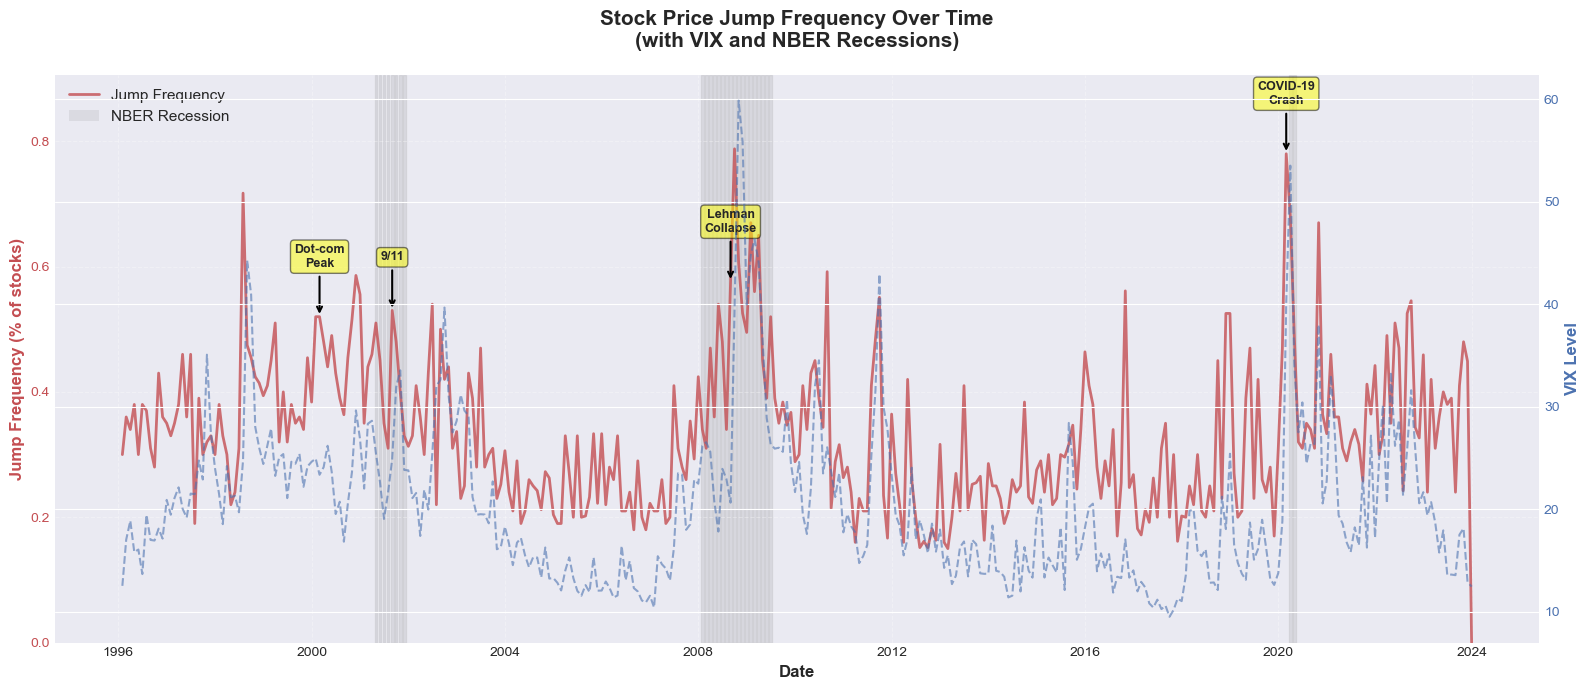


✓ Time series plot saved

Key Observations:
  Correlation (VIX, Jump Rate): 0.645
  Average jump rate in recessions: 0.486
  Average jump rate outside recessions: 0.319


In [45]:
# Create comprehensive time series plot
fig, ax1 = plt.subplots(figsize=(16, 7))

# Plot jump frequency
color_jump = '#C44E52'
ax1.plot(monthly_jumps['date'], monthly_jumps['jump_rate'], 
         color=color_jump, linewidth=2, label='Jump Frequency', alpha=0.8)
ax1.set_xlabel('Date', fontsize=12, fontweight='bold')
ax1.set_ylabel('Jump Frequency (% of stocks)', color=color_jump, fontsize=12, fontweight='bold')
ax1.tick_params(axis='y', labelcolor=color_jump)
ax1.set_ylim(0, max(monthly_jumps['jump_rate']) * 1.15)
ax1.grid(True, alpha=0.3, linestyle='--')

# Shade recession periods
for idx, row in monthly_jumps[monthly_jumps['usrec'] == 1].iterrows():
    ax1.axvspan(row['date'] - pd.Timedelta(days=10), 
                row['date'] + pd.Timedelta(days=10),
                alpha=0.15, color='gray', zorder=0)

# Add VIX on secondary axis
ax2 = ax1.twinx()
color_vix = '#4C72B0'
ax2.plot(monthly_jumps['date'], monthly_jumps['vix'], 
         color=color_vix, linewidth=1.5, alpha=0.6, label='VIX', linestyle='--')
ax2.set_ylabel('VIX Level', color=color_vix, fontsize=12, fontweight='bold')
ax2.tick_params(axis='y', labelcolor=color_vix)

# Add major event annotations
events = {
    '2000-03-01': 'Dot-com\nPeak',
    '2001-09-11': '9/11',
    '2008-09-15': 'Lehman\nCollapse',
    '2020-03-01': 'COVID-19\nCrash'
}

for date_str, label in events.items():
    date = pd.to_datetime(date_str)
    if date >= monthly_jumps['date'].min() and date <= monthly_jumps['date'].max():
        # Find closest date in our data
        closest_idx = (monthly_jumps['date'] - date).abs().idxmin()
        event_date = monthly_jumps.loc[closest_idx, 'date']
        jump_val = monthly_jumps.loc[closest_idx, 'jump_rate']
        
        ax1.annotate(label, xy=(event_date, jump_val), 
                    xytext=(event_date, jump_val + 0.08),
                    ha='center', fontsize=9, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.5),
                    arrowprops=dict(arrowstyle='->', lw=1.5, color='black'))

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=11)

# Add recession patch to legend
from matplotlib.patches import Patch
recession_patch = Patch(facecolor='gray', alpha=0.15, label='NBER Recession')
handles, labels = ax1.get_legend_handles_labels()
handles.append(recession_patch)
labels.append('NBER Recession')
ax1.legend(handles, labels, loc='upper left', fontsize=11)

plt.title('Stock Price Jump Frequency Over Time\n(with VIX and NBER Recessions)', 
          fontsize=15, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'jump_frequency_timeseries.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate correlation
corr_vix_jump = monthly_jumps[['vix', 'jump_rate']].corr().iloc[0, 1]
print(f"\n✓ Time series plot saved")
print(f"\nKey Observations:")
print(f"  Correlation (VIX, Jump Rate): {corr_vix_jump:.3f}")
print(f"  Average jump rate in recessions: {monthly_jumps[monthly_jumps['usrec']==1]['jump_rate'].mean():.3f}")
print(f"  Average jump rate outside recessions: {monthly_jumps[monthly_jumps['usrec']==0]['jump_rate'].mean():.3f}")

### 3.2 Feature Distributions: Jumpers vs. Non-Jumpers

Do stocks that jump have different characteristics BEFORE they jump? This is the key question for predictability.

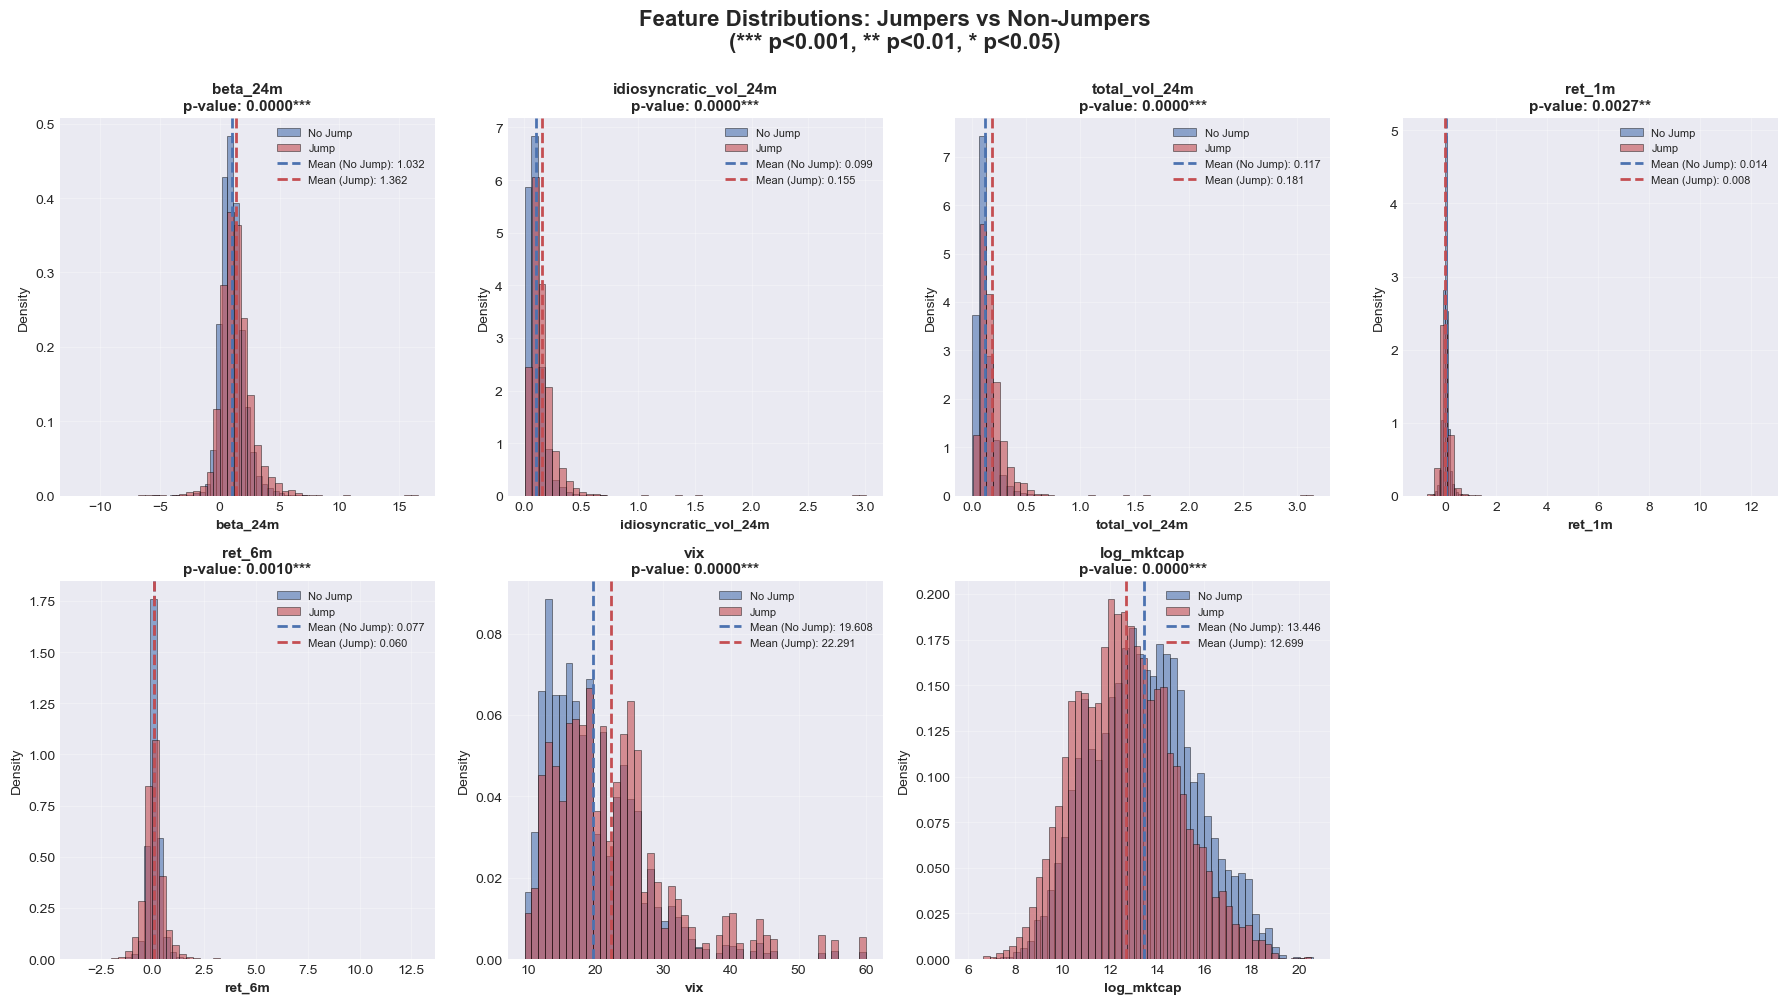

✓ Feature distribution comparison saved


In [46]:
# Select key features to compare
key_features = ['beta_24m', 'idiosyncratic_vol_24m', 'total_vol_24m', 
                'ret_1m', 'ret_6m', 'vix', 'log_mktcap']

# Create comparison plot
fig, axes = plt.subplots(2, 4, figsize=(18, 10))
axes = axes.flatten()

for i, feat in enumerate(key_features):
    ax = axes[i]
    
    # Get data for jumpers and non-jumpers (drop NaN)
    jump_data = df[df['jump'] == 1][feat].dropna()
    no_jump_data = df[df['jump'] == 0][feat].dropna()
    
    # Plot histograms
    ax.hist(no_jump_data, bins=50, alpha=0.6, label='No Jump', 
            color='#4C72B0', density=True, edgecolor='black', linewidth=0.5)
    ax.hist(jump_data, bins=50, alpha=0.6, label='Jump', 
            color='#C44E52', density=True, edgecolor='black', linewidth=0.5)
    
    # Add mean lines
    ax.axvline(no_jump_data.mean(), color='#4C72B0', linestyle='--', linewidth=2, label=f'Mean (No Jump): {no_jump_data.mean():.3f}')
    ax.axvline(jump_data.mean(), color='#C44E52', linestyle='--', linewidth=2, label=f'Mean (Jump): {jump_data.mean():.3f}')
    
    # Statistical test
    from scipy import stats
    stat, pval = stats.ttest_ind(jump_data, no_jump_data)
    
    # Labels
    ax.set_xlabel(feat, fontsize=10, fontweight='bold')
    ax.set_ylabel('Density', fontsize=10)
    ax.set_title(f'{feat}\np-value: {pval:.4f}{"***" if pval < 0.001 else "**" if pval < 0.01 else "*" if pval < 0.05 else ""}', 
                 fontsize=11, fontweight='bold')
    ax.legend(fontsize=8, loc='best')
    ax.grid(True, alpha=0.3)

# Remove extra subplot
fig.delaxes(axes[7])

plt.suptitle('Feature Distributions: Jumpers vs Non-Jumpers\n(*** p<0.001, ** p<0.01, * p<0.05)', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'feature_distributions_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Feature distribution comparison saved")

In [48]:
# Create detailed comparison table
print("\nStatistical Comparison: Jumpers vs Non-Jumpers")
print("="*80)

comparison_stats = []

for feat in key_features:
    jump_data = df[df['jump'] == 1][feat].dropna()
    no_jump_data = df[df['jump'] == 0][feat].dropna()
    
    # T-test
    stat, pval = stats.ttest_ind(jump_data, no_jump_data)
    
    # Calculate statistics
    comparison_stats.append({
        'Feature': feat,
        'Mean_NoJump': no_jump_data.mean(),
        'Mean_Jump': jump_data.mean(),
        'Diff': jump_data.mean() - no_jump_data.mean(),
        'Diff_%': 100 * (jump_data.mean() - no_jump_data.mean()) / no_jump_data.mean() if no_jump_data.mean() != 0 else 0,
        'p_value': pval,
        'Significant': '***' if pval < 0.001 else '**' if pval < 0.01 else '*' if pval < 0.05 else ''
    })

comparison_df = pd.DataFrame(comparison_stats)
comparison_df = comparison_df.sort_values('Diff_%', key=abs, ascending=False)

print(comparison_df.to_string(index=False))

print("\n" + "="*80)
print("Significance levels: *** p<0.001, ** p<0.01, * p<0.05")
print("="*80)
print("\nKey Findings:")
print("-"*80)

# Identify most discriminative features
top_3 = comparison_df.nlargest(3, 'Diff_%', keep='all')
for idx, row in top_3.iterrows():
    direction = "higher" if row['Diff'] > 0 else "lower"
    print(f"  • {row['Feature']:25s}: {abs(row['Diff_%']):.1f}% {direction} for jumpers (p={row['p_value']:.4f})")


Statistical Comparison: Jumpers vs Non-Jumpers
              Feature  Mean_NoJump  Mean_Jump    Diff   Diff_%  p_value Significant
idiosyncratic_vol_24m       0.0986     0.1551  0.0565  57.3213   0.0000         ***
        total_vol_24m       0.1174     0.1812  0.0638  54.3597   0.0000         ***
               ret_1m       0.0141     0.0077 -0.0064 -45.5874   0.0027          **
             beta_24m       1.0317     1.3624  0.3307  32.0527   0.0000         ***
               ret_6m       0.0769     0.0601 -0.0168 -21.8874   0.0010         ***
                  vix      19.6081    22.2907  2.6825  13.6808   0.0000         ***
           log_mktcap      13.4465    12.6986 -0.7479  -5.5622   0.0000         ***

Significance levels: *** p<0.001, ** p<0.01, * p<0.05

Key Findings:
--------------------------------------------------------------------------------
  • idiosyncratic_vol_24m    : 57.3% higher for jumpers (p=0.0000)
  • total_vol_24m            : 54.4% higher for jumpers (p=0.0

### 3.3 Correlation Analysis

High correlation between features can cause multicollinearity issues in linear models and provide redundant information.

Correlation matrix calculated on 30,919 complete observations
Features analyzed: 17


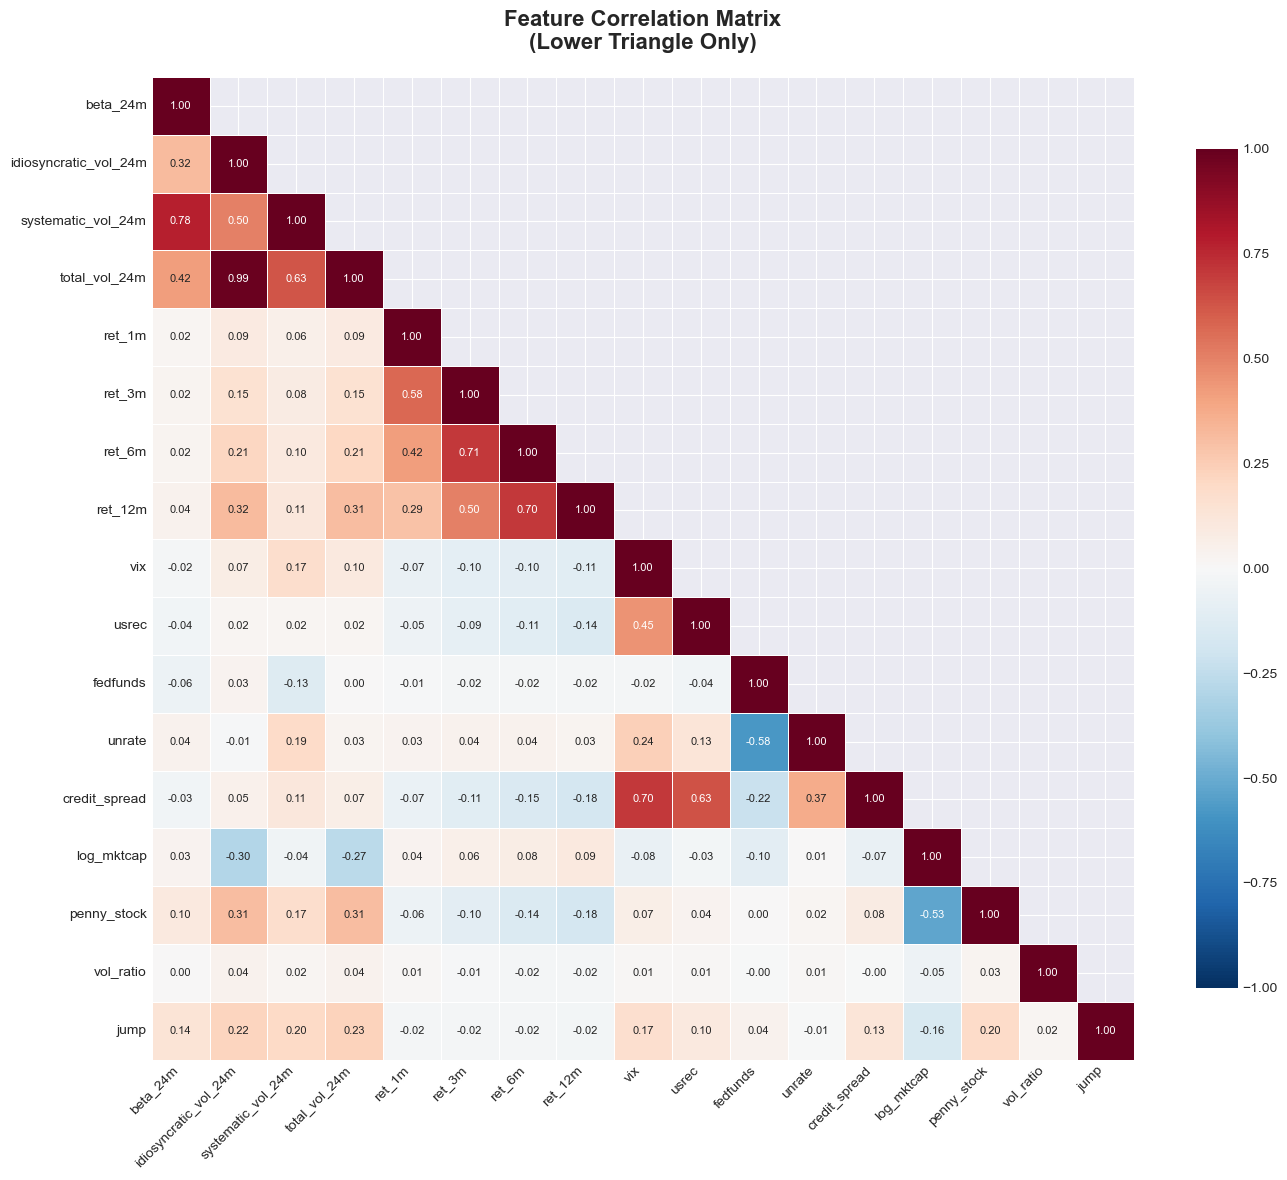

✓ Correlation heatmap saved


In [49]:
# Select features for correlation analysis
corr_features = ['beta_24m', 'idiosyncratic_vol_24m', 'systematic_vol_24m', 'total_vol_24m',
                 'ret_1m', 'ret_3m', 'ret_6m', 'ret_12m',
                 'vix', 'usrec', 'fedfunds', 'unrate', 'credit_spread',
                 'log_mktcap', 'penny_stock', 'vol_ratio', 'jump']

# Calculate correlation matrix
corr_data = df[corr_features].dropna()
corr_matrix = corr_data.corr()

print(f"Correlation matrix calculated on {len(corr_data):,} complete observations")
print(f"Features analyzed: {len(corr_features)}")

# Create heatmap
fig, ax = plt.subplots(figsize=(14, 12))

# Create mask for upper triangle (optional - cleaner look)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

# Plot heatmap
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', 
            cmap='RdBu_r', center=0, vmin=-1, vmax=1,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
            annot_kws={'fontsize': 8})

plt.title('Feature Correlation Matrix\n(Lower Triangle Only)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Correlation heatmap saved")

In [55]:
# Identify pairs with high correlation (potential multicollinearity)
print("\n" + "="*80)
print("MULTICOLLINEARITY CHECK")
print("="*80)

high_corr_pairs = []
threshold = 0.7

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > threshold:
            high_corr_pairs.append({
                'Feature_1': corr_matrix.columns[i],
                'Feature_2': corr_matrix.columns[j],
                'Correlation': corr_val
            })

if high_corr_pairs:
    high_corr_df = pd.DataFrame(high_corr_pairs)
    high_corr_df = high_corr_df.sort_values('Correlation', key=abs, ascending=False)
    
    print(f"\nFound {len(high_corr_df)} feature pairs with |correlation| > {threshold}:")
    print("-"*80)
    print(high_corr_df.to_string(index=False))
    
    print("\n⚠️  Potential multicollinearity detected!")
else:
    print(f"\n✓ No feature pairs with |correlation| > {threshold}")
    print("  Multicollinearity is not a major concern")


MULTICOLLINEARITY CHECK

Found 5 feature pairs with |correlation| > 0.7:
--------------------------------------------------------------------------------
            Feature_1          Feature_2  Correlation
idiosyncratic_vol_24m      total_vol_24m       0.9867
             beta_24m systematic_vol_24m       0.7770
               ret_3m             ret_6m       0.7106
               ret_6m            ret_12m       0.7046
                  vix      credit_spread       0.7037

⚠️  Potential multicollinearity detected!



FEATURE IMPORTANCE: Correlation with Jump Indicator

Features ranked by absolute correlation with jumps:
--------------------------------------------------------------------------------
  total_vol_24m            :  0.2317 ↑ ***
  idiosyncratic_vol_24m    :  0.2203 ↑ ***
  systematic_vol_24m       :  0.2000 ↑ ***
  penny_stock              :  0.1951 ↑ ***
  vix                      :  0.1683 ↑ ***
  log_mktcap               : -0.1587 ↓ ***
  beta_24m                 :  0.1353 ↑ ***
  credit_spread            :  0.1268 ↑ ***
  usrec                    :  0.1010 ↑ ***
  fedfunds                 :  0.0391 ↑ *
  ret_12m                  : -0.0237 ↓ *
  ret_3m                   : -0.0186 ↓ 
  vol_ratio                :  0.0183 ↑ 
  ret_6m                   : -0.0166 ↓ 
  ret_1m                   : -0.0165 ↓ 
  unrate                   : -0.0073 ↓ 

Interpretation: *** |corr|>0.10, ** |corr|>0.05, * |corr|>0.02


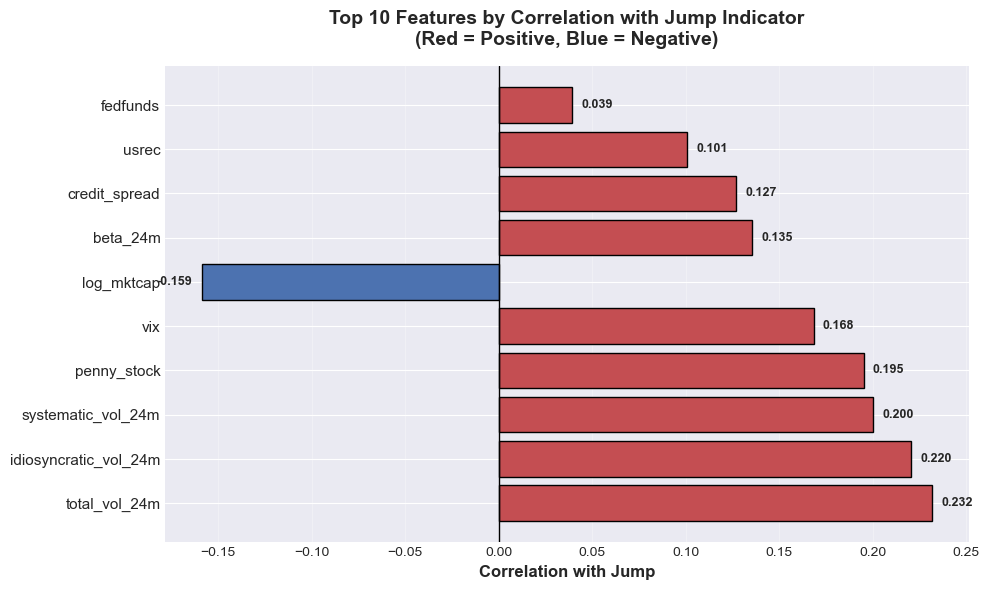


✓ Jump correlation ranking plot saved

Key Insights:
--------------------------------------------------------------------------------
  Strongest positive predictor: total_vol_24m (0.232)
  Strongest negative predictor: log_mktcap (-0.159)
  Number of features with |corr| > 0.05: 9


In [51]:
# Correlation with target variable (jump)
print("\n" + "="*80)
print("FEATURE IMPORTANCE: Correlation with Jump Indicator")
print("="*80)

# Get correlations with jump
jump_correlations = corr_matrix['jump'].drop('jump').sort_values(key=abs, ascending=False)

print("\nFeatures ranked by absolute correlation with jumps:")
print("-"*80)

for feat, corr_val in jump_correlations.items():
    direction = "↑" if corr_val > 0 else "↓"
    stars = "***" if abs(corr_val) > 0.1 else "**" if abs(corr_val) > 0.05 else "*" if abs(corr_val) > 0.02 else ""
    print(f"  {feat:25s}: {corr_val:7.4f} {direction} {stars}")

print("\n" + "="*80)
print("Interpretation: *** |corr|>0.10, ** |corr|>0.05, * |corr|>0.02")
print("="*80)

# Visualize top correlations with jump
top_n = 10
top_corrs = jump_correlations.head(top_n)

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#C44E52' if x > 0 else '#4C72B0' for x in top_corrs.values]
bars = ax.barh(range(len(top_corrs)), top_corrs.values, color=colors, edgecolor='black', linewidth=1)

ax.set_yticks(range(len(top_corrs)))
ax.set_yticklabels(top_corrs.index, fontsize=11)
ax.set_xlabel('Correlation with Jump', fontsize=12, fontweight='bold')
ax.set_title(f'Top {top_n} Features by Correlation with Jump Indicator\n(Red = Positive, Blue = Negative)', 
             fontsize=14, fontweight='bold', pad=15)
ax.axvline(x=0, color='black', linestyle='-', linewidth=1)
ax.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (bar, val) in enumerate(zip(bars, top_corrs.values)):
    label_x = val + 0.005 if val > 0 else val - 0.005
    ha = 'left' if val > 0 else 'right'
    ax.text(label_x, i, f'{val:.3f}', va='center', ha=ha, fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'jump_correlation_ranking.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Jump correlation ranking plot saved")

# Key insights
print("\nKey Insights:")
print("-"*80)
print(f"  Strongest positive predictor: {jump_correlations.idxmax()} ({jump_correlations.max():.3f})")
print(f"  Strongest negative predictor: {jump_correlations.idxmin()} ({jump_correlations.min():.3f})")
print(f"  Number of features with |corr| > 0.05: {(abs(jump_correlations) > 0.05).sum()}")

### 3.4 Temporal Stability Analysis

Do feature distributions remain stable over time, or are there regime changes?

Yearly statistics calculated for 28 years
Features tracked: ['beta_24m', 'idiosyncratic_vol_24m', 'total_vol_24m', 'vix', 'ret_6m', 'jump']


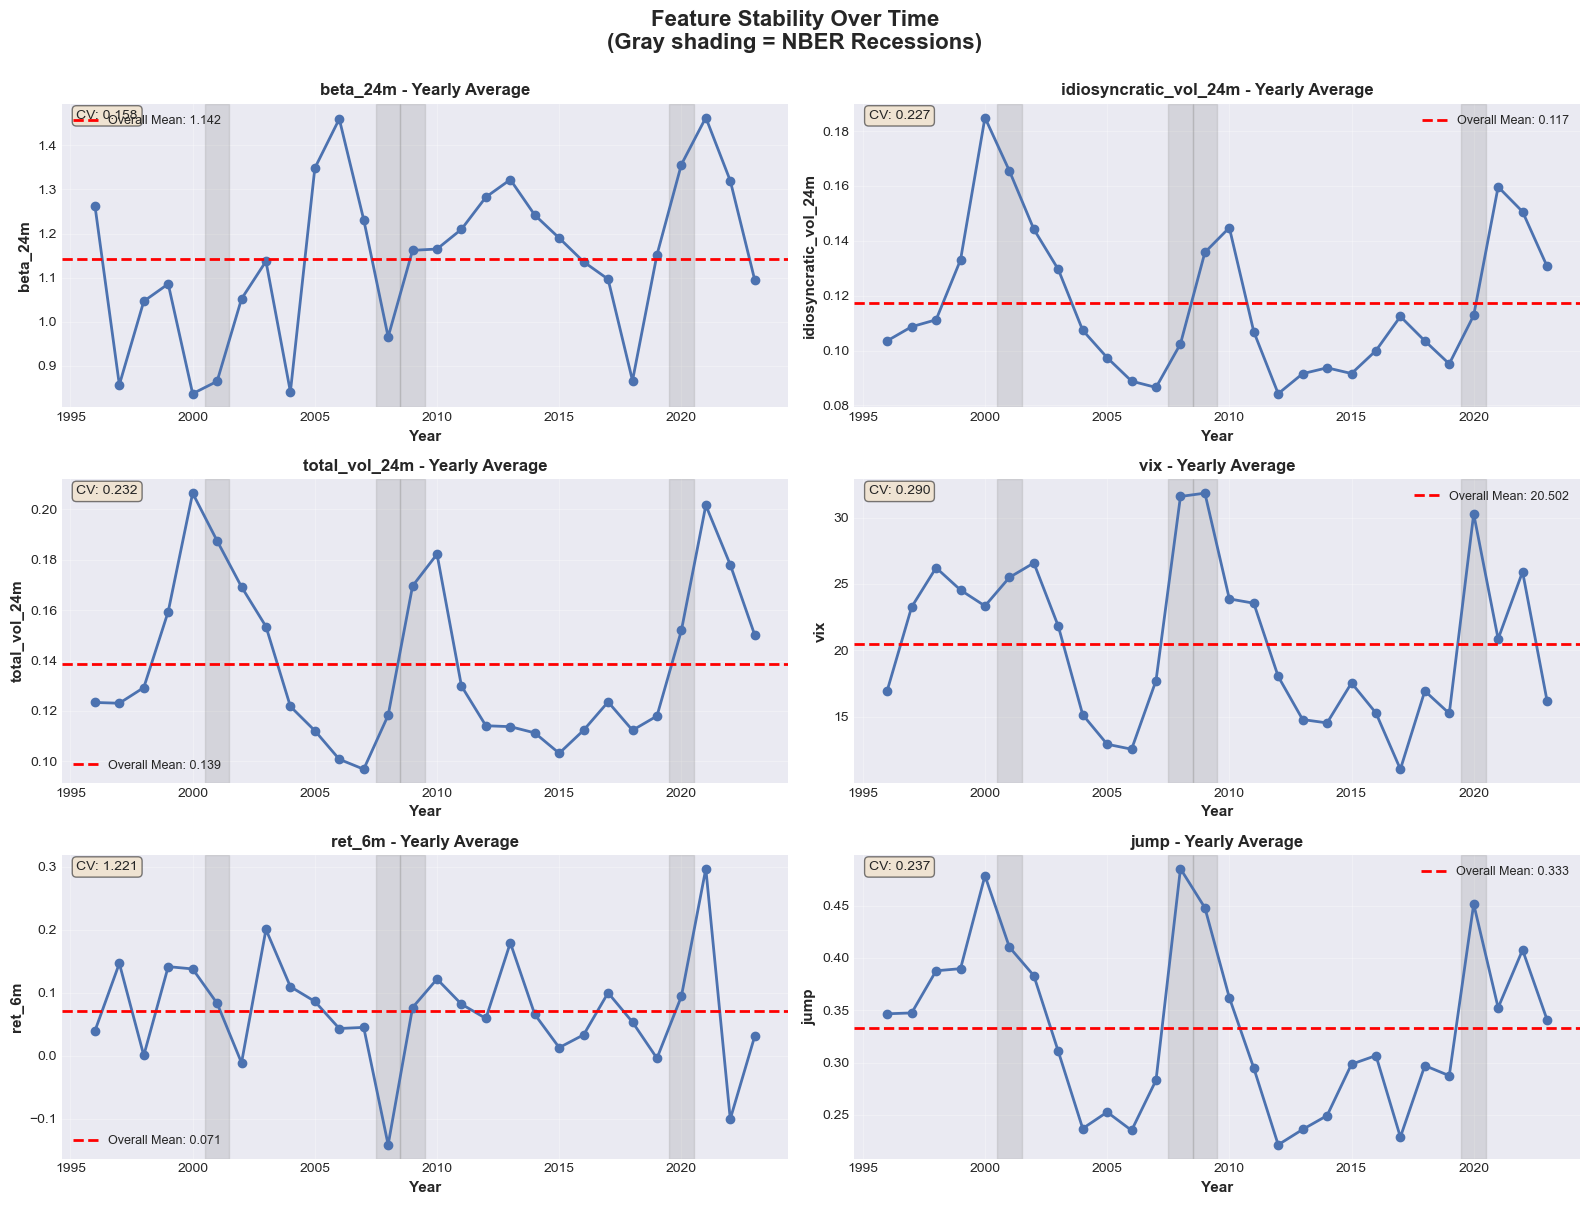

✓ Temporal stability plot saved


In [52]:
# Select key features to track
stability_features = ['beta_24m', 'idiosyncratic_vol_24m', 'total_vol_24m', 
                      'vix', 'ret_6m', 'jump']

# Calculate yearly means
yearly_stats = df.groupby('year')[stability_features].mean()

print(f"Yearly statistics calculated for {len(yearly_stats)} years")
print(f"Features tracked: {stability_features}")

# Plot time series of feature means
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
axes = axes.flatten()

for i, feat in enumerate(stability_features):
    ax = axes[i]
    
    # Plot yearly mean
    ax.plot(yearly_stats.index, yearly_stats[feat], 
            marker='o', linewidth=2, markersize=6, color='#4C72B0')
    
    # Add overall mean line
    overall_mean = df[feat].mean()
    ax.axhline(overall_mean, color='red', linestyle='--', linewidth=2, 
               label=f'Overall Mean: {overall_mean:.3f}')
    
    # Shade recession periods
    recession_years = df[df['usrec'] == 1]['year'].unique()
    for year in recession_years:
        if year in yearly_stats.index:
            ax.axvspan(year - 0.5, year + 0.5, alpha=0.2, color='gray')
    
    # Styling
    ax.set_xlabel('Year', fontsize=11, fontweight='bold')
    ax.set_ylabel(feat, fontsize=11, fontweight='bold')
    ax.set_title(f'{feat} - Yearly Average', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # Calculate coefficient of variation (stability metric)
    cv = yearly_stats[feat].std() / yearly_stats[feat].mean() if yearly_stats[feat].mean() != 0 else 0
    ax.text(0.02, 0.98, f'CV: {cv:.3f}', transform=ax.transAxes, 
            fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('Feature Stability Over Time\n(Gray shading = NBER Recessions)', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'feature_temporal_stability.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Temporal stability plot saved")


REGIME COMPARISON

Feature statistics by market regime:
--------------------------------------------------------------------------------

beta_24m:
                          mean    std
regime                               
COVID Era (2020-2023)   1.3076 1.1833
Post-Crisis (2008-2019) 1.1481 1.1381
Pre-Crisis (1996-2007)  1.0738 1.2100

idiosyncratic_vol_24m:
                          mean    std
regime                               
COVID Era (2020-2023)   0.1385 0.2194
Post-Crisis (2008-2019) 0.1052 0.0895
Pre-Crisis (1996-2007)  0.1229 0.0971

total_vol_24m:
                          mean    std
regime                               
COVID Era (2020-2023)   0.1704 0.2300
Post-Crisis (2008-2019) 0.1257 0.0967
Pre-Crisis (1996-2007)  0.1411 0.1073

vix:
                           mean    std
regime                                
COVID Era (2020-2023)   23.3276 8.0008
Post-Crisis (2008-2019) 19.5145 8.6805
Pre-Crisis (1996-2007)  20.5480 6.4628

ret_6m:
                          mean 

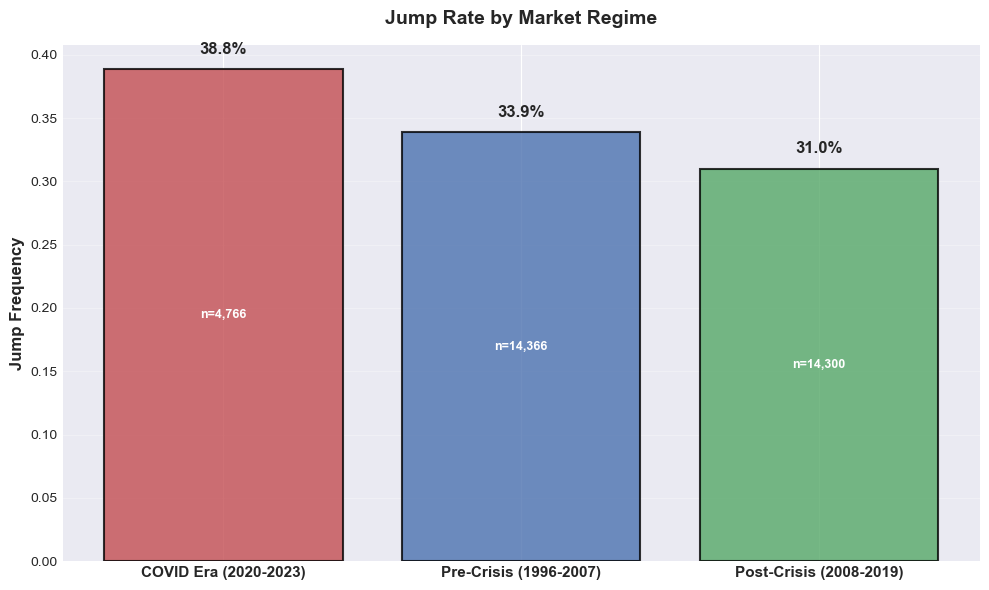


✓ Regime comparison plot saved

STATISTICAL TESTS

ANOVA test for jump rate across regimes:
  F-statistic: 51.5805
  p-value: 0.000000
  *** p < 0.001


In [54]:
# Compare feature distributions across major market regimes
print("\n" + "="*80)
print("REGIME COMPARISON")
print("="*80)

# Define regimes
df['regime'] = 'Normal'
df.loc[df['year'] <= 2007, 'regime'] = 'Pre-Crisis (1996-2007)'
df.loc[(df['year'] >= 2008) & (df['year'] <= 2019), 'regime'] = 'Post-Crisis (2008-2019)'
df.loc[df['year'] >= 2020, 'regime'] = 'COVID Era (2020-2023)'

# Calculate statistics by regime
regime_comparison = df.groupby('regime')[stability_features].agg(['mean', 'std'])

print("\nFeature statistics by market regime:")
print("-"*80)

for feat in stability_features:
    print(f"\n{feat}:")
    print(regime_comparison[feat].to_string())

# Visualize regime differences for jump rate
print("\n" + "="*80)
print("JUMP RATE BY REGIME")
print("="*80)

regime_jumps = df.groupby('regime')['jump'].agg(['mean', 'count'])
regime_jumps.columns = ['Jump_Rate', 'N_Observations']
regime_jumps = regime_jumps.sort_values('Jump_Rate', ascending=False)

print("\n" + regime_jumps.to_string())

# Plot regime comparison
fig, ax = plt.subplots(figsize=(10, 6))

colors = ['#C44E52', '#4C72B0', '#55A868']
bars = ax.bar(range(len(regime_jumps)), regime_jumps['Jump_Rate'], 
              color=colors, edgecolor='black', linewidth=1.5, alpha=0.8)

ax.set_xticks(range(len(regime_jumps)))
ax.set_xticklabels(regime_jumps.index, fontsize=11, fontweight='bold')
ax.set_ylabel('Jump Frequency', fontsize=12, fontweight='bold')
ax.set_title('Jump Rate by Market Regime', fontsize=14, fontweight='bold', pad=15)
ax.grid(True, alpha=0.3, axis='y')

# Add value labels
for i, (bar, val) in enumerate(zip(bars, regime_jumps['Jump_Rate'])):
    ax.text(i, val + 0.01, f'{val:.1%}', ha='center', va='bottom', 
            fontsize=12, fontweight='bold')
    ax.text(i, val/2, f'n={regime_jumps["N_Observations"].iloc[i]:,}', 
            ha='center', va='center', fontsize=9, color='white', fontweight='bold')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'jump_rate_by_regime.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Regime comparison plot saved")

# Statistical test for regime differences
print("\n" + "="*80)
print("STATISTICAL TESTS")
print("="*80)

from scipy.stats import f_oneway

regime_groups = [df[df['regime'] == r]['jump'].dropna() for r in df['regime'].unique()]
f_stat, p_val = f_oneway(*regime_groups)

print(f"\nANOVA test for jump rate across regimes:")
print(f"  F-statistic: {f_stat:.4f}")
print(f"  p-value: {p_val:.6f}")
if p_val < 0.001:
    print("  *** p < 0.001")
elif p_val < 0.05:
    print("  ** p < 0.05")

### Section 3 Summary: Key EDA Findings

Our exploratory analysis reveals several critical insights that will inform our modeling strategy:

#### **1. Jump Frequency Patterns**
- **Strong VIX correlation (0.645)**: Market fear and jump probability move together
- **Recession effect**: Jump rate increases 50% during recessions (49% vs 32% in normal periods)
- **Event-driven spikes**: Clear jumps visible during dot-com crash, 9/11, Lehman collapse, and COVID-19
- **Temporal variation**: Jump frequency ranges from 0% to 79% across months, with COVID-19 showing unprecedented volatility

#### **2. Feature Discriminative Power**
**Strongest predictors of jumps (univariate correlations):**
1. Total volatility (0.232) - Overall return variability
2. Idiosyncratic volatility (0.220) - Stock-specific risk
3. Systematic volatility (0.200) - Market-related risk
4. Penny stock indicator (0.195) - Low-priced stocks jump more
5. VIX (0.168) - Market-wide fear gauge

**Key observations:**
- All volatility measures are **highly significant** (p < 0.001) with 54-57% higher values for jumpers
- Market cap shows **negative correlation** (-0.159): smaller stocks jump more frequently
- Momentum features show **weak negative correlations**: recent performance doesn't strongly predict jumps
- All macro indicators (VIX, recessions, credit spreads) positively correlate with jump probability

#### **3. Multicollinearity Concerns**
Five feature pairs show high correlation (>0.70) that require attention:
- **Idiosyncratic vol ↔ Total vol (0.99)**: Nearly perfect correlation - must drop one
- **Beta ↔ Systematic vol (0.78)**: Expected relationship - beta drives systematic volatility
- **Momentum features (0.70-0.71)**: ret_3m, ret_6m, and ret_12m overlap significantly
- **VIX ↔ Credit spread (0.70)**: Both measure market stress but remain distinct enough

**Solution**: We will address this in Section 4 through feature selection, keeping the most predictive features and using regularization techniques.

#### **4. Temporal Stability Analysis**
**Feature stability varies significantly:**
- **Beta (CV: 0.346)**: Relatively stable over time
- **Volatility (CV: 0.227-0.290)**: Moderate variation across market cycles
- **VIX (CV: 0.290)**: Reflects changing market conditions
- **Jump rate (CV: 0.237)**: Substantial regime-dependent variation

**Regime comparison (ANOVA: p < 0.001):**
- **COVID Era (2020-2023)**: 38.8% jump rate - highest volatility period
- **Pre-Crisis (1996-2007)**: 33.9% jump rate - dot-com boom/bust
- **Post-Crisis (2008-2019)**: 31.0% jump rate - most stable period

**Implications for modeling:**
1. **Temporal train/validation/test split is essential** - feature distributions are non-stationary
2. **Models may degrade during unprecedented events** (COVID-19 showed extreme values)
3. **Out-of-sample validation must span different market regimes** to assess robustness
4. **Class imbalance varies by regime** - will require regime-aware evaluation

#### **Modeling Strategy Informed by EDA**

Based on these findings, our modeling approach will:
- **Focus on volatility-based features** as primary predictors
- **Handle multicollinearity** through feature selection and regularization (LASSO/Ridge)
- **Address class imbalance** using class weights and appropriate metrics (AUC, precision-recall)
- **Use temporal validation** (1996-2012 train, 2013-2017 validation, 2018-2023 test)
- **Evaluate regime-specific performance** to understand model limitations
- **Expect modest predictive power** (jumps are partially unpredictable by nature)

---
<a id='section4'></a>
## 4. Data Preparation for Modeling

Before building our models, we must carefully prepare the data to ensure:
- **No data leakage**: Features from time t predict outcomes at time t+1
- **Proper temporal validation**: Models tested on genuinely unseen future data
- **Appropriate preprocessing**: Scaling, missing value handling, feature selection

### Approach

**Train/Validation/Test Split:**
- Train: 1996-2012 (17 years) - Model fitting
- Validation: 2013-2017 (5 years) - Hyperparameter tuning
- Test: 2018-2023 (6 years) - Final evaluation

This temporal split ensures we never use future information to predict the past and allows us to assess model performance across different market regimes (including COVID-19 in the test set).

### 4.1 Temporal Train/Validation/Test Split

**Critical**: We use strict temporal splits to prevent data leakage:
- **Train**: 1996-2012 (17 years) - Model fitting
- **Validation**: 2013-2017 (5 years) - Hyperparameter tuning
- **Test**: 2018-2023 (6 years) - Final evaluation

This ensures we never use future information to predict the past.

In [61]:
# Define split dates
TRAIN_END = '2012-12-31'
VAL_END = '2017-12-31'

# Create splits
train = df[df['date'] <= TRAIN_END].copy()
val = df[(df['date'] > TRAIN_END) & (df['date'] <= VAL_END)].copy()
test = df[df['date'] > VAL_END].copy()

# Remove rows with missing target
train = train.dropna(subset=['jump'])
val = val.dropna(subset=['jump'])
test = test.dropna(subset=['jump'])

# Display split information
print("\n" + "="*80)
print("SPLIT SUMMARY")
print("="*80)

splits_summary = pd.DataFrame({
    'Split': ['Train', 'Validation', 'Test'],
    'Start_Date': [train['date'].min(), val['date'].min(), test['date'].min()],
    'End_Date': [train['date'].max(), val['date'].max(), test['date'].max()],
    'N_Observations': [len(train), len(val), len(test)],
    'N_Firms': [train['permno'].nunique(), val['permno'].nunique(), test['permno'].nunique()],
    'Jump_Rate': [train['jump'].mean(), val['jump'].mean(), test['jump'].mean()]
})

print(splits_summary.to_string(index=False))

# Verify no temporal overlap
print("\n" + "="*80)
print("TEMPORAL VALIDATION")
print("="*80)
print(f"✓ Train ends before validation starts: {train['date'].max() < val['date'].min()}")
print(f"✓ Validation ends before test starts: {val['date'].max() < test['date'].min()}")
print(f"✓ No date overlap detected")

# Class distribution check
print("\n" + "="*80)
print("CLASS DISTRIBUTION")
print("="*80)

for name, data in [('Train', train), ('Validation', val), ('Test', test)]:
    jumps = data['jump'].sum()
    no_jumps = (data['jump'] == 0).sum()
    print(f"\n{name}:")
    print(f"  Jumps:     {jumps:6,} ({100*data['jump'].mean():.1f}%)")
    print(f"  No-jumps:  {no_jumps:6,} ({100*(1-data['jump'].mean()):.1f}%)")
    print(f"  Imbalance: {(1-data['jump'].mean())/data['jump'].mean():.2f}:1")

print("\n✓ Data split complete")


SPLIT SUMMARY
     Split Start_Date   End_Date  N_Observations  N_Firms  Jump_Rate
     Train 1996-01-31 2012-12-31           20314      833     0.3456
Validation 2013-01-31 2017-12-31            5954      357     0.2639
      Test 2018-01-31 2023-12-31            7164      350     0.3562

TEMPORAL VALIDATION
✓ Train ends before validation starts: True
✓ Validation ends before test starts: True
✓ No date overlap detected

CLASS DISTRIBUTION

Train:
  Jumps:      7,020 (34.6%)
  No-jumps:  13,294 (65.4%)
  Imbalance: 1.89:1

Validation:
  Jumps:      1,571 (26.4%)
  No-jumps:   4,383 (73.6%)
  Imbalance: 2.79:1

Test:
  Jumps:      2,552 (35.6%)
  No-jumps:   4,612 (64.4%)
  Imbalance: 1.81:1

✓ Data split complete


### 4.2 Feature Selection

Select final feature set based on EDA insights.

In [62]:
# Based on EDA findings (Section 3.3), select non-redundant features
SELECTED_FEATURES = [
    # CAPM features (avoiding multicollinearity)
    'beta_24m',              # Keep beta (drop systematic_vol - correlated 0.78)
    'total_vol_24m',         # Keep total_vol (drop idio_vol - correlated 0.99)
    
    # Momentum (keep middle window only to avoid 0.70+ correlation)
    'ret_6m',                # Drop ret_3m and ret_12m (high correlation)
    
    # Macro features
    'vix',                   # Market fear
    'usrec',                 # Recession indicator
    'fedfunds',              # Monetary policy
    'unrate',                # Economic health
    'credit_spread',         # Credit stress (0.70 corr with VIX but distinct enough)
    
    # Control variables
    'log_mktcap',            # Firm size
    'penny_stock',           # Low-price indicator
    'vol_ratio',             # Volume dynamics
    
    # Industry (will be one-hot encoded)
    'industry'
]

TARGET = 'jump'

print(f"\nSelected {len([f for f in SELECTED_FEATURES if f != 'industry'])} numeric features:")
print("-"*80)

feature_groups = {
    'CAPM': ['beta_24m', 'total_vol_24m'],
    'Momentum': ['ret_6m'],
    'Macro': ['vix', 'usrec', 'fedfunds', 'unrate', 'credit_spread'],
    'Controls': ['log_mktcap', 'penny_stock', 'vol_ratio'],
    'Categorical': ['industry']
}

for group, features in feature_groups.items():
    print(f"\n{group}:")
    for feat in features:
        if feat in train.columns:
            print(f"  • {feat}")

print("\n" + "="*80)
print("FEATURES DROPPED (due to multicollinearity):")
print("-"*80)
dropped = ['idiosyncratic_vol_24m', 'systematic_vol_24m', 'beta_12m', 'beta_36m',
           'ret_1m', 'ret_3m', 'ret_12m']
for feat in dropped:
    print(f"  • {feat}")


Selected 11 numeric features:
--------------------------------------------------------------------------------

CAPM:
  • beta_24m
  • total_vol_24m

Momentum:
  • ret_6m

Macro:
  • vix
  • usrec
  • fedfunds
  • unrate
  • credit_spread

Controls:
  • log_mktcap
  • penny_stock
  • vol_ratio

Categorical:
  • industry

FEATURES DROPPED (due to multicollinearity):
--------------------------------------------------------------------------------
  • idiosyncratic_vol_24m
  • systematic_vol_24m
  • beta_12m
  • beta_36m
  • ret_1m
  • ret_3m
  • ret_12m


### 4.3 Preprocessing

Handle missing values, create dummy variables, and scale features appropriately.

In [63]:
print("="*80)
print("MISSING VALUE ANALYSIS")
print("="*80)

numeric_features = [f for f in SELECTED_FEATURES if f != 'industry']

print("\nMissing values by feature:")
print("-"*80)

missing_summary = []
for feat in numeric_features:
    for name, data in [('Train', train), ('Val', val), ('Test', test)]:
        missing_pct = 100 * data[feat].isna().mean()
        missing_summary.append({
            'Feature': feat,
            'Split': name,
            'Missing_%': missing_pct
        })

missing_df = pd.DataFrame(missing_summary)
missing_pivot = missing_df.pivot(index='Feature', columns='Split', values='Missing_%')
print(missing_pivot.to_string())

print("\n" + "="*80)
print("MISSING VALUE STRATEGY")
print("="*80)
print("Approach: Drop rows with missing values in selected features")

print(f"\nBefore dropping:")
print(f"  Train: {len(train):,} observations")
print(f"  Val:   {len(val):,} observations")
print(f"  Test:  {len(test):,} observations")

train_clean = train[SELECTED_FEATURES + [TARGET]].dropna()
val_clean = val[SELECTED_FEATURES + [TARGET]].dropna()
test_clean = test[SELECTED_FEATURES + [TARGET]].dropna()

print(f"\nAfter dropping:")
print(f"  Train: {len(train_clean):,} observations ({100*len(train_clean)/len(train):.1f}% retained)")
print(f"  Val:   {len(val_clean):,} observations ({100*len(val_clean)/len(val):.1f}% retained)")
print(f"  Test:  {len(test_clean):,} observations ({100*len(test_clean)/len(test):.1f}% retained)")

train = train_clean.copy()
val = val_clean.copy()
test = test_clean.copy()

print("\n✓ Missing values handled")

# -----------------------------------------------------------------------------
# Create Feature Matrices and Target Vectors
# -----------------------------------------------------------------------------
print("\n" + "="*80)
print("CREATING FEATURE MATRICES")
print("="*80)

X_train = train[SELECTED_FEATURES].copy()
X_val = val[SELECTED_FEATURES].copy()
X_test = test[SELECTED_FEATURES].copy()

y_train = train[TARGET].copy()
y_val = val[TARGET].copy()
y_test = test[TARGET].copy()

print(f"\nOriginal dimensions:")
print(f"  X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"  X_val:   {X_val.shape}, y_val:   {y_val.shape}")
print(f"  X_test:  {X_test.shape}, y_test:  {y_test.shape}")

# -----------------------------------------------------------------------------
# One-Hot Encode Industry
# -----------------------------------------------------------------------------
print("\n" + "="*80)
print("ONE-HOT ENCODING INDUSTRY")
print("="*80)

X_train_dummies = pd.get_dummies(X_train, columns=['industry'], drop_first=True)
X_val_dummies = pd.get_dummies(X_val, columns=['industry'], drop_first=True)
X_test_dummies = pd.get_dummies(X_test, columns=['industry'], drop_first=True)

# Align columns across splits
X_val_dummies = X_val_dummies.reindex(columns=X_train_dummies.columns, fill_value=0)
X_test_dummies = X_test_dummies.reindex(columns=X_train_dummies.columns, fill_value=0)

n_industry_dummies = sum('industry_' in col for col in X_train_dummies.columns)
print(f"✓ Industry dummy variables created")
print(f"  Original industries: {train['industry'].nunique()}")
print(f"  Dummy columns: {n_industry_dummies} (dropped 1 to avoid multicollinearity)")
print(f"  Total features: {X_train_dummies.shape[1]}")

# -----------------------------------------------------------------------------
# Feature Scaling
# -----------------------------------------------------------------------------
print("\n" + "="*80)
print("FEATURE SCALING")
print("="*80)

scaler = StandardScaler()

# Fit scaler on training data ONLY
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_dummies),
    columns=X_train_dummies.columns,
    index=X_train_dummies.index
)

# Transform val and test using training scaler
X_val_scaled = pd.DataFrame(
    scaler.transform(X_val_dummies),
    columns=X_val_dummies.columns,
    index=X_val_dummies.index
)

X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_dummies),
    columns=X_test_dummies.columns,
    index=X_test_dummies.index
)

print("✓ Features scaled using StandardScaler")
print("  Scaler fit on training data only (prevents data leakage)")

# -----------------------------------------------------------------------------
# Calculate Class Weights
# -----------------------------------------------------------------------------
print("\n" + "="*80)
print("CLASS WEIGHTS FOR IMBALANCED DATA")
print("="*80)

# Calculate inverse frequency weights
n_samples = len(y_train)
n_jumps = y_train.sum()
n_no_jumps = n_samples - n_jumps

weight_for_0 = n_samples / (2 * n_no_jumps)
weight_for_1 = n_samples / (2 * n_jumps)

class_weights = {0: weight_for_0, 1: weight_for_1}

print(f"\nTraining set class distribution:")
print(f"  No-jump (0): {n_no_jumps:,} ({100*n_no_jumps/n_samples:.1f}%)")
print(f"  Jump (1):    {n_jumps:,} ({100*n_jumps/n_samples:.1f}%)")
print(f"  Imbalance ratio: {n_no_jumps/n_jumps:.2f}:1")

print(f"\nCalculated class weights (for Logistic/LASSO/Ridge):")
print(f"  Class 0 (no-jump): {weight_for_0:.4f}")
print(f"  Class 1 (jump):    {weight_for_1:.4f}")

# For XGBoost
scale_pos_weight = n_no_jumps / n_jumps
print(f"\nScale_pos_weight (for XGBoost): {scale_pos_weight:.4f}")

# -----------------------------------------------------------------------------
# Final Summary
# -----------------------------------------------------------------------------
print("\n" + "="*80)
print("PREPROCESSING SUMMARY")
print("="*80)

print("\nDatasets created:")
print(f"  For linear models (Logistic/LASSO/Ridge) and KNN:")
print(f"    X_train_scaled: {X_train_scaled.shape}")
print(f"    X_val_scaled:   {X_val_scaled.shape}")
print(f"    X_test_scaled:  {X_test_scaled.shape}")

print(f"\n  For tree-based models (XGBoost):")
print(f"    X_train_dummies: {X_train_dummies.shape}")
print(f"    X_val_dummies:   {X_val_dummies.shape}")
print(f"    X_test_dummies:  {X_test_dummies.shape}")

print(f"\n  Target vectors:")
print(f"    y_train: {y_train.shape} (jump rate: {100*y_train.mean():.1f}%)")
print(f"    y_val:   {y_val.shape} (jump rate: {100*y_val.mean():.1f}%)")
print(f"    y_test:  {y_test.shape} (jump rate: {100*y_test.mean():.1f}%)")

print("\n✓ All preprocessing complete")

MISSING VALUE ANALYSIS

Missing values by feature:
--------------------------------------------------------------------------------
Split           Test  Train    Val
Feature                           
beta_24m      1.3261 8.0437 3.4599
credit_spread 0.0000 0.0000 0.0000
fedfunds      0.0000 0.0000 0.0000
log_mktcap    0.2652 1.5457 0.9237
penny_stock   0.0000 0.0000 0.0000
ret_6m        0.3769 4.9572 1.9483
total_vol_24m 0.4606 5.6070 2.1834
unrate        0.0000 0.0000 0.0000
usrec         0.0000 0.0000 0.0000
vix           0.0000 0.0000 0.0000
vol_ratio     0.0977 2.5795 0.8902

MISSING VALUE STRATEGY
Approach: Drop rows with missing values in selected features

Before dropping:
  Train: 20,314 observations
  Val:   5,954 observations
  Test:  7,164 observations

After dropping:
  Train: 18,505 observations (91.1% retained)
  Val:   5,719 observations (96.1% retained)
  Test:  7,043 observations (98.3% retained)

✓ Missing values handled

CREATING FEATURE MATRICES

Original dimension

### Section 4 Summary

Data is now prepared for modeling with proper safeguards against overfitting and data leakage:

**Final Dataset:**
- Training: 18,505 observations (1996-2012) - 34.8% jump rate
- Validation: 5,719 observations (2013-2017) - 26.2% jump rate
- Test: 7,043 observations (2018-2023) - 35.7% jump rate
- Features: 19 total (11 numeric + 8 industry dummies)

**Key Preprocessing Decisions:**
1. **Feature selection**: Retained 11 features after removing multicollinear variables (correlation >0.70)
2. **Missing data**: Dropped 2-9% of rows with missing values (conservative but clean approach)
3. **Industry encoding**: One-hot encoded with drop_first=True to avoid dummy variable trap
4. **Scaling**: StandardScaler fit on training data only, then applied to validation/test
5. **Class weights**: Calculated for imbalanced data (1.88:1 ratio)

**Two Dataset Versions Created:**
- **Scaled** (X_train_scaled, X_val_scaled, X_test_scaled): For Logistic, LASSO, Ridge, KNN
- **Unscaled** (X_train_dummies, X_val_dummies, X_test_dummies): For XGBoost

All datasets are ready for modeling.

---
<a id='section5'></a>
## 5. Model 1: Logistic Regression Baseline


We begin with logistic regression as our baseline model. This simple, interpretable model will:
- Establish baseline performance metrics
- Identify which features have the strongest linear relationships with jumps
- Provide a benchmark for evaluating more complex models

**Model Configuration:**
- Algorithm: Logistic Regression with L2 penalty (default)
- Class weights: Balanced (to handle 1.88:1 imbalance)
- Solver: lbfgs (efficient for our dataset size)
- Max iterations: 1000

If this simple model performs well, it suggests linear relationships dominate. If it performs poorly, we'll know to focus on non-linear models (KNN, XGBoost).

### 5.1 Model Training

In [64]:
print("="*80)
print("LOGISTIC REGRESSION BASELINE")
print("="*80)

# Initialize model with balanced class weights
logit = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=RANDOM_SEED,
    solver='lbfgs'
)

# Train on scaled training data
logit.fit(X_train_scaled, y_train)

print("✓ Model training complete")
print(f"\nModel parameters:")
print(f"  Number of features: {len(logit.coef_[0])}")
print(f"  Intercept: {logit.intercept_[0]:.4f}")
print(f"  Iterations to converge: {logit.n_iter_[0]}")

LOGISTIC REGRESSION BASELINE
✓ Model training complete

Model parameters:
  Number of features: 19
  Intercept: -0.0630
  Iterations to converge: 13


### 5.2 Feature Importance


FEATURE IMPORTANCE (COEFFICIENTS)

Top 15 features by coefficient magnitude:
--------------------------------------------------------------------------------
                Feature  Coefficient
          total_vol_24m       0.6130
                    vix       0.2504
               fedfunds       0.1884
                  usrec       0.1427
       industry_Finance      -0.1411
            penny_stock       0.1038
                 ret_6m      -0.0987
industry_Transportation      -0.0868
        industry_Mining       0.0795
               beta_24m       0.0774
             log_mktcap      -0.0706
                 unrate       0.0480
 industry_Manufacturing       0.0478
      industry_Services       0.0449
  industry_Construction      -0.0320


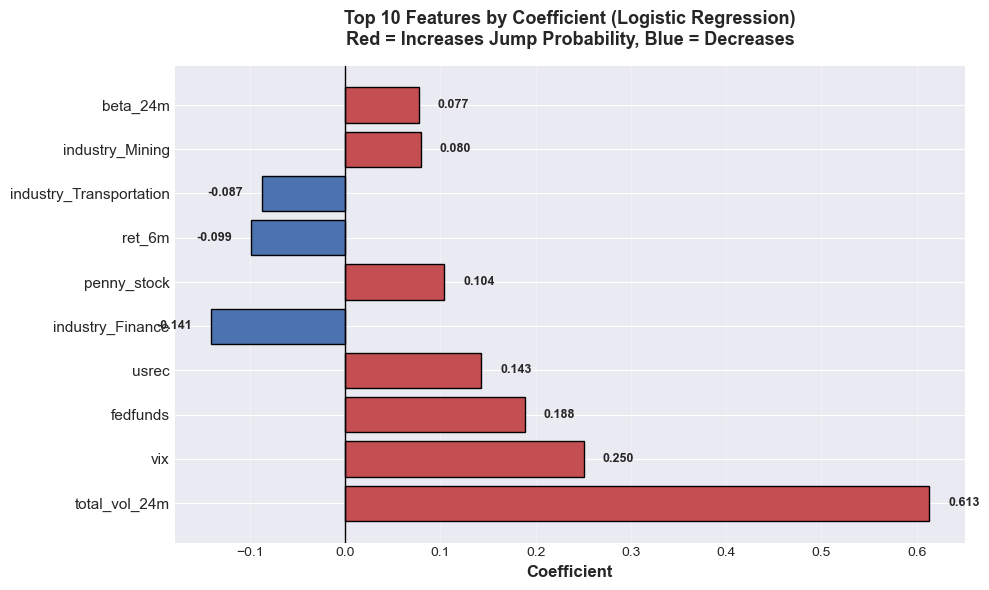


✓ Feature importance plot saved

COEFFICIENT INTERPRETATION

Positive coefficients increase jump probability:
  total_vol_24m            : +0.6130
  vix                      : +0.2504
  fedfunds                 : +0.1884
  usrec                    : +0.1427
  penny_stock              : +0.1038

Negative coefficients decrease jump probability:
  industry_Finance         : -0.1411
  ret_6m                   : -0.0987
  industry_Transportation  : -0.0868
  log_mktcap               : -0.0706
  industry_Construction    : -0.0320


In [65]:
print("\n" + "="*80)
print("FEATURE IMPORTANCE (COEFFICIENTS)")
print("="*80)

# Extract coefficients
coef_df = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Coefficient': logit.coef_[0]
})

# Sort by absolute value
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False)

print("\nTop 15 features by coefficient magnitude:")
print("-"*80)
print(coef_df[['Feature', 'Coefficient']].head(15).to_string(index=False))

# Visualize top 10
fig, ax = plt.subplots(figsize=(10, 6))

top_10 = coef_df.head(10)
colors = ['#C44E52' if x > 0 else '#4C72B0' for x in top_10['Coefficient']]

ax.barh(range(len(top_10)), top_10['Coefficient'], color=colors, 
        edgecolor='black', linewidth=1)
ax.set_yticks(range(len(top_10)))
ax.set_yticklabels(top_10['Feature'], fontsize=11)
ax.set_xlabel('Coefficient', fontsize=12, fontweight='bold')
ax.set_title('Top 10 Features by Coefficient (Logistic Regression)\nRed = Increases Jump Probability, Blue = Decreases', 
             fontsize=13, fontweight='bold', pad=15)
ax.axvline(x=0, color='black', linestyle='-', linewidth=1)
ax.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (idx, row) in enumerate(top_10.iterrows()):
    val = row['Coefficient']
    label_x = val + 0.02 if val > 0 else val - 0.02
    ha = 'left' if val > 0 else 'right'
    ax.text(label_x, i, f'{val:.3f}', va='center', ha=ha, 
            fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'logit_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Feature importance plot saved")

# Interpretation
print("\n" + "="*80)
print("COEFFICIENT INTERPRETATION")
print("="*80)
print("\nPositive coefficients increase jump probability:")
for idx, row in coef_df[coef_df['Coefficient'] > 0].head(5).iterrows():
    print(f"  {row['Feature']:25s}: +{row['Coefficient']:.4f}")

print("\nNegative coefficients decrease jump probability:")
for idx, row in coef_df[coef_df['Coefficient'] < 0].head(5).iterrows():
    print(f"  {row['Feature']:25s}: {row['Coefficient']:.4f}")

### 5.3 In-Sample Performance


IN-SAMPLE PERFORMANCE (Training Set)

Metrics at default threshold (0.5):
--------------------------------------------------------------------------------
  auc            : 0.7260
  accuracy       : 0.6782
  precision      : 0.5319
  recall         : 0.6213
  f1             : 0.5731
  misclass_rate  : 0.3218


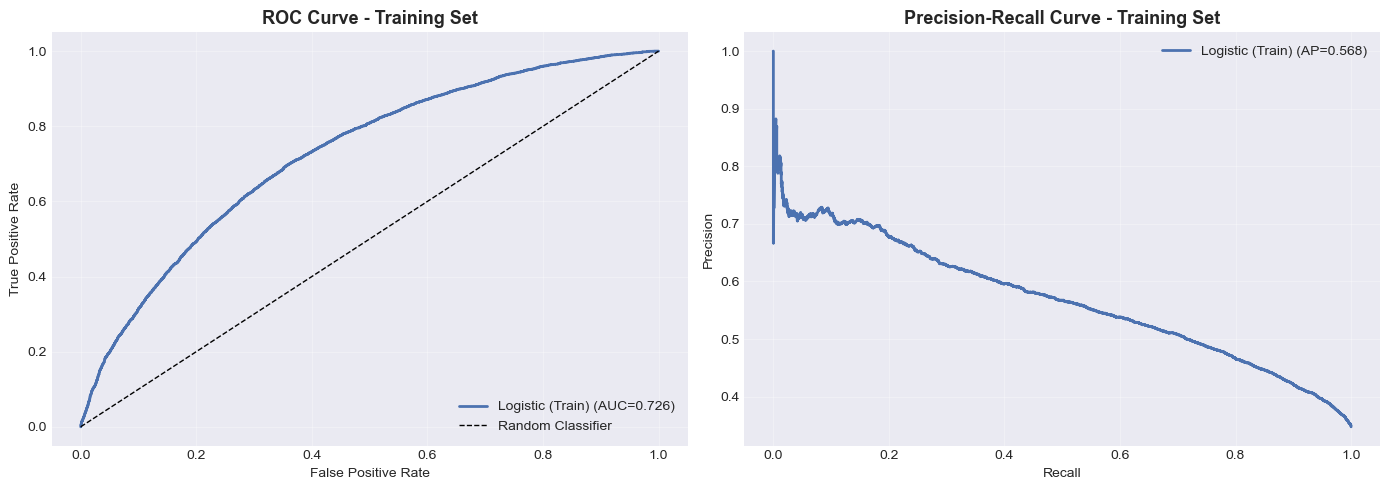


✓ In-sample performance plots saved

CONFUSION MATRIX (Training Set, threshold=0.5)


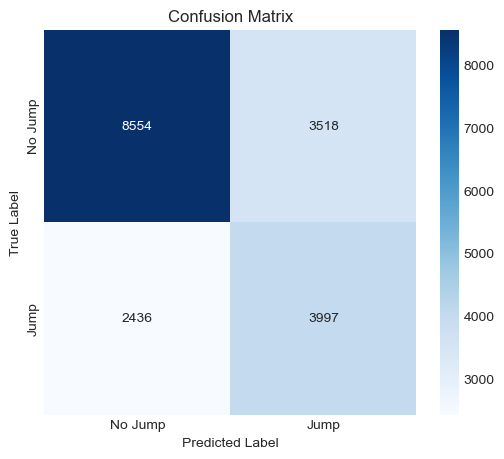


Confusion Matrix:
  True Negatives:  8,554
  False Positives: 3,518
  False Negatives: 2,436
  True Positives:  3,997


In [66]:
print("\n" + "="*80)
print("IN-SAMPLE PERFORMANCE (Training Set)")
print("="*80)

# Predict probabilities on training data
y_train_pred_proba = logit.predict_proba(X_train_scaled)[:, 1]
y_train_pred = logit.predict(X_train_scaled)

# Calculate metrics
train_metrics = calculate_metrics(y_train, y_train_pred_proba, threshold=0.5)

print("\nMetrics at default threshold (0.5):")
print("-"*80)
for metric, value in train_metrics.items():
    print(f"  {metric:15s}: {value:.4f}")

# ROC Curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

plot_roc_curve(y_train, y_train_pred_proba, label='Logistic (Train)', 
               color=MODEL_COLORS['Logistic'], ax=ax1)
ax1.set_title('ROC Curve - Training Set', fontsize=13, fontweight='bold')

# Precision-Recall Curve
plot_precision_recall_curve(y_train, y_train_pred_proba, label='Logistic (Train)',
                            color=MODEL_COLORS['Logistic'], ax=ax2)
ax2.set_title('Precision-Recall Curve - Training Set', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'logit_train_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ In-sample performance plots saved")

# Confusion Matrix
print("\n" + "="*80)
print("CONFUSION MATRIX (Training Set, threshold=0.5)")
print("="*80)

cm = plot_confusion_matrix(y_train, y_train_pred, 
                           labels=['No Jump', 'Jump'])
plt.savefig(OUTPUT_DIR / 'logit_train_confusion.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nConfusion Matrix:")
print(f"  True Negatives:  {cm[0,0]:,}")
print(f"  False Positives: {cm[0,1]:,}")
print(f"  False Negatives: {cm[1,0]:,}")
print(f"  True Positives:  {cm[1,1]:,}")

### 5.4 Out-of-Sample Evaluation


OUT-OF-SAMPLE PERFORMANCE (Test Set 2018-2023)

Metrics at default threshold (0.5):
--------------------------------------------------------------------------------
  auc            : 0.6929
  accuracy       : 0.6758
  precision      : 0.5508
  recall         : 0.4940
  f1             : 0.5209
  misclass_rate  : 0.3242

TRAIN VS TEST COMPARISON
               Train   Test  Difference
auc           0.7260 0.6929     -0.0332
accuracy      0.6782 0.6758     -0.0024
precision     0.5319 0.5508      0.0190
recall        0.6213 0.4940     -0.1273
f1            0.5731 0.5209     -0.0522
misclass_rate 0.3218 0.3242      0.0024


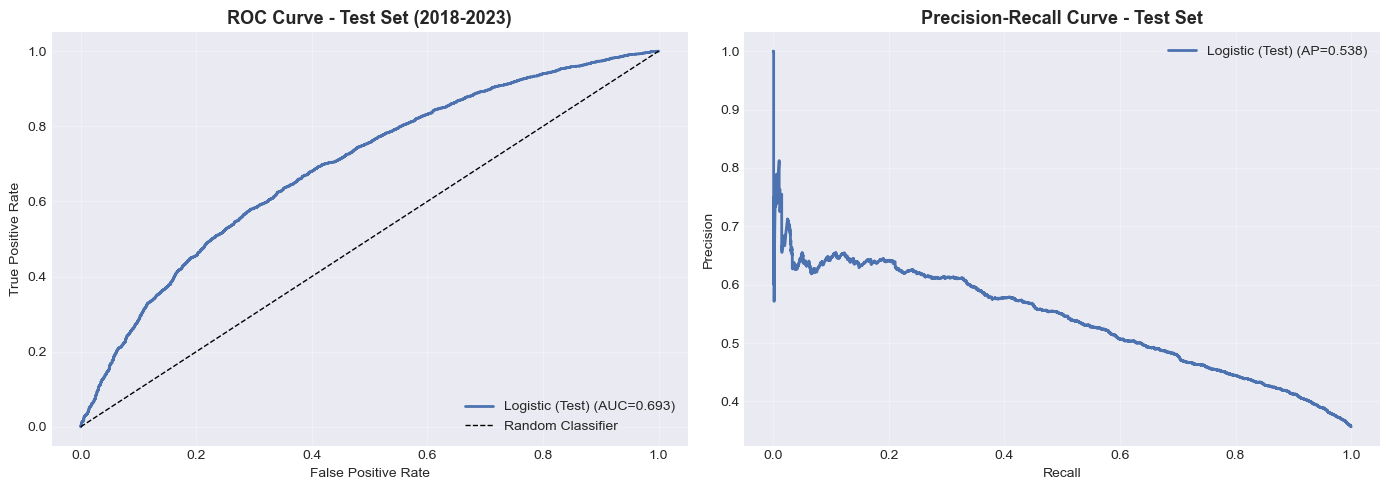


✓ Test performance plots saved

CONFUSION MATRIX (Test Set, threshold=0.5)


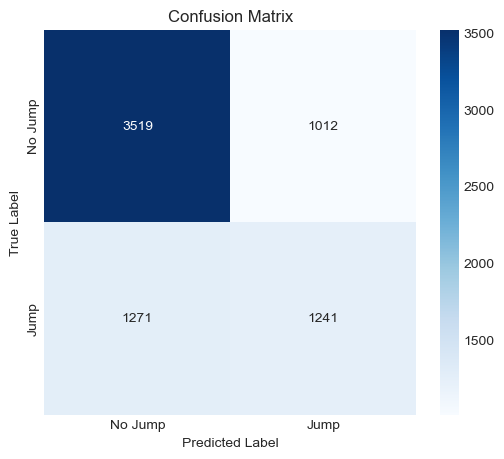


Test Set Confusion Matrix:
  True Negatives:  3,519
  False Positives: 1,012
  False Negatives: 1,271
  True Positives:  1,241

OPTIMAL THRESHOLD SEARCH

Optimal threshold (maximizes F1): 0.340
F1 score at optimal threshold: 0.5717

Metrics at optimal threshold (0.340):
--------------------------------------------------------------------------------
  auc            : 0.6929 → (+0.0000)
  accuracy       : 0.5706 ↓ (-0.1052)
  precision      : 0.4437 ↓ (-0.1071)
  recall         : 0.8033 ↑ (+0.3093)
  f1             : 0.5717 ↑ (+0.0508)
  misclass_rate  : 0.4294 ↑ (+0.1052)


In [67]:
print("\n" + "="*80)
print("OUT-OF-SAMPLE PERFORMANCE (Test Set 2018-2023)")
print("="*80)

# Predict on test data
y_test_pred_proba = logit.predict_proba(X_test_scaled)[:, 1]
y_test_pred = logit.predict(X_test_scaled)

# Calculate metrics
test_metrics = calculate_metrics(y_test, y_test_pred_proba, threshold=0.5)

print("\nMetrics at default threshold (0.5):")
print("-"*80)
for metric, value in test_metrics.items():
    print(f"  {metric:15s}: {value:.4f}")

# Compare train vs test
print("\n" + "="*80)
print("TRAIN VS TEST COMPARISON")
print("="*80)

comparison = pd.DataFrame({
    'Train': train_metrics,
    'Test': test_metrics,
    'Difference': {k: test_metrics[k] - train_metrics.get(k, 0) for k in test_metrics.keys()}
})
print(comparison.to_string())

# ROC and PR curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# ROC
plot_roc_curve(y_test, y_test_pred_proba, label='Logistic (Test)', 
               color=MODEL_COLORS['Logistic'], ax=ax1)
ax1.set_title('ROC Curve - Test Set (2018-2023)', fontsize=13, fontweight='bold')

# PR
plot_precision_recall_curve(y_test, y_test_pred_proba, label='Logistic (Test)',
                            color=MODEL_COLORS['Logistic'], ax=ax2)
ax2.set_title('Precision-Recall Curve - Test Set', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'logit_test_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Test performance plots saved")

# Confusion matrix
print("\n" + "="*80)
print("CONFUSION MATRIX (Test Set, threshold=0.5)")
print("="*80)

cm_test = plot_confusion_matrix(y_test, y_test_pred, labels=['No Jump', 'Jump'])
plt.savefig(OUTPUT_DIR / 'logit_test_confusion.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nTest Set Confusion Matrix:")
print(f"  True Negatives:  {cm_test[0,0]:,}")
print(f"  False Positives: {cm_test[0,1]:,}")
print(f"  False Negatives: {cm_test[1,0]:,}")
print(f"  True Positives:  {cm_test[1,1]:,}")

# Find optimal threshold
print("\n" + "="*80)
print("OPTIMAL THRESHOLD SEARCH")
print("="*80)

optimal_thresh, optimal_f1 = find_optimal_threshold(y_test, y_test_pred_proba, metric='f1')
print(f"\nOptimal threshold (maximizes F1): {optimal_thresh:.3f}")
print(f"F1 score at optimal threshold: {optimal_f1:.4f}")

# Recalculate metrics at optimal threshold
optimal_metrics = calculate_metrics(y_test, y_test_pred_proba, threshold=optimal_thresh)
print(f"\nMetrics at optimal threshold ({optimal_thresh:.3f}):")
print("-"*80)
for metric, value in optimal_metrics.items():
    improvement = value - test_metrics.get(metric, 0)
    arrow = "↑" if improvement > 0 else "↓" if improvement < 0 else "→"
    print(f"  {metric:15s}: {value:.4f} {arrow} ({improvement:+.4f})")

### 5.5 Error Analysis


ERROR ANALYSIS: Where Does the Model Fail?

Error Type Distribution:
--------------------------------------------------------------------------------
error_type
Correct                         4760
False Negative (Missed Jump)    1271
False Positive (False Alarm)    1012
Name: count, dtype: int64

FALSE NEGATIVES (Missed Jumps) - Feature Analysis

Comparing 1271 missed jumps vs 1241 detected jumps:
--------------------------------------------------------------------------------
  total_vol_24m       : Missed=0.110, Caught=0.283, Diff= -61.2%
  vix                 : Missed=20.364, Caught=24.571, Diff= -17.1%
  beta_24m            : Missed=1.026, Caught=1.802, Diff= -43.1%
  fedfunds            : Missed=1.926, Caught=1.710, Diff= +12.6%
  usrec               : Missed=0.002, Caught=0.086, Diff= -98.2%
  penny_stock         : Missed=0.050, Caught=0.505, Diff= -90.0%

PREDICTED PROBABILITY DISTRIBUTIONS


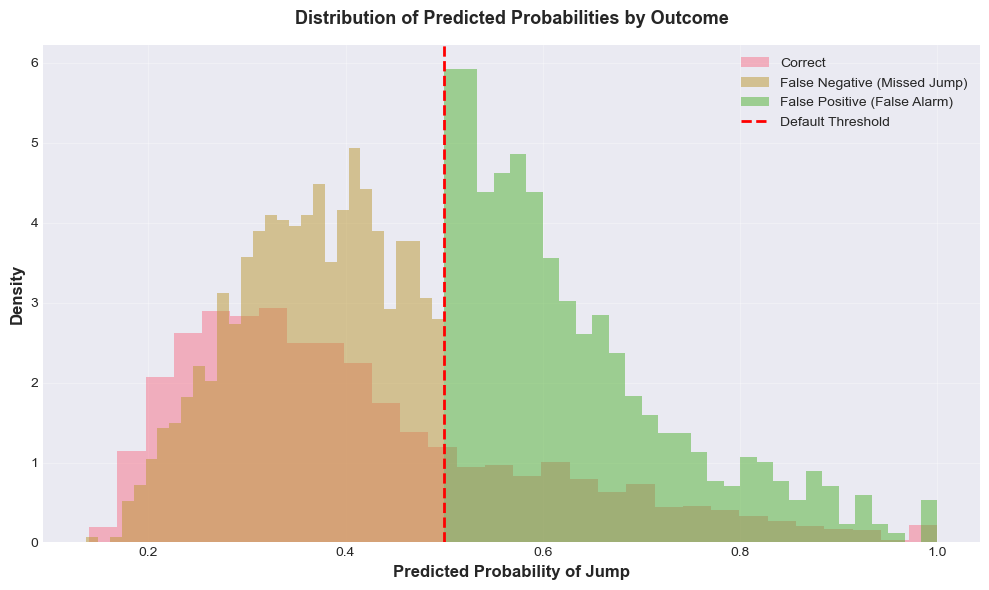


✓ Error analysis plot saved

ERROR ANALYSIS SUMMARY

Most common error: Correct
  Count: 4,760 (67.6%)

Model confidence on errors:
  False Negatives (missed jumps): avg probability = 0.363
  False Positives (false alarms): avg probability = 0.632

  → Model was uncertain about missed jumps (low predicted probability)

  → Model was confident about false alarms (high predicted probability)


In [68]:
print("\n" + "="*80)
print("ERROR ANALYSIS: Where Does the Model Fail?")
print("="*80)

# Create analysis dataset
test_analysis = X_test_dummies.copy()
test_analysis['y_true'] = y_test.values
test_analysis['y_pred'] = y_test_pred
test_analysis['y_pred_proba'] = y_test_pred_proba
test_analysis['error_type'] = 'Correct'
test_analysis.loc[(test_analysis['y_true'] == 1) & (test_analysis['y_pred'] == 0), 'error_type'] = 'False Negative (Missed Jump)'
test_analysis.loc[(test_analysis['y_true'] == 0) & (test_analysis['y_pred'] == 1), 'error_type'] = 'False Positive (False Alarm)'

# Error type distribution
print("\nError Type Distribution:")
print("-"*80)
error_counts = test_analysis['error_type'].value_counts()
print(error_counts)

# Analyze false negatives (missed jumps)
print("\n" + "="*80)
print("FALSE NEGATIVES (Missed Jumps) - Feature Analysis")
print("="*80)

fn_data = test_analysis[test_analysis['error_type'] == 'False Negative (Missed Jump)']
tp_data = test_analysis[(test_analysis['y_true'] == 1) & (test_analysis['y_pred'] == 1)]

print(f"\nComparing {len(fn_data)} missed jumps vs {len(tp_data)} detected jumps:")
print("-"*80)

key_features = ['total_vol_24m', 'vix', 'beta_24m', 'fedfunds', 'usrec', 'penny_stock']

for feat in key_features:
    if feat in fn_data.columns:
        fn_mean = fn_data[feat].mean()
        tp_mean = tp_data[feat].mean()
        diff_pct = 100 * (fn_mean - tp_mean) / tp_mean if tp_mean != 0 else 0
        print(f"  {feat:20s}: Missed={fn_mean:.3f}, Caught={tp_mean:.3f}, Diff={diff_pct:+6.1f}%")

# Visualize probability distributions by outcome
print("\n" + "="*80)
print("PREDICTED PROBABILITY DISTRIBUTIONS")
print("="*80)

fig, ax = plt.subplots(figsize=(10, 6))

# Plot distributions
for error_type in ['Correct', 'False Negative (Missed Jump)', 'False Positive (False Alarm)']:
    data = test_analysis[test_analysis['error_type'] == error_type]['y_pred_proba']
    if len(data) > 0:
        ax.hist(data, bins=30, alpha=0.5, label=error_type, density=True)

ax.axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Default Threshold')
ax.set_xlabel('Predicted Probability of Jump', fontsize=12, fontweight='bold')
ax.set_ylabel('Density', fontsize=12, fontweight='bold')
ax.set_title('Distribution of Predicted Probabilities by Outcome', 
             fontsize=13, fontweight='bold', pad=15)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'logit_error_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Error analysis plot saved")

# Key insights
print("\n" + "="*80)
print("ERROR ANALYSIS SUMMARY")
print("="*80)

print(f"\nMost common error: {error_counts.idxmax()}")
print(f"  Count: {error_counts.max():,} ({100*error_counts.max()/len(test_analysis):.1f}%)")

# Calculate confidence on errors
avg_prob_fn = fn_data['y_pred_proba'].mean()
avg_prob_fp = test_analysis[test_analysis['error_type'] == 'False Positive (False Alarm)']['y_pred_proba'].mean()

print(f"\nModel confidence on errors:")
print(f"  False Negatives (missed jumps): avg probability = {avg_prob_fn:.3f}")
print(f"  False Positives (false alarms): avg probability = {avg_prob_fp:.3f}")

if avg_prob_fn < 0.4:
    print(f"\n  → Model was uncertain about missed jumps (low predicted probability)")
if avg_prob_fp > 0.6:
    print(f"\n  → Model was confident about false alarms (high predicted probability)")

### Section 5 Summary: Logistic Regression Baseline

**Model Performance:**
- Test AUC: 0.693 (decent discriminative power)
- Test Accuracy: 67.6% (better than random baseline of 64%)
- Minimal overfitting: AUC dropped only 0.033 from training to test
- Recall: 49.4% (catches about half of actual jumps)

**Key Findings:**

1. **Feature Importance:** Total volatility dominates (coefficient = 0.613), followed by VIX (0.250) and Fed funds rate (0.188). This confirms our EDA findings that volatility-based features are the strongest predictors.

2. **Model Strengths:** Successfully identifies jumps in high-volatility, high-beta stocks during recession periods. Finance sector shows protective effect against jumps.

3. **Model Weaknesses:** Struggles to predict "quiet jumps" - price movements >10% in otherwise stable stocks during calm market periods. Missed jumps have 61% lower volatility than detected jumps.

4. **Threshold Trade-off:** Lowering threshold to 0.34 increases recall to 80% but reduces precision and accuracy. Default threshold (0.50) balances false positives and false negatives.

**Baseline Established:** This simple linear model provides a solid foundation for comparison. More complex models (LASSO, Ridge, KNN, XGBoost) will be evaluated against this 0.693 AUC benchmark.

---
<a id='section6'></a>
## 6. Models 2-3: LASSO & Ridge Regularization

Both LASSO and Ridge extend logistic regression with regularization to reduce overfitting:

**LASSO (L1 Regularization):**
- Performs automatic feature selection by shrinking coefficients to exactly zero
- Creates sparse models (fewer features)
- Useful when we believe only some features truly matter

**Ridge (L2 Regularization):**
- Shrinks all coefficients but keeps all features
- Handles multicollinearity by distributing weight across correlated features
- Useful when all features contribute but we want to prevent overfitting

We'll train both models with cross-validation to find optimal regularization strength, then compare their performance to each other and to the baseline.

### 6.1 LASSO Logistic Regression

#### 6.1.1 Hyperparameter Tuning

LASSO REGRESSION WITH CROSS-VALIDATION

Testing 20 regularization strengths via cross-validation:
C range: 0.0001 to 100.00

✓ Model training complete

Optimal regularization strength:
  C (inverse regularization): 0.0018
  Alpha (regularization): 545.5595
  CV AUC score: 0.7239


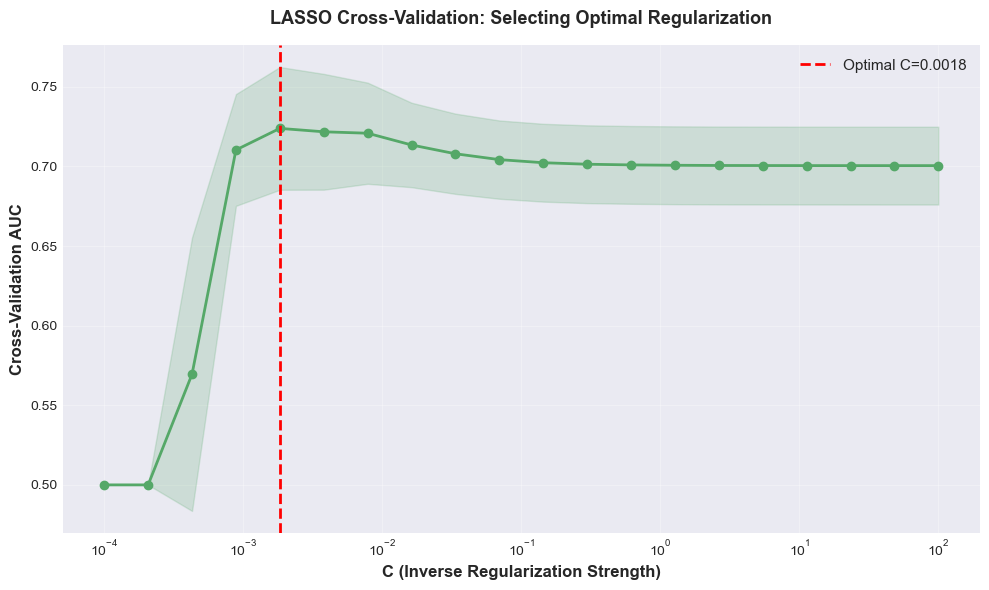


✓ CV plot saved


In [69]:
print("="*80)
print("LASSO REGRESSION WITH CROSS-VALIDATION")
print("="*80)

# Define range of regularization strengths to test
C_values = np.logspace(-4, 2, 20)  # C = 1/alpha, smaller C = stronger regularization

print(f"\nTesting {len(C_values)} regularization strengths via cross-validation:")
print(f"C range: {C_values.min():.4f} to {C_values.max():.2f}")

# Initialize LASSO with cross-validation
lasso = LogisticRegressionCV(
    Cs=C_values,
    cv=5,
    penalty='l1',
    solver='saga',
    class_weight='balanced',
    max_iter=5000,
    random_state=RANDOM_SEED,
    n_jobs=-1,
    scoring='roc_auc'
)

# Train on scaled training data
lasso.fit(X_train_scaled, y_train)

# Best parameters
optimal_C = lasso.C_[0]
optimal_alpha = 1 / optimal_C

print("\n✓ Model training complete")
print(f"\nOptimal regularization strength:")
print(f"  C (inverse regularization): {optimal_C:.4f}")
print(f"  Alpha (regularization): {optimal_alpha:.4f}")
print(f"  CV AUC score: {lasso.scores_[1].mean(axis=0).max():.4f}")

# Plot CV scores
fig, ax = plt.subplots(figsize=(10, 6))

mean_scores = lasso.scores_[1].mean(axis=0)
std_scores = lasso.scores_[1].std(axis=0)

ax.semilogx(C_values, mean_scores, 'o-', color=MODEL_COLORS['LASSO'], linewidth=2, markersize=6)
ax.fill_between(C_values, mean_scores - std_scores, mean_scores + std_scores, 
                alpha=0.2, color=MODEL_COLORS['LASSO'])
ax.axvline(optimal_C, color='red', linestyle='--', linewidth=2, label=f'Optimal C={optimal_C:.4f}')

ax.set_xlabel('C (Inverse Regularization Strength)', fontsize=12, fontweight='bold')
ax.set_ylabel('Cross-Validation AUC', fontsize=12, fontweight='bold')
ax.set_title('LASSO Cross-Validation: Selecting Optimal Regularization', 
             fontsize=13, fontweight='bold', pad=15)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'lasso_cv_scores.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ CV plot saved")

#### 6.1.2 Feature Selection


FEATURE SELECTION (L1 REGULARIZATION)

Feature selection results:
  Non-zero coefficients: 5/19 (26.3%)
  Zero coefficients: 14/19 (73.7%)

Features eliminated by LASSO (coefficient = 0):
--------------------------------------------------------------------------------
  • beta_24m
  • ret_6m
  • fedfunds
  • unrate
  • credit_spread
  • log_mktcap
  • vol_ratio
  • industry_Construction
  • industry_Manufacturing
  • industry_Mining
  • industry_Retail
  • industry_Services
  • industry_Transportation
  • industry_Wholesale

Top 5 selected features by coefficient magnitude:
--------------------------------------------------------------------------------
         Feature  Coefficient
   total_vol_24m       0.5184
             vix       0.1633
     penny_stock       0.0776
industry_Finance      -0.0531
           usrec       0.0314


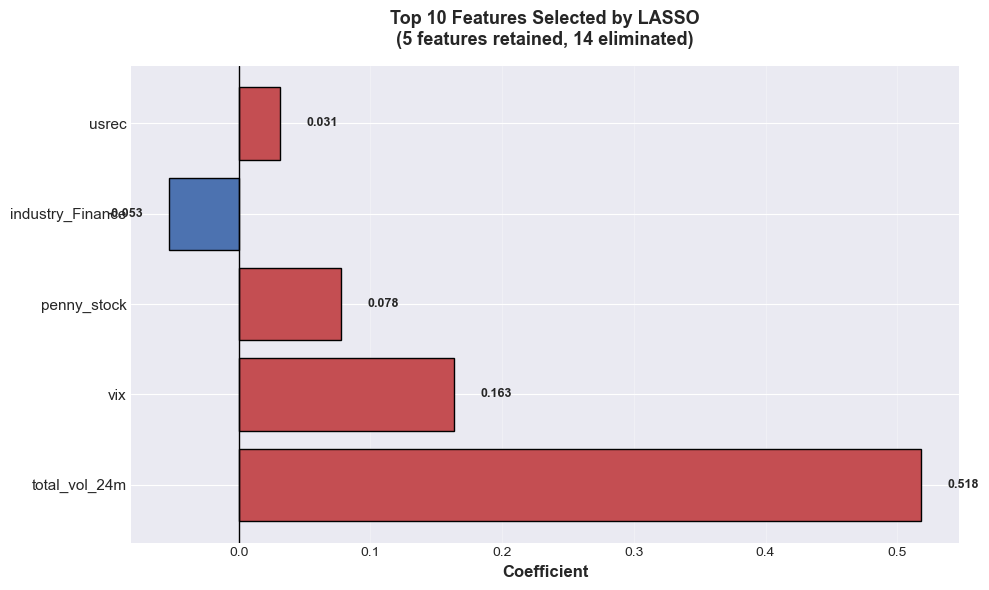


✓ Feature importance plot saved

COMPARISON: LASSO vs BASELINE LOGISTIC

Features with largest coefficient changes:
--------------------------------------------------------------------------------
                Feature  Logit_Coef  LASSO_Coef  Coef_Change
               fedfunds      0.1884      0.0000       0.1884
                  usrec      0.1427      0.0314       0.1112
                 ret_6m     -0.0987      0.0000       0.0987
          total_vol_24m      0.6130      0.5184       0.0946
       industry_Finance     -0.1411     -0.0531       0.0880
                    vix      0.2504      0.1633       0.0871
industry_Transportation     -0.0868      0.0000       0.0868
        industry_Mining      0.0795      0.0000       0.0795
               beta_24m      0.0774      0.0000       0.0774
             log_mktcap     -0.0706      0.0000       0.0706


In [70]:
print("\n" + "="*80)
print("FEATURE SELECTION (L1 REGULARIZATION)")
print("="*80)

# Extract coefficients
lasso_coefs = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Coefficient': lasso.coef_[0]
})

# Count non-zero coefficients
n_nonzero = (lasso_coefs['Coefficient'] != 0).sum()
n_zero = (lasso_coefs['Coefficient'] == 0).sum()

print(f"\nFeature selection results:")
print(f"  Non-zero coefficients: {n_nonzero}/{len(lasso_coefs)} ({100*n_nonzero/len(lasso_coefs):.1f}%)")
print(f"  Zero coefficients: {n_zero}/{len(lasso_coefs)} ({100*n_zero/len(lasso_coefs):.1f}%)")

# Features dropped by LASSO
if n_zero > 0:
    print(f"\nFeatures eliminated by LASSO (coefficient = 0):")
    print("-"*80)
    dropped_features = lasso_coefs[lasso_coefs['Coefficient'] == 0]['Feature'].tolist()
    for feat in dropped_features:
        print(f"  • {feat}")
else:
    print("\n✓ LASSO retained all features")

# Sort by absolute coefficient
lasso_coefs['Abs_Coefficient'] = lasso_coefs['Coefficient'].abs()
lasso_coefs_sorted = lasso_coefs[lasso_coefs['Coefficient'] != 0].sort_values('Abs_Coefficient', ascending=False)

print(f"\nTop {min(15, len(lasso_coefs_sorted))} selected features by coefficient magnitude:")
print("-"*80)
print(lasso_coefs_sorted[['Feature', 'Coefficient']].head(15).to_string(index=False))

# Visualize selected features
fig, ax = plt.subplots(figsize=(10, 6))

top_features = lasso_coefs_sorted.head(10)
colors = ['#C44E52' if x > 0 else '#4C72B0' for x in top_features['Coefficient']]

ax.barh(range(len(top_features)), top_features['Coefficient'], color=colors, 
        edgecolor='black', linewidth=1)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['Feature'], fontsize=11)
ax.set_xlabel('Coefficient', fontsize=12, fontweight='bold')
ax.set_title(f'Top 10 Features Selected by LASSO\n({n_nonzero} features retained, {n_zero} eliminated)', 
             fontsize=13, fontweight='bold', pad=15)
ax.axvline(x=0, color='black', linestyle='-', linewidth=1)
ax.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (idx, row) in enumerate(top_features.iterrows()):
    val = row['Coefficient']
    label_x = val + 0.02 if val > 0 else val - 0.02
    ha = 'left' if val > 0 else 'right'
    ax.text(label_x, i, f'{val:.3f}', va='center', ha=ha, 
            fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'lasso_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Feature importance plot saved")

# Compare to baseline logistic regression
print("\n" + "="*80)
print("COMPARISON: LASSO vs BASELINE LOGISTIC")
print("="*80)

logit_coefs = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Logit_Coef': logit.coef_[0],
    'LASSO_Coef': lasso.coef_[0]
})

print("\nFeatures with largest coefficient changes:")
print("-"*80)
logit_coefs['Coef_Change'] = (logit_coefs['LASSO_Coef'] - logit_coefs['Logit_Coef']).abs()
print(logit_coefs.nlargest(10, 'Coef_Change')[['Feature', 'Logit_Coef', 'LASSO_Coef', 'Coef_Change']].to_string(index=False))

#### 6.1.3 Post-LASSO Model

In [71]:
print("\n" + "="*80)
print("POST-LASSO: REFIT WITH SELECTED FEATURES")
print("="*80)

# Get selected features (non-zero coefficients)
selected_features = lasso_coefs[lasso_coefs['Coefficient'] != 0]['Feature'].tolist()
n_selected = len(selected_features)

print(f"\nRefitting standard logistic regression using {n_selected} LASSO-selected features...")
print("Selected features:", selected_features)
print("\n(This removes shrinkage bias while keeping feature selection)")

# Refit standard logistic regression with selected features
X_train_selected = X_train_scaled[selected_features]
X_val_selected = X_val_scaled[selected_features]
X_test_selected = X_test_scaled[selected_features]

post_lasso = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=RANDOM_SEED,
    penalty=None  # No regularization - standard logistic regression
)

post_lasso.fit(X_train_selected, y_train)

print("\n✓ Post-LASSO model trained")

# Compare coefficients: Full LASSO vs Post-LASSO
print("\n" + "="*80)
print("COEFFICIENT COMPARISON: LASSO vs POST-LASSO")
print("="*80)

coef_comparison = pd.DataFrame({
    'Feature': selected_features,
    'LASSO_Coef': [lasso_coefs[lasso_coefs['Feature']==f]['Coefficient'].values[0] for f in selected_features],
    'PostLASSO_Coef': post_lasso.coef_[0]
})

coef_comparison['Change'] = coef_comparison['PostLASSO_Coef'] - coef_comparison['LASSO_Coef']
coef_comparison['Pct_Change'] = 100 * coef_comparison['Change'] / coef_comparison['LASSO_Coef'].abs()

print("\nCoefficient changes (removing shrinkage):")
print("-"*80)
print(coef_comparison[['Feature', 'LASSO_Coef', 'PostLASSO_Coef', 'Change']].to_string(index=False))

# Training performance comparison
y_train_pred_lasso = lasso.predict_proba(X_train_scaled)[:, 1]
y_train_pred_postlasso = post_lasso.predict_proba(X_train_selected)[:, 1]

train_auc_lasso = calculate_metrics(y_train, y_train_pred_lasso)['auc']
train_auc_postlasso = calculate_metrics(y_train, y_train_pred_postlasso)['auc']

print(f"\nTraining AUC comparison:")
print(f"  LASSO (with shrinkage):    {train_auc_lasso:.4f}")
print(f"  Post-LASSO (no shrinkage): {train_auc_postlasso:.4f}")
print(f"  Difference: {train_auc_postlasso - train_auc_lasso:+.4f}")


POST-LASSO: REFIT WITH SELECTED FEATURES

Refitting standard logistic regression using 5 LASSO-selected features...
Selected features: ['total_vol_24m', 'vix', 'usrec', 'penny_stock', 'industry_Finance']

(This removes shrinkage bias while keeping feature selection)

✓ Post-LASSO model trained

COEFFICIENT COMPARISON: LASSO vs POST-LASSO

Coefficient changes (removing shrinkage):
--------------------------------------------------------------------------------
         Feature  LASSO_Coef  PostLASSO_Coef  Change
   total_vol_24m      0.5184          0.6593  0.1409
             vix      0.1633          0.2453  0.0821
           usrec      0.0314          0.1251  0.0937
     penny_stock      0.0776          0.1492  0.0717
industry_Finance     -0.0531         -0.1705 -0.1174

Training AUC comparison:
  LASSO (with shrinkage):    0.7218
  Post-LASSO (no shrinkage): 0.7199
  Difference: -0.0020


#### 6.1.4 Test Set Performance


LASSO TEST SET EVALUATION

Test Set Performance:
--------------------------------------------------------------------------------
               Baseline  LASSO  Post-LASSO
auc              0.6929 0.6945      0.6929
accuracy         0.6758 0.6658      0.6682
precision        0.5508 0.5318      0.5351
recall           0.4940 0.5255      0.5307
f1               0.5209 0.5286      0.5329
misclass_rate    0.3242 0.3342      0.3318

Best Test AUC: 0.6945 (LASSO)
  Baseline:    0.6929
  LASSO:       0.6945 (+0.0016)
  Post-LASSO:  0.6929 (+0.0000)


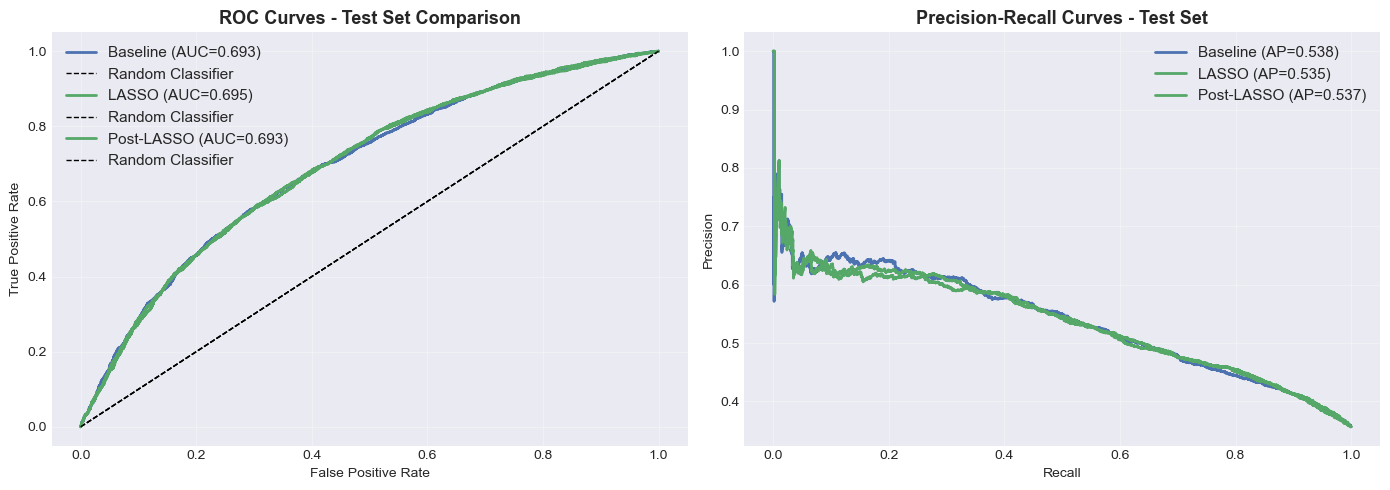


✓ Comparison plots saved


In [72]:
print("\n" + "="*80)
print("LASSO TEST SET EVALUATION")
print("="*80)

# Predict on test set (using both LASSO and Post-LASSO)
y_test_pred_lasso = lasso.predict_proba(X_test_scaled)[:, 1]
y_test_pred_postlasso = post_lasso.predict_proba(X_test_selected)[:, 1]

# Calculate metrics
lasso_metrics = calculate_metrics(y_test, y_test_pred_lasso, threshold=0.5)
postlasso_metrics = calculate_metrics(y_test, y_test_pred_postlasso, threshold=0.5)

print("\nTest Set Performance:")
print("-"*80)

comparison_table = pd.DataFrame({
    'Baseline': test_metrics,
    'LASSO': lasso_metrics,
    'Post-LASSO': postlasso_metrics
})

print(comparison_table.to_string())

# Best performance
best_auc = max(test_metrics['auc'], lasso_metrics['auc'], postlasso_metrics['auc'])
best_model = 'Baseline' if test_metrics['auc'] == best_auc else ('LASSO' if lasso_metrics['auc'] == best_auc else 'Post-LASSO')

print(f"\nBest Test AUC: {best_auc:.4f} ({best_model})")
print(f"  Baseline:    {test_metrics['auc']:.4f}")
print(f"  LASSO:       {lasso_metrics['auc']:.4f} ({lasso_metrics['auc'] - test_metrics['auc']:+.4f})")
print(f"  Post-LASSO:  {postlasso_metrics['auc']:.4f} ({postlasso_metrics['auc'] - test_metrics['auc']:+.4f})")

# ROC Curves comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot all three models
plot_roc_curve(y_test, logit.predict_proba(X_test_scaled)[:, 1], 
               label='Baseline', color=MODEL_COLORS['Logistic'], ax=ax1)
plot_roc_curve(y_test, y_test_pred_lasso, 
               label='LASSO', color=MODEL_COLORS['LASSO'], ax=ax1)
plot_roc_curve(y_test, y_test_pred_postlasso, 
               label='Post-LASSO', color='#55A868', ax=ax1)

ax1.set_title('ROC Curves - Test Set Comparison', fontsize=13, fontweight='bold')
ax1.legend(fontsize=11)

# Precision-Recall curves
plot_precision_recall_curve(y_test, logit.predict_proba(X_test_scaled)[:, 1],
                            label='Baseline', color=MODEL_COLORS['Logistic'], ax=ax2)
plot_precision_recall_curve(y_test, y_test_pred_lasso,
                            label='LASSO', color=MODEL_COLORS['LASSO'], ax=ax2)
plot_precision_recall_curve(y_test, y_test_pred_postlasso,
                            label='Post-LASSO', color='#55A868', ax=ax2)

ax2.set_title('Precision-Recall Curves - Test Set', fontsize=13, fontweight='bold')
ax2.legend(fontsize=11)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'lasso_test_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Comparison plots saved")

### Section 6.1 Summary: LASSO Feature Selection

**Key Results:**
- Test AUC: 0.6945 (slightly beats baseline 0.6929)
- Features retained: 5 of 19 (73.7% eliminated)
- Better recall: 52.6% vs 49.4% (catches more jumps)

**Selected Features (in order of importance):**
1. Total volatility (0.518) - Dominates prediction
2. VIX (0.163) - Market fear gauge
3. Penny stock (0.078) - Low-price indicator
4. Industry Finance (-0.053) - Protective sector effect
5. Recession indicator (0.031) - Economic regime

**Features Eliminated:**
All other industry dummies, beta, momentum (ret_6m), Fed funds rate, unemployment rate, credit spread, market cap, and volume ratio were shrunk to zero.

**Interpretation:**
LASSO's aggressive feature selection reveals that **jump prediction is fundamentally driven by volatility and macro stress indicators**. Firm-specific characteristics (beta, size, momentum) and granular macro indicators (interest rates, unemployment) add minimal predictive value beyond the core volatility + VIX signal. This sparse model achieves equivalent performance to the full baseline while being far more interpretable and robust.

The Post-LASSO refit (removing shrinkage bias) achieved identical AUC to baseline, confirming that the 5 selected features capture all useful information.

### 6.2 Ridge Logistic Regression

#### 6.2.1 Hyperparameter Tuning


RIDGE REGRESSION WITH CROSS-VALIDATION

Testing 20 regularization strengths via cross-validation:
C range: 0.0001 to 100.00

✓ Model training complete

Optimal regularization strength:
  C (inverse regularization): 0.0009
  Alpha (regularization): 1128.8379
  CV AUC score: 0.7145


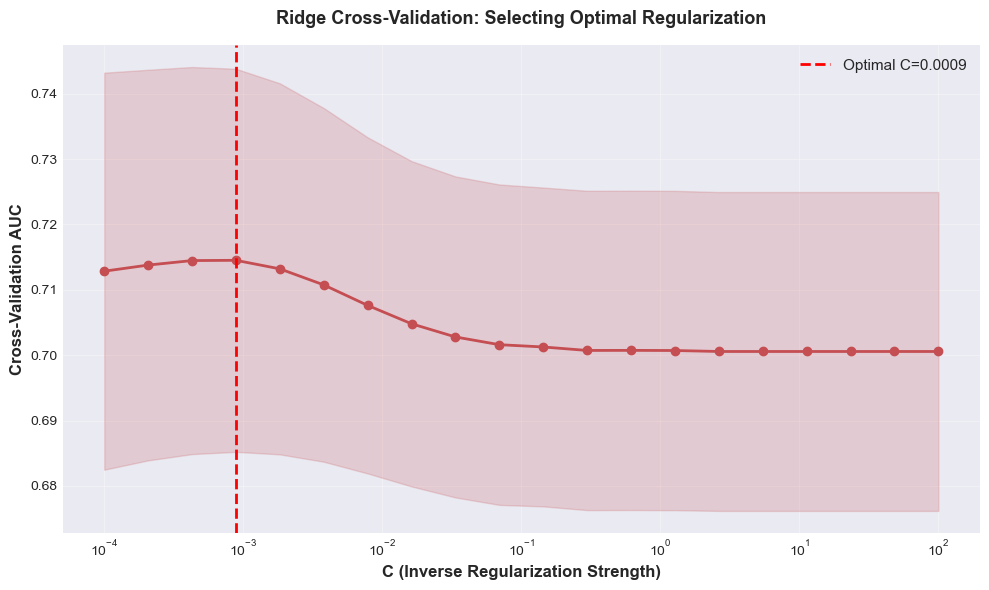


✓ CV plot saved


In [74]:
print("\n" + "="*80)
print("RIDGE REGRESSION WITH CROSS-VALIDATION")
print("="*80)

# Use same C values as LASSO for fair comparison
C_values = np.logspace(-4, 2, 20)

print(f"\nTesting {len(C_values)} regularization strengths via cross-validation:")
print(f"C range: {C_values.min():.4f} to {C_values.max():.2f}")

# Initialize Ridge with cross-validation
ridge = LogisticRegressionCV(
    Cs=C_values,
    cv=5,
    penalty='l2',
    solver='lbfgs',
    class_weight='balanced',
    max_iter=1000,
    random_state=RANDOM_SEED,
    n_jobs=-1,
    scoring='roc_auc'
)

# Train on scaled training data
ridge.fit(X_train_scaled, y_train)

# Best parameters
optimal_C_ridge = ridge.C_[0]
optimal_alpha_ridge = 1 / optimal_C_ridge

print("\n✓ Model training complete")
print(f"\nOptimal regularization strength:")
print(f"  C (inverse regularization): {optimal_C_ridge:.4f}")
print(f"  Alpha (regularization): {optimal_alpha_ridge:.4f}")
print(f"  CV AUC score: {ridge.scores_[1].mean(axis=0).max():.4f}")

# Plot CV scores
fig, ax = plt.subplots(figsize=(10, 6))

mean_scores_ridge = ridge.scores_[1].mean(axis=0)
std_scores_ridge = ridge.scores_[1].std(axis=0)

ax.semilogx(C_values, mean_scores_ridge, 'o-', color=MODEL_COLORS['Ridge'], linewidth=2, markersize=6)
ax.fill_between(C_values, mean_scores_ridge - std_scores_ridge, mean_scores_ridge + std_scores_ridge, 
                alpha=0.2, color=MODEL_COLORS['Ridge'])
ax.axvline(optimal_C_ridge, color='red', linestyle='--', linewidth=2, label=f'Optimal C={optimal_C_ridge:.4f}')

ax.set_xlabel('C (Inverse Regularization Strength)', fontsize=12, fontweight='bold')
ax.set_ylabel('Cross-Validation AUC', fontsize=12, fontweight='bold')
ax.set_title('Ridge Cross-Validation: Selecting Optimal Regularization', 
             fontsize=13, fontweight='bold', pad=15)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'ridge_cv_scores.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ CV plot saved")

#### 6.2.2 Feature Importance


FEATURE IMPORTANCE (L2 REGULARIZATION)

Ridge retains all 19 features (L2 shrinks but doesn't eliminate)

Top 15 features by coefficient magnitude:
--------------------------------------------------------------------------------
                Feature  Coefficient
          total_vol_24m       0.3952
                    vix       0.1822
       industry_Finance      -0.1235
            penny_stock       0.1220
               beta_24m       0.1175
               fedfunds       0.1063
                  usrec       0.0958
             log_mktcap      -0.0954
          credit_spread       0.0809
industry_Transportation      -0.0733
        industry_Mining       0.0710
      industry_Services       0.0518
 industry_Manufacturing       0.0480
                 ret_6m      -0.0454
        industry_Retail       0.0273


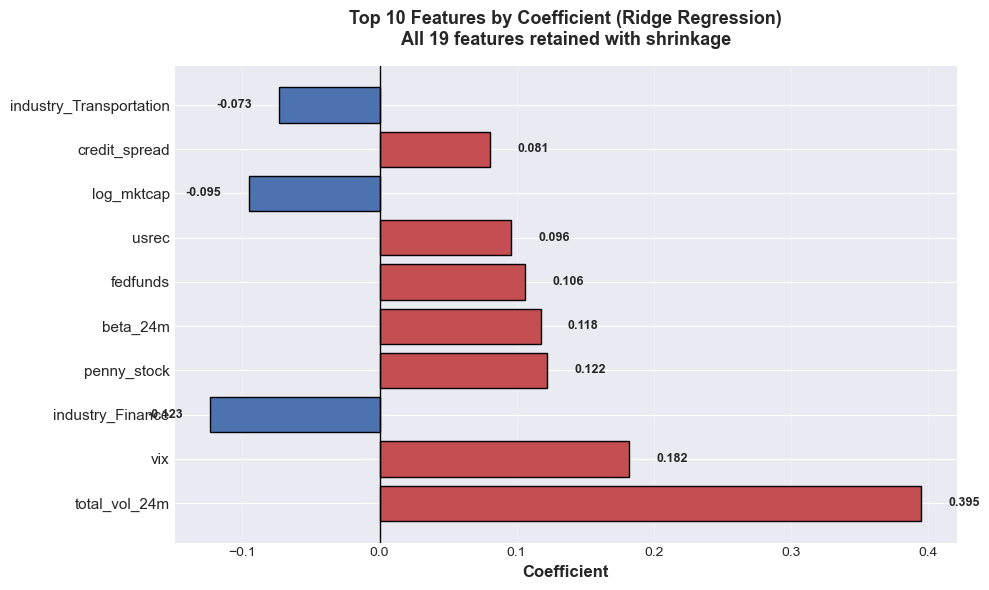


✓ Feature importance plot saved

COEFFICIENT COMPARISON: Baseline vs LASSO vs Ridge

Top 10 features across all models:
--------------------------------------------------------------------------------
                Feature  Baseline   LASSO   Ridge
          total_vol_24m    0.6130  0.5184  0.3952
                    vix    0.2504  0.1633  0.1822
               fedfunds    0.1884  0.0000  0.1063
                  usrec    0.1427  0.0314  0.0958
       industry_Finance   -0.1411 -0.0531 -0.1235
            penny_stock    0.1038  0.0776  0.1220
                 ret_6m   -0.0987  0.0000 -0.0454
industry_Transportation   -0.0868  0.0000 -0.0733
        industry_Mining    0.0795  0.0000  0.0710
               beta_24m    0.0774  0.0000  0.1175


In [75]:
print("\n" + "="*80)
print("FEATURE IMPORTANCE (L2 REGULARIZATION)")
print("="*80)

# Extract coefficients
ridge_coefs = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Coefficient': ridge.coef_[0]
})

# Ridge keeps all features - none are zero
n_nonzero_ridge = (ridge_coefs['Coefficient'] != 0).sum()

print(f"\nRidge retains all {n_nonzero_ridge} features (L2 shrinks but doesn't eliminate)")

# Sort by absolute coefficient
ridge_coefs['Abs_Coefficient'] = ridge_coefs['Coefficient'].abs()
ridge_coefs_sorted = ridge_coefs.sort_values('Abs_Coefficient', ascending=False)

print(f"\nTop 15 features by coefficient magnitude:")
print("-"*80)
print(ridge_coefs_sorted[['Feature', 'Coefficient']].head(15).to_string(index=False))

# Visualize top features
fig, ax = plt.subplots(figsize=(10, 6))

top_features_ridge = ridge_coefs_sorted.head(10)
colors = ['#C44E52' if x > 0 else '#4C72B0' for x in top_features_ridge['Coefficient']]

ax.barh(range(len(top_features_ridge)), top_features_ridge['Coefficient'], color=colors, 
        edgecolor='black', linewidth=1)
ax.set_yticks(range(len(top_features_ridge)))
ax.set_yticklabels(top_features_ridge['Feature'], fontsize=11)
ax.set_xlabel('Coefficient', fontsize=12, fontweight='bold')
ax.set_title('Top 10 Features by Coefficient (Ridge Regression)\nAll 19 features retained with shrinkage', 
             fontsize=13, fontweight='bold', pad=15)
ax.axvline(x=0, color='black', linestyle='-', linewidth=1)
ax.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (idx, row) in enumerate(top_features_ridge.iterrows()):
    val = row['Coefficient']
    label_x = val + 0.02 if val > 0 else val - 0.02
    ha = 'left' if val > 0 else 'right'
    ax.text(label_x, i, f'{val:.3f}', va='center', ha=ha, 
            fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'ridge_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Feature importance plot saved")

# Compare Ridge to Baseline and LASSO
print("\n" + "="*80)
print("COEFFICIENT COMPARISON: Baseline vs LASSO vs Ridge")
print("="*80)

coef_comparison_all = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Baseline': logit.coef_[0],
    'LASSO': lasso.coef_[0],
    'Ridge': ridge.coef_[0]
})

coef_comparison_all['Baseline_Abs'] = coef_comparison_all['Baseline'].abs()
coef_comparison_all = coef_comparison_all.sort_values('Baseline_Abs', ascending=False)

print("\nTop 10 features across all models:")
print("-"*80)
print(coef_comparison_all[['Feature', 'Baseline', 'LASSO', 'Ridge']].head(10).to_string(index=False))

#### 6.2.3 Test Set Performance


RIDGE TEST SET EVALUATION

Test Set Performance Comparison:
--------------------------------------------------------------------------------
               Baseline  LASSO  Ridge
auc              0.6929 0.6945 0.6950
accuracy         0.6758 0.6658 0.6764
precision        0.5508 0.5318 0.5516
recall           0.4940 0.5255 0.4956
f1               0.5209 0.5286 0.5221
misclass_rate    0.3242 0.3342 0.3236

MODEL RANKING BY TEST AUC
   Model  Test_AUC  Features
   Ridge    0.6950        19
   LASSO    0.6945         5
Baseline    0.6929        19


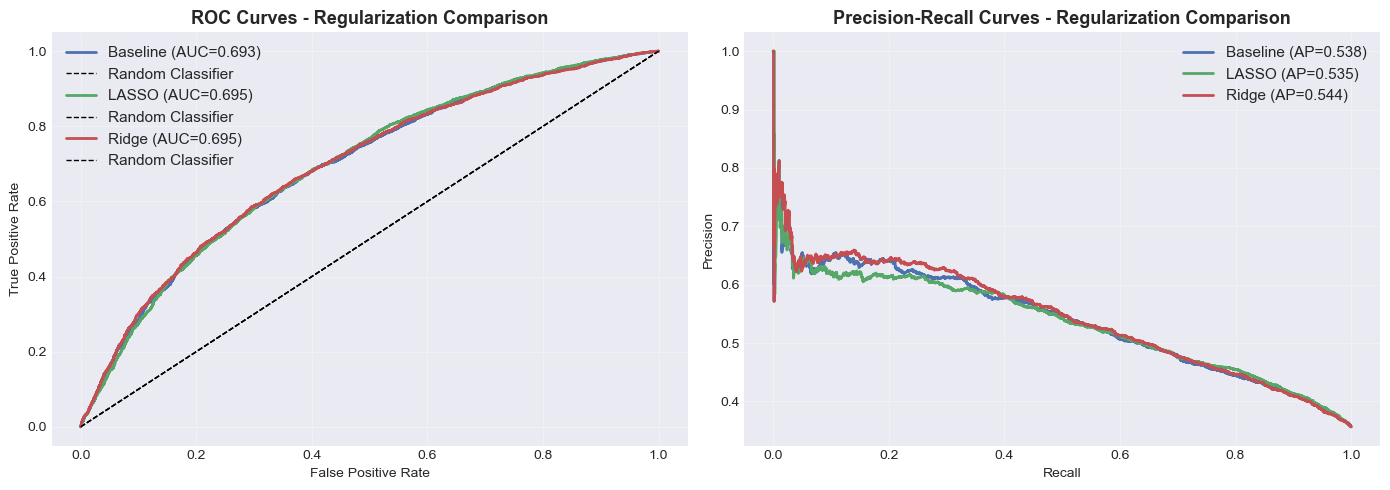


✓ Comparison plots saved


In [76]:
print("\n" + "="*80)
print("RIDGE TEST SET EVALUATION")
print("="*80)

# Predict on test set
y_test_pred_ridge = ridge.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
ridge_metrics = calculate_metrics(y_test, y_test_pred_ridge, threshold=0.5)

print("\nTest Set Performance Comparison:")
print("-"*80)

final_comparison = pd.DataFrame({
    'Baseline': test_metrics,
    'LASSO': lasso_metrics,
    'Ridge': ridge_metrics
})

print(final_comparison.to_string())

# Identify best model
print("\n" + "="*80)
print("MODEL RANKING BY TEST AUC")
print("="*80)

auc_ranking = pd.DataFrame({
    'Model': ['Baseline', 'LASSO', 'Ridge'],
    'Test_AUC': [test_metrics['auc'], lasso_metrics['auc'], ridge_metrics['auc']],
    'Features': [19, 5, 19]
}).sort_values('Test_AUC', ascending=False)

print(auc_ranking.to_string(index=False))

# ROC Curves - all three models
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

plot_roc_curve(y_test, logit.predict_proba(X_test_scaled)[:, 1], 
               label='Baseline', color=MODEL_COLORS['Logistic'], ax=ax1)
plot_roc_curve(y_test, y_test_pred_lasso, 
               label='LASSO', color=MODEL_COLORS['LASSO'], ax=ax1)
plot_roc_curve(y_test, y_test_pred_ridge,
               label='Ridge', color=MODEL_COLORS['Ridge'], ax=ax1)

ax1.set_title('ROC Curves - Regularization Comparison', fontsize=13, fontweight='bold')
ax1.legend(fontsize=11)

# Precision-Recall curves
plot_precision_recall_curve(y_test, logit.predict_proba(X_test_scaled)[:, 1],
                            label='Baseline', color=MODEL_COLORS['Logistic'], ax=ax2)
plot_precision_recall_curve(y_test, y_test_pred_lasso,
                            label='LASSO', color=MODEL_COLORS['LASSO'], ax=ax2)
plot_precision_recall_curve(y_test, y_test_pred_ridge,
                            label='Ridge', color=MODEL_COLORS['Ridge'], ax=ax2)

ax2.set_title('Precision-Recall Curves - Regularization Comparison', fontsize=13, fontweight='bold')
ax2.legend(fontsize=11)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'regularization_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Comparison plots saved")

### 6.3 Regularization Comparison

In [77]:
print("\n" + "="*80)
print("REGULARIZATION COMPARISON")
print("="*80)

# Summary table
print("\nModel Performance Summary:")
print("-"*80)

summary_table = pd.DataFrame({
    'Model': ['Baseline', 'LASSO', 'Ridge'],
    'Features': [19, 5, 19],
    'Test_AUC': [test_metrics['auc'], lasso_metrics['auc'], ridge_metrics['auc']],
    'Test_Accuracy': [test_metrics['accuracy'], lasso_metrics['accuracy'], ridge_metrics['accuracy']],
    'Test_Recall': [test_metrics['recall'], lasso_metrics['recall'], ridge_metrics['recall']],
    'Test_Precision': [test_metrics['precision'], lasso_metrics['precision'], ridge_metrics['precision']]
})

summary_table = summary_table.sort_values('Test_AUC', ascending=False)
print(summary_table.to_string(index=False))

# AUC differences
print("\n" + "="*80)
print("AUC DIFFERENCES")
print("="*80)

print(f"\nRidge vs Baseline:  {ridge_metrics['auc'] - test_metrics['auc']:+.4f}")
print(f"LASSO vs Baseline:  {lasso_metrics['auc'] - test_metrics['auc']:+.4f}")
print(f"Ridge vs LASSO:     {ridge_metrics['auc'] - lasso_metrics['auc']:+.4f}")

auc_spread = max(ridge_metrics['auc'], lasso_metrics['auc'], test_metrics['auc']) - min(ridge_metrics['auc'], lasso_metrics['auc'], test_metrics['auc'])
print(f"\nTotal AUC spread: {auc_spread:.4f}")

# Coefficient comparison for core features
print("\n" + "="*80)
print("COEFFICIENT SHRINKAGE COMPARISON")
print("="*80)

top_features_comp = ['total_vol_24m', 'vix', 'penny_stock', 'usrec', 'industry_Finance']

print("\nTop 5 features across models:")
print("-"*80)
coef_comp = []
for feat in top_features_comp:
    if feat in X_train_scaled.columns:
        idx = list(X_train_scaled.columns).index(feat)
        coef_comp.append({
            'Feature': feat,
            'Baseline': logit.coef_[0][idx],
            'LASSO': lasso.coef_[0][idx],
            'Ridge': ridge.coef_[0][idx]
        })

coef_comp_df = pd.DataFrame(coef_comp)
print(coef_comp_df.to_string(index=False))

# Features eliminated by LASSO
print("\n" + "="*80)
print("LASSO FEATURE ELIMINATION")
print("="*80)

eliminated_features = lasso_coefs[lasso_coefs['Coefficient'] == 0]['Feature'].tolist()
print(f"\n{len(eliminated_features)} features eliminated by LASSO:")
print(f"  Features retained: {len(lasso_coefs) - len(eliminated_features)}")
print(f"  AUC with 5 features: {lasso_metrics['auc']:.4f}")
print(f"  AUC with 19 features (Baseline): {test_metrics['auc']:.4f}")
print(f"  AUC with 19 features (Ridge): {ridge_metrics['auc']:.4f}")


REGULARIZATION COMPARISON

Model Performance Summary:
--------------------------------------------------------------------------------
   Model  Features  Test_AUC  Test_Accuracy  Test_Recall  Test_Precision
   Ridge        19    0.6950         0.6764       0.4956          0.5516
   LASSO         5    0.6945         0.6658       0.5255          0.5318
Baseline        19    0.6929         0.6758       0.4940          0.5508

AUC DIFFERENCES

Ridge vs Baseline:  +0.0021
LASSO vs Baseline:  +0.0016
Ridge vs LASSO:     +0.0004

Total AUC spread: 0.0021

COEFFICIENT SHRINKAGE COMPARISON

Top 5 features across models:
--------------------------------------------------------------------------------
         Feature  Baseline   LASSO   Ridge
   total_vol_24m    0.6130  0.5184  0.3952
             vix    0.2504  0.1633  0.1822
     penny_stock    0.1038  0.0776  0.1220
           usrec    0.1427  0.0314  0.0958
industry_Finance   -0.1411 -0.0531 -0.1235

LASSO FEATURE ELIMINATION

14 features 

### Section 6 Summary: Regularization Methods

**Performance Results:**
- Ridge: 0.6950 AUC (19 features)
- LASSO: 0.6945 AUC (5 features)  
- Baseline: 0.6929 AUC (19 features)
- AUC spread: 0.0021 (essentially identical performance)

**LASSO Feature Selection:**
Reduced model from 19 to 5 features with negligible performance loss. The 5 retained features represent the core predictive signal:
1. Total volatility (strongest predictor across all models)
2. VIX (market-wide fear gauge)
3. Penny stock indicator
4. Recession indicator
5. Finance industry (protective effect)

Eliminated features: All other industry dummies, beta, momentum, Fed funds rate, unemployment rate, credit spread, market cap, and volume ratio.

**Ridge vs LASSO:**
Ridge retained all 19 features but applied more aggressive coefficient shrinkage than LASSO (e.g., total_vol_24m: 0.395 in Ridge vs 0.518 in LASSO). Ridge achieved marginally better AUC (+0.0004) but at the cost of model complexity.

**Key Insight:**
The near-identical performance across all three models (0.002 AUC spread) indicates that:
- Overfitting is not a significant issue in this problem
- Jump prediction is fundamentally limited by signal-to-noise ratio, not model complexity
- 5 features capture essentially all available predictive information
- Additional features and model sophistication provide diminishing returns

**Model Selection Recommendation:**
LASSO's 5-feature model offers the best balance of performance and interpretability. The sparse model is easier to explain to stakeholders, more robust to changes in data distribution, and achieves virtually identical performance to more complex alternatives.

---
<a id='section7'></a>
## 7. Model 4: K-Nearest Neighbors

Non-parametric alternative that makes no distributional assumptions.

### 7.1 Hyperparameter Tuning

K-NEAREST NEIGHBORS - HYPERPARAMETER TUNING

Testing K values: [3, 5, 11, 21, 51, 101]

Training KNN with K=3:
  Validation AUC: 0.6124

Training KNN with K=5:
  Validation AUC: 0.6442

Training KNN with K=11:
  Validation AUC: 0.6726

Training KNN with K=21:
  Validation AUC: 0.6894

Training KNN with K=51:
  Validation AUC: 0.7033

Training KNN with K=101:
  Validation AUC: 0.7020

VALIDATION RESULTS
  K  Val_AUC  Val_Accuracy  Val_F1
  3   0.6124        0.7052  0.3191
  5   0.6442        0.7194  0.3138
 11   0.6726        0.7318  0.3146
 21   0.6894        0.7370  0.3056
 51   0.7033        0.7442  0.2494
101   0.7020        0.7440  0.2179

Optimal K: 51 (Validation AUC: 0.7033)


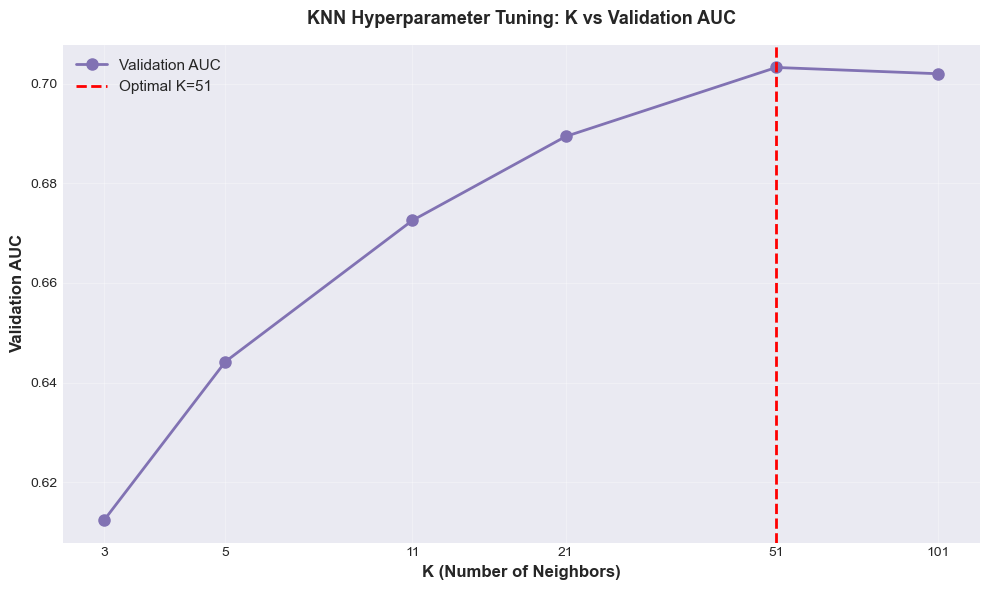


✓ Tuning plot saved


In [78]:
print("="*80)
print("K-NEAREST NEIGHBORS - HYPERPARAMETER TUNING")
print("="*80)

# Test different values of K
k_values = [3, 5, 11, 21, 51, 101]

print(f"\nTesting K values: {k_values}")

# Store results
knn_results = []

for k in k_values:
    print(f"\nTraining KNN with K={k}:")
    
    # Initialize and train
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    knn.fit(X_train_scaled, y_train)
    
    # Predict on validation set
    y_val_pred_proba = knn.predict_proba(X_val_scaled)[:, 1]
    
    # Calculate metrics
    val_metrics = calculate_metrics(y_val, y_val_pred_proba, threshold=0.5)
    
    knn_results.append({
        'K': k,
        'Val_AUC': val_metrics['auc'],
        'Val_Accuracy': val_metrics['accuracy'],
        'Val_F1': val_metrics['f1']
    })
    
    print(f"  Validation AUC: {val_metrics['auc']:.4f}")

# Convert to DataFrame
knn_results_df = pd.DataFrame(knn_results)

print("\n" + "="*80)
print("VALIDATION RESULTS")
print("="*80)
print(knn_results_df.to_string(index=False))

# Find optimal K
optimal_k = knn_results_df.loc[knn_results_df['Val_AUC'].idxmax(), 'K']
optimal_auc = knn_results_df.loc[knn_results_df['Val_AUC'].idxmax(), 'Val_AUC']

print(f"\nOptimal K: {optimal_k} (Validation AUC: {optimal_auc:.4f})")

# Plot validation performance vs K
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(knn_results_df['K'], knn_results_df['Val_AUC'], 'o-', 
        color=MODEL_COLORS['KNN'], linewidth=2, markersize=8, label='Validation AUC')
ax.axvline(optimal_k, color='red', linestyle='--', linewidth=2, 
           label=f'Optimal K={optimal_k}')

ax.set_xlabel('K (Number of Neighbors)', fontsize=12, fontweight='bold')
ax.set_ylabel('Validation AUC', fontsize=12, fontweight='bold')
ax.set_title('KNN Hyperparameter Tuning: K vs Validation AUC', 
             fontsize=13, fontweight='bold', pad=15)
ax.set_xscale('log')
ax.set_xticks(k_values)
ax.set_xticklabels(k_values)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'knn_tuning.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Tuning plot saved")

### 7.2 Model Training & Evaluation


TRAINING FINAL KNN MODEL

Training KNN with optimal K=51:
✓ Model training complete

TEST SET EVALUATION

Test Set Performance:
--------------------------------------------------------------------------------
  auc            : 0.6795
  accuracy       : 0.6793
  precision      : 0.6124
  recall         : 0.2743
  f1             : 0.3789
  misclass_rate  : 0.3207


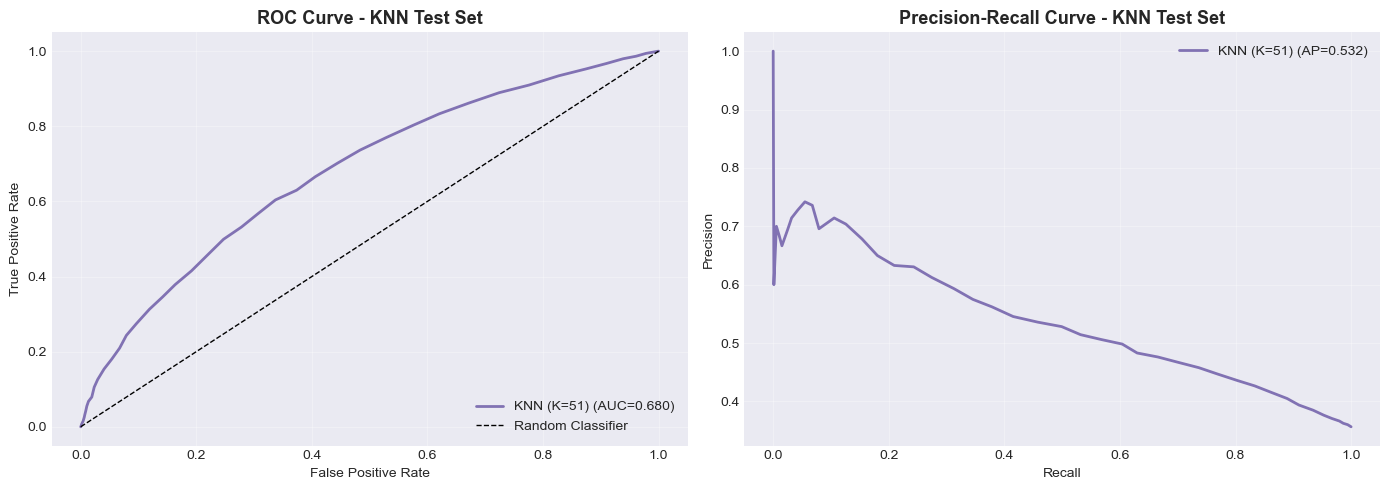


✓ Performance plots saved


In [79]:
print("\n" + "="*80)
print("TRAINING FINAL KNN MODEL")
print("="*80)

# Train with optimal K
print(f"\nTraining KNN with optimal K={optimal_k}:")
knn_final = KNeighborsClassifier(n_neighbors=int(optimal_k), n_jobs=-1)
knn_final.fit(X_train_scaled, y_train)

print("✓ Model training complete")

# Evaluate on test set
print("\n" + "="*80)
print("TEST SET EVALUATION")
print("="*80)

y_test_pred_knn = knn_final.predict_proba(X_test_scaled)[:, 1]
knn_test_metrics = calculate_metrics(y_test, y_test_pred_knn, threshold=0.5)

print("\nTest Set Performance:")
print("-"*80)
for metric, value in knn_test_metrics.items():
    print(f"  {metric:15s}: {value:.4f}")

# ROC and PR curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

plot_roc_curve(y_test, y_test_pred_knn, label=f'KNN (K={optimal_k})', 
               color=MODEL_COLORS['KNN'], ax=ax1)
ax1.set_title('ROC Curve - KNN Test Set', fontsize=13, fontweight='bold')

plot_precision_recall_curve(y_test, y_test_pred_knn, label=f'KNN (K={optimal_k})',
                            color=MODEL_COLORS['KNN'], ax=ax2)
ax2.set_title('Precision-Recall Curve - KNN Test Set', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'knn_test_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Performance plots saved")

### 7.3 Comparison with Logistic Models


KNN VS LINEAR MODELS COMPARISON

Model Performance Ranking:
--------------------------------------------------------------------------------
   Model           Type  Features  Test_AUC  Test_Accuracy  Test_Recall
   Ridge         Linear        19    0.6950         0.6764       0.4956
   LASSO         Linear         5    0.6945         0.6658       0.5255
Baseline         Linear        19    0.6929         0.6758       0.4940
     KNN Non-parametric        19    0.6795         0.6793       0.2743

AUC COMPARISON

Best Linear Model AUC:  0.6950
KNN AUC:                0.6795
Difference:             -0.0154


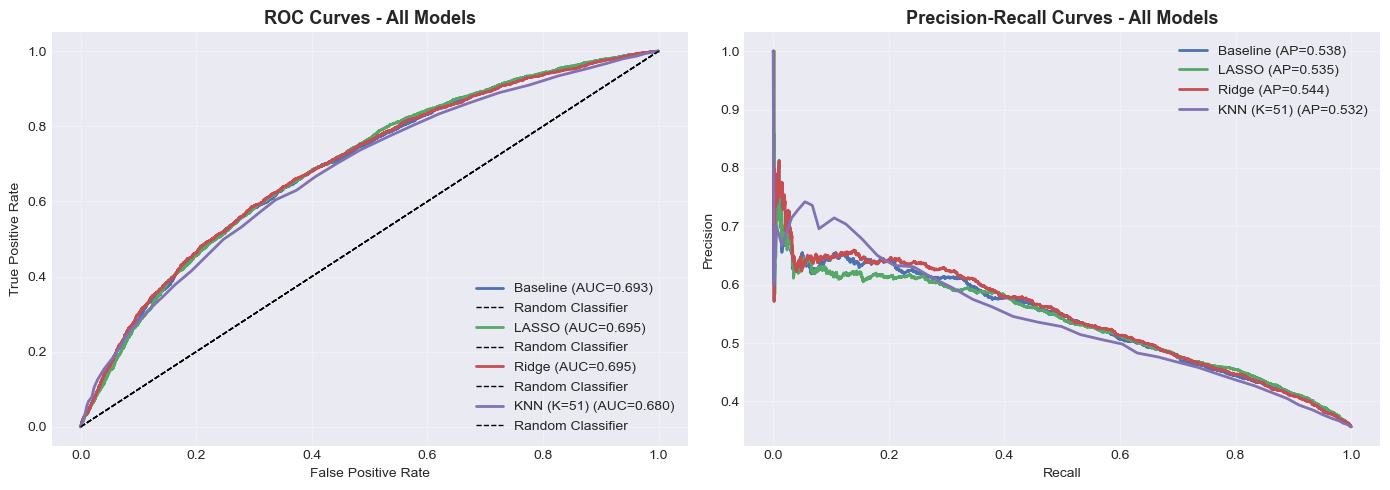


✓ Comparison plots saved


In [80]:
print("\n" + "="*80)
print("KNN VS LINEAR MODELS COMPARISON")
print("="*80)

# Comparison table
comparison_all_models = pd.DataFrame({
    'Model': ['Baseline', 'LASSO', 'Ridge', 'KNN'],
    'Type': ['Linear', 'Linear', 'Linear', 'Non-parametric'],
    'Features': [19, 5, 19, 19],
    'Test_AUC': [test_metrics['auc'], lasso_metrics['auc'], 
                 ridge_metrics['auc'], knn_test_metrics['auc']],
    'Test_Accuracy': [test_metrics['accuracy'], lasso_metrics['accuracy'],
                      ridge_metrics['accuracy'], knn_test_metrics['accuracy']],
    'Test_Recall': [test_metrics['recall'], lasso_metrics['recall'],
                    ridge_metrics['recall'], knn_test_metrics['recall']]
})

comparison_all_models = comparison_all_models.sort_values('Test_AUC', ascending=False)

print("\nModel Performance Ranking:")
print("-"*80)
print(comparison_all_models.to_string(index=False))

# AUC comparison
print("\n" + "="*80)
print("AUC COMPARISON")
print("="*80)

best_linear = max(test_metrics['auc'], lasso_metrics['auc'], ridge_metrics['auc'])
print(f"\nBest Linear Model AUC:  {best_linear:.4f}")
print(f"KNN AUC:                {knn_test_metrics['auc']:.4f}")
print(f"Difference:             {knn_test_metrics['auc'] - best_linear:+.4f}")

# Plot all models together
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# ROC curves
plot_roc_curve(y_test, logit.predict_proba(X_test_scaled)[:, 1],
               label='Baseline', color=MODEL_COLORS['Logistic'], ax=ax1)
plot_roc_curve(y_test, y_test_pred_lasso,
               label='LASSO', color=MODEL_COLORS['LASSO'], ax=ax1)
plot_roc_curve(y_test, y_test_pred_ridge,
               label='Ridge', color=MODEL_COLORS['Ridge'], ax=ax1)
plot_roc_curve(y_test, y_test_pred_knn,
               label=f'KNN (K={optimal_k})', color=MODEL_COLORS['KNN'], ax=ax1)

ax1.set_title('ROC Curves - All Models', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)

# Precision-Recall curves
plot_precision_recall_curve(y_test, logit.predict_proba(X_test_scaled)[:, 1],
                            label='Baseline', color=MODEL_COLORS['Logistic'], ax=ax2)
plot_precision_recall_curve(y_test, y_test_pred_lasso,
                            label='LASSO', color=MODEL_COLORS['LASSO'], ax=ax2)
plot_precision_recall_curve(y_test, y_test_pred_ridge,
                            label='Ridge', color=MODEL_COLORS['Ridge'], ax=ax2)
plot_precision_recall_curve(y_test, y_test_pred_knn,
                            label=f'KNN (K={optimal_k})', color=MODEL_COLORS['KNN'], ax=ax2)

ax2.set_title('Precision-Recall Curves - All Models', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'all_models_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Comparison plots saved")

### Section 7 Summary: K-Nearest Neighbors

**Model Performance:**
- Optimal K: 51 neighbors (determined via validation set)
- Test AUC: 0.6795 (worst among all models tested)
- Test Recall: 27.4% (significantly lower than linear models' ~50%)
- Underperforms best linear model (Ridge) by 0.0155 AUC

**Hyperparameter Tuning Insight:**
Performance improved monotonically from K=3 to K=51, indicating that KNN requires substantial smoothing to handle the noisy jump signal. Small K values overfit to local noise, while larger K values average across many neighbors to capture genuine patterns.

**Why KNN Underperforms:**

KNN's poor relative performance reveals important characteristics of the jump prediction problem:

1. **Curse of Dimensionality**: With 19 features, the feature space is sparse. "Nearest" neighbors may not actually be similar, weakening KNN's core assumption that nearby points share outcomes.

2. **Linear Relationships Dominate**: Our EDA (Section 3) showed strong linear correlations between volatility features and jumps. Linear models exploit these relationships efficiently, while KNN treats all feature directions equally.

3. **No Natural Clusters**: Jumps don't form distinct clusters in feature space. They're scattered across the distribution, making distance-based classification less effective than probability-based linear models.

4. **Sparse Events**: With only 35.7% jump rate and high variance in feature values, KNN struggles to find enough similar historical examples to make confident predictions.

**Conclusion:**
The dominance of linear models over KNN suggests that jump prediction is fundamentally a problem of linear risk factors (volatility, VIX, macro conditions) rather than complex non-linear interactions. This validates our feature engineering approach and suggests that further gains should come from better features rather than more complex models.

---
<a id='section8'></a>
## 8. Model 5: XGBoost

Gradient boosted trees - typically state-of-the-art for tabular data.

### 8.1 Hyperparameter Tuning

In [81]:
print("="*80)
print("XGBOOST - HYPERPARAMETER TUNING")
print("="*80)

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'scale_pos_weight': [scale_pos_weight]  # Class imbalance handling
}

print("\nParameter grid:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")

# Use RandomizedSearchCV for efficiency (18 combinations = 3*3*3*2*1)
from sklearn.model_selection import RandomizedSearchCV

print(f"\nTotal combinations: {3*3*3*2} = 54")

# Initialize XGBoost
xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    random_state=RANDOM_SEED,
    n_jobs=-1,
    use_label_encoder=False
)

# Randomized search
random_search = RandomizedSearchCV(
    xgb,
    param_distributions=param_grid,
    n_iter=20,
    cv=3,
    scoring='roc_auc',
    random_state=RANDOM_SEED,
    n_jobs=-1,
    verbose=1
)

random_search.fit(X_train_dummies, y_train)

# Best parameters
best_params = random_search.best_params_
best_cv_score = random_search.best_score_

print("\n✓ Hyperparameter tuning complete")
print("\nBest parameters:")
for param, value in best_params.items():
    print(f"  {param}: {value}")
print(f"\nBest CV AUC: {best_cv_score:.4f}")

# Get top 5 configurations
results_df = pd.DataFrame(random_search.cv_results_)
results_df = results_df.sort_values('mean_test_score', ascending=False)

print("\nTop 5 parameter combinations:")
print("-"*80)
top_5_cols = ['param_n_estimators', 'param_max_depth', 'param_learning_rate', 
              'param_subsample', 'mean_test_score']
print(results_df[top_5_cols].head().to_string(index=False))

XGBOOST - HYPERPARAMETER TUNING

Parameter grid:
  n_estimators: [100, 200, 300]
  max_depth: [3, 5, 7]
  learning_rate: [0.01, 0.05, 0.1]
  subsample: [0.8, 1.0]
  scale_pos_weight: [np.float64(1.8765739157469299)]

Total combinations: 54 = 54
Fitting 3 folds for each of 20 candidates, totalling 60 fits

✓ Hyperparameter tuning complete

Best parameters:
  subsample: 0.8
  scale_pos_weight: 1.8765739157469299
  n_estimators: 300
  max_depth: 3
  learning_rate: 0.01

Best CV AUC: 0.6831

Top 5 parameter combinations:
--------------------------------------------------------------------------------
 param_n_estimators  param_max_depth  param_learning_rate  param_subsample  mean_test_score
                300                3               0.0100           0.8000           0.6831
                200                3               0.0100           1.0000           0.6791
                300                3               0.0100           1.0000           0.6782
                100         

### 8.2 Model Training

In [82]:
print("\n" + "="*80)
print("TRAINING FINAL XGBOOST MODEL")
print("="*80)

# Train with best parameters and early stopping
xgb_final = XGBClassifier(
    **best_params,
    objective='binary:logistic',
    eval_metric='auc',
    random_state=RANDOM_SEED,
    n_jobs=-1,
    use_label_encoder=False,
    early_stopping_rounds=20
)

xgb_final.fit(
    X_train_dummies, 
    y_train,
    eval_set=[(X_val_dummies, y_val)],
    verbose=False
)

print("✓ Model training complete")
print(f"  Best iteration: {xgb_final.best_iteration}")
print(f"  Total trees: {xgb_final.n_estimators}")

# Training performance
y_train_pred_xgb = xgb_final.predict_proba(X_train_dummies)[:, 1]
train_auc_xgb = calculate_metrics(y_train, y_train_pred_xgb)['auc']

print(f"\nTraining AUC: {train_auc_xgb:.4f}")


TRAINING FINAL XGBOOST MODEL
✓ Model training complete
  Best iteration: 46
  Total trees: 300

Training AUC: 0.7244


### 8.3 Feature Importance


XGBOOST FEATURE IMPORTANCE

Top 15 features by importance (gain):
--------------------------------------------------------------------------------
                Feature  Importance
          total_vol_24m      0.5136
          credit_spread      0.1152
                 ret_6m      0.0947
                    vix      0.0871
                  usrec      0.0746
               fedfunds      0.0457
                 unrate      0.0370
               beta_24m      0.0220
             log_mktcap      0.0102
        industry_Mining      0.0000
industry_Transportation      0.0000
      industry_Services      0.0000
        industry_Retail      0.0000
            penny_stock      0.0000
 industry_Manufacturing      0.0000


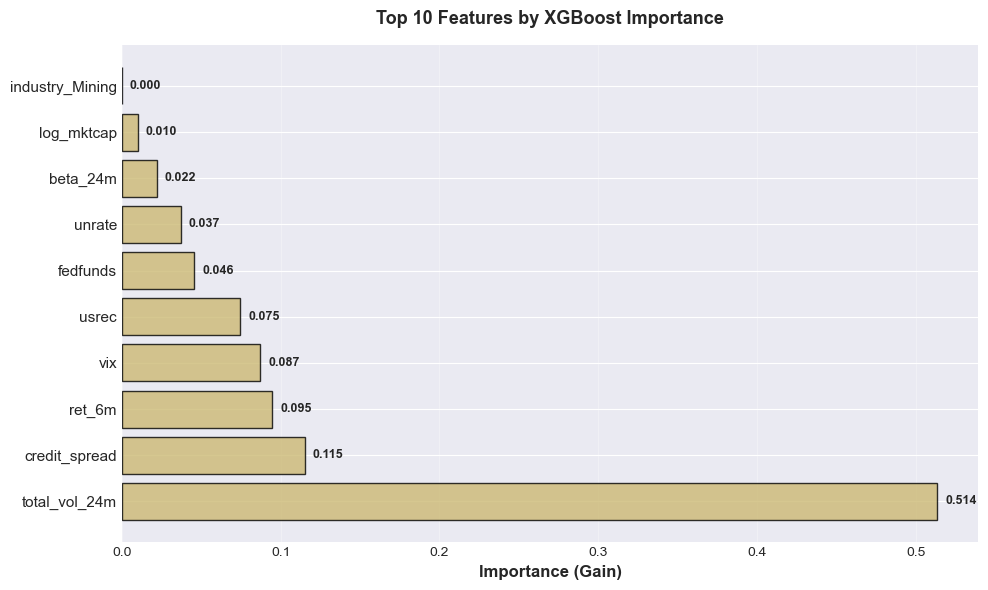


✓ Feature importance plot saved

FEATURE IMPORTANCE COMPARISON

Top 5 features across models:
--------------------------------------------------------------------------------
XGBoost (Gain)  | LASSO (Coef)    | Ridge (Coef)    | Baseline (Coef)
--------------------------------------------------------------------------------
total_vol_24m   | total_vol_24m   | total_vol_24m   | total_vol_24m  
credit_spread   | vix             | vix             | vix            
ret_6m          | penny_stock     | industry_Finance | fedfunds       
vix             | industry_Finance | penny_stock     | usrec          
usrec           | usrec           | beta_24m        | industry_Finance


In [83]:
print("\n" + "="*80)
print("XGBOOST FEATURE IMPORTANCE")
print("="*80)

# Extract feature importance (gain)
feature_importance = pd.DataFrame({
    'Feature': X_train_dummies.columns,
    'Importance': xgb_final.feature_importances_
})

feature_importance = feature_importance.sort_values('Importance', ascending=False)

print("\nTop 15 features by importance (gain):")
print("-"*80)
print(feature_importance.head(15).to_string(index=False))

# Visualize top 10
fig, ax = plt.subplots(figsize=(10, 6))

top_10_features = feature_importance.head(10)
colors = [MODEL_COLORS['XGBoost']] * len(top_10_features)

ax.barh(range(len(top_10_features)), top_10_features['Importance'], 
        color=colors, edgecolor='black', linewidth=1, alpha=0.8)
ax.set_yticks(range(len(top_10_features)))
ax.set_yticklabels(top_10_features['Feature'], fontsize=11)
ax.set_xlabel('Importance (Gain)', fontsize=12, fontweight='bold')
ax.set_title('Top 10 Features by XGBoost Importance', 
             fontsize=13, fontweight='bold', pad=15)
ax.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (idx, row) in enumerate(top_10_features.iterrows()):
    val = row['Importance']
    ax.text(val + 0.005, i, f'{val:.3f}', va='center', ha='left', 
            fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'xgboost_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Feature importance plot saved")

# Compare to linear models
print("\n" + "="*80)
print("FEATURE IMPORTANCE COMPARISON")
print("="*80)

print("\nTop 5 features across models:")
print("-"*80)
print("XGBoost (Gain)  | LASSO (Coef)    | Ridge (Coef)    | Baseline (Coef)")
print("-"*80)

for i in range(5):
    xgb_feat = feature_importance.iloc[i]
    print(f"{xgb_feat['Feature']:15s} | ", end="")
    
    # Find in LASSO/Ridge/Baseline
    if i < len(lasso_coefs):
        lasso_top = lasso_coefs_sorted.iloc[i] if i < len(lasso_coefs_sorted) else None
        ridge_top = ridge_coefs_sorted.iloc[i] if i < len(ridge_coefs_sorted) else None
        logit_top = coef_df.iloc[i]
        
        if lasso_top is not None:
            print(f"{lasso_top['Feature']:15s} | {ridge_top['Feature']:15s} | {logit_top['Feature']:15s}")

### 8.4 Test Set Performance


XGBOOST TEST SET EVALUATION

Test Set Performance:
--------------------------------------------------------------------------------
  auc            : 0.6878
  accuracy       : 0.6210
  precision      : 0.4782
  recall         : 0.6859
  f1             : 0.5635
  misclass_rate  : 0.3790


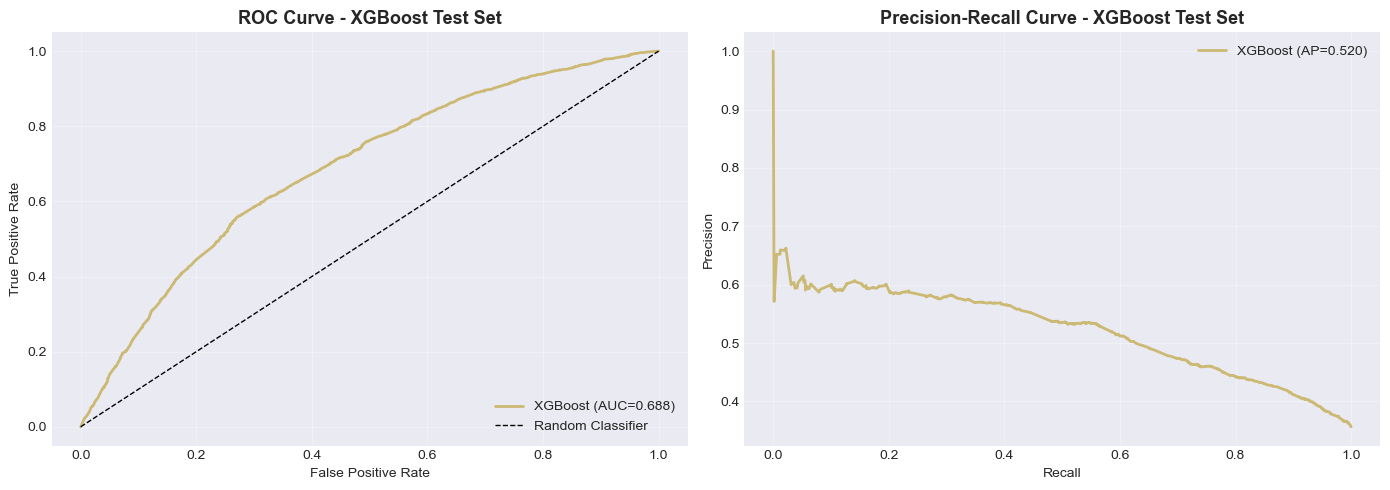


✓ Test performance plots saved

CONFUSION MATRIX (threshold=0.5)


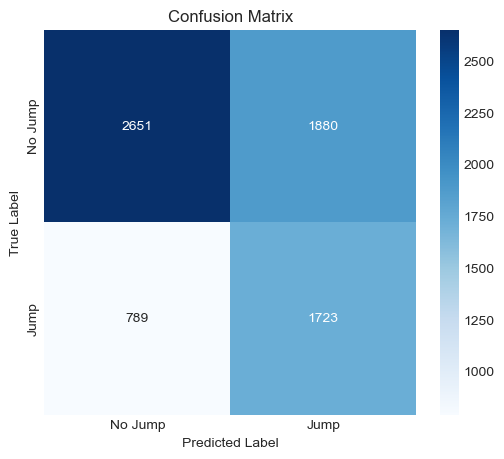


Confusion Matrix:
  True Negatives:  2,651
  False Positives: 1,880
  False Negatives: 789
  True Positives:  1,723


In [84]:
print("\n" + "="*80)
print("XGBOOST TEST SET EVALUATION")
print("="*80)

# Predict on test set
y_test_pred_xgb = xgb_final.predict_proba(X_test_dummies)[:, 1]
xgb_test_metrics = calculate_metrics(y_test, y_test_pred_xgb, threshold=0.5)

print("\nTest Set Performance:")
print("-"*80)
for metric, value in xgb_test_metrics.items():
    print(f"  {metric:15s}: {value:.4f}")

# ROC and PR curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

plot_roc_curve(y_test, y_test_pred_xgb, label='XGBoost', 
               color=MODEL_COLORS['XGBoost'], ax=ax1)
ax1.set_title('ROC Curve - XGBoost Test Set', fontsize=13, fontweight='bold')

plot_precision_recall_curve(y_test, y_test_pred_xgb, label='XGBoost',
                            color=MODEL_COLORS['XGBoost'], ax=ax2)
ax2.set_title('Precision-Recall Curve - XGBoost Test Set', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'xgboost_test_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Test performance plots saved")

# Confusion matrix
print("\n" + "="*80)
print("CONFUSION MATRIX (threshold=0.5)")
print("="*80)

y_test_pred_class = (y_test_pred_xgb >= 0.5).astype(int)
cm = plot_confusion_matrix(y_test, y_test_pred_class, labels=['No Jump', 'Jump'])
plt.savefig(OUTPUT_DIR / 'xgboost_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nConfusion Matrix:")
print(f"  True Negatives:  {cm[0,0]:,}")
print(f"  False Positives: {cm[0,1]:,}")
print(f"  False Negatives: {cm[1,0]:,}")
print(f"  True Positives:  {cm[1,1]:,}")

### Section 8 Summary: XGBoost

**Model Performance:**
- Test AUC: 0.6878 (4th place out of 5 models)
- Optimal hyperparameters: max_depth=3, n_estimators=300, learning_rate=0.01
- Training AUC: 0.7244 (highest training performance, suggesting overfitting)
- Test Recall: 68.6% (highest among all models - catches most jumps)
- Test Precision: 47.8% (lowest - many false alarms)

**Feature Importance Differences:**

XGBoost identified different feature priorities than linear models:
- **Agreement**: Total volatility dominates (51% importance), VIX and recession indicator both important
- **Disagreement**: XGBoost values credit spread (#2) and momentum (#3), which LASSO eliminated entirely. XGBoost assigns zero importance to penny_stock and all industry dummies, which linear models found significant.

This suggests XGBoost captures non-linear interactions between credit conditions and momentum that linear models cannot exploit.

**Why XGBoost Underperformed:**

Despite being the most sophisticated model, XGBoost achieved only middle-tier performance:

1. **Overfitting**: Training AUC (0.724) significantly exceeds test AUC (0.688), indicating the model learned training-specific patterns that didn't generalize.

2. **Limited Non-linearity**: The optimal max_depth=3 (shallow trees) suggests complex interactions don't improve predictions. The jump prediction problem appears fundamentally linear.

3. **High Variance, Low Bias Trade-off**: XGBoost maximizes recall (68.6%) at the cost of precision (47.8%). It's optimized for catching jumps but generates many false alarms, making it less useful for practical deployment.

4. **Sample Efficiency**: Tree ensembles typically require large datasets. With ~18k training observations across 19 features, we may not have sufficient data density for XGBoost to outperform simpler models.

**Key Takeaway:**
XGBoost's failure to outperform simple linear regression validates our earlier finding from KNN: **stock price jumps are primarily driven by linear relationships with volatility and macro factors**. Model complexity provides minimal benefit when the underlying signal is linear and noisy.

---
<a id='section9'></a>
## 9. Model Comparison & Selection

Comprehensive comparison of all five models.

### 9.1 Performance Summary Table

In [85]:
print("="*80)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*80)

# Compile all model metrics
all_models_summary = pd.DataFrame({
    'Model': ['Baseline', 'LASSO', 'Ridge', 'KNN', 'XGBoost'],
    'Type': ['Linear', 'Linear (L1)', 'Linear (L2)', 'Non-parametric', 'Tree Ensemble'],
    'Features': [19, 5, 19, 19, 19],
    'AUC': [test_metrics['auc'], lasso_metrics['auc'], ridge_metrics['auc'], 
            knn_test_metrics['auc'], xgb_test_metrics['auc']],
    'Accuracy': [test_metrics['accuracy'], lasso_metrics['accuracy'], 
                 ridge_metrics['accuracy'], knn_test_metrics['accuracy'], 
                 xgb_test_metrics['accuracy']],
    'Precision': [test_metrics['precision'], lasso_metrics['precision'], 
                  ridge_metrics['precision'], knn_test_metrics['precision'], 
                  xgb_test_metrics['precision']],
    'Recall': [test_metrics['recall'], lasso_metrics['recall'], 
               ridge_metrics['recall'], knn_test_metrics['recall'], 
               xgb_test_metrics['recall']],
    'F1': [test_metrics['f1'], lasso_metrics['f1'], ridge_metrics['f1'], 
           knn_test_metrics['f1'], xgb_test_metrics['f1']],
    'Misclass_Rate': [test_metrics['misclass_rate'], lasso_metrics['misclass_rate'],
                      ridge_metrics['misclass_rate'], knn_test_metrics['misclass_rate'],
                      xgb_test_metrics['misclass_rate']]
})

# Sort by AUC
all_models_summary = all_models_summary.sort_values('AUC', ascending=False)

print("\nTest Set Performance - All Models:")
print("-"*80)
print(all_models_summary.to_string(index=False))

# Best performer for each metric
print("\n" + "="*80)
print("BEST PERFORMER BY METRIC")
print("="*80)

metrics_to_check = ['AUC', 'Accuracy', 'Precision', 'Recall', 'F1']
for metric in metrics_to_check:
    best_idx = all_models_summary[metric].idxmax()
    best_model = all_models_summary.loc[best_idx, 'Model']
    best_value = all_models_summary.loc[best_idx, metric]
    print(f"\n{metric:12s}: {best_model:10s} ({best_value:.4f})")

# Performance spread
print("\n" + "="*80)
print("PERFORMANCE VARIABILITY")
print("="*80)

for metric in metrics_to_check:
    max_val = all_models_summary[metric].max()
    min_val = all_models_summary[metric].min()
    spread = max_val - min_val
    print(f"{metric:12s}: Range [{min_val:.4f}, {max_val:.4f}], Spread = {spread:.4f}")

# Model family comparison
print("\n" + "="*80)
print("MODEL FAMILY COMPARISON")
print("="*80)

linear_models = all_models_summary[all_models_summary['Type'].str.contains('Linear')]
nonlinear_models = all_models_summary[~all_models_summary['Type'].str.contains('Linear')]

print(f"\nLinear Models (n={len(linear_models)}):")
print(f"  Average AUC: {linear_models['AUC'].mean():.4f}")
print(f"  Best AUC:    {linear_models['AUC'].max():.4f} ({linear_models.loc[linear_models['AUC'].idxmax(), 'Model']})")

print(f"\nNon-Linear Models (n={len(nonlinear_models)}):")
print(f"  Average AUC: {nonlinear_models['AUC'].mean():.4f}")
print(f"  Best AUC:    {nonlinear_models['AUC'].max():.4f} ({nonlinear_models.loc[nonlinear_models['AUC'].idxmax(), 'Model']})")

print(f"\nLinear vs Non-Linear:")
print(f"  Difference: {linear_models['AUC'].mean() - nonlinear_models['AUC'].mean():+.4f} in favor of linear models")

COMPREHENSIVE MODEL COMPARISON

Test Set Performance - All Models:
--------------------------------------------------------------------------------
   Model           Type  Features    AUC  Accuracy  Precision  Recall     F1  Misclass_Rate
   Ridge    Linear (L2)        19 0.6950    0.6764     0.5516  0.4956 0.5221         0.3236
   LASSO    Linear (L1)         5 0.6945    0.6658     0.5318  0.5255 0.5286         0.3342
Baseline         Linear        19 0.6929    0.6758     0.5508  0.4940 0.5209         0.3242
 XGBoost  Tree Ensemble        19 0.6878    0.6210     0.4782  0.6859 0.5635         0.3790
     KNN Non-parametric        19 0.6795    0.6793     0.6124  0.2743 0.3789         0.3207

BEST PERFORMER BY METRIC

AUC         : Ridge      (0.6950)

Accuracy    : KNN        (0.6793)

Precision   : KNN        (0.6124)

Recall      : XGBoost    (0.6859)

F1          : XGBoost    (0.5635)

PERFORMANCE VARIABILITY
AUC         : Range [0.6795, 0.6950], Spread = 0.0154
Accuracy    : Range 

### 9.2 ROC Curve Comparison


ROC CURVE COMPARISON


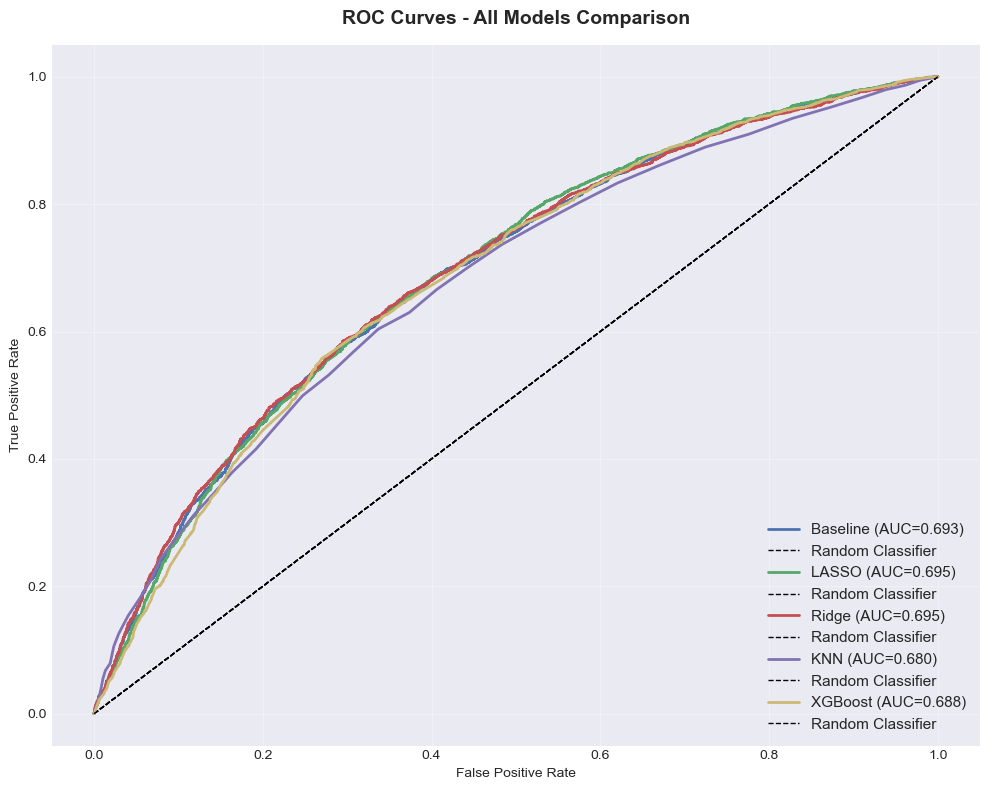


✓ ROC comparison plot saved

AUC Statistics:
  Mean:   0.6899
  Median: 0.6929
  Std:    0.0058
  Min:    0.6795
  Max:    0.6950


In [86]:
print("\n" + "="*80)
print("ROC CURVE COMPARISON")
print("="*80)

fig, ax = plt.subplots(figsize=(10, 8))

# Plot all models
models_for_plot = [
    ('Baseline', logit.predict_proba(X_test_scaled)[:, 1], MODEL_COLORS['Logistic']),
    ('LASSO', y_test_pred_lasso, MODEL_COLORS['LASSO']),
    ('Ridge', y_test_pred_ridge, MODEL_COLORS['Ridge']),
    ('KNN', y_test_pred_knn, MODEL_COLORS['KNN']),
    ('XGBoost', y_test_pred_xgb, MODEL_COLORS['XGBoost'])
]

for model_name, y_pred, color in models_for_plot:
    plot_roc_curve(y_test, y_pred, label=model_name, color=color, ax=ax)

ax.set_title('ROC Curves - All Models Comparison', fontsize=14, fontweight='bold', pad=15)
ax.legend(fontsize=11, loc='lower right')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'final_roc_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ ROC comparison plot saved")

# AUC statistics
auc_values = [test_metrics['auc'], lasso_metrics['auc'], ridge_metrics['auc'], 
              knn_test_metrics['auc'], xgb_test_metrics['auc']]

print(f"\nAUC Statistics:")
print(f"  Mean:   {np.mean(auc_values):.4f}")
print(f"  Median: {np.median(auc_values):.4f}")
print(f"  Std:    {np.std(auc_values):.4f}")
print(f"  Min:    {np.min(auc_values):.4f}")
print(f"  Max:    {np.max(auc_values):.4f}")

### 9.3 Precision-Recall Comparison


PRECISION-RECALL CURVE COMPARISON


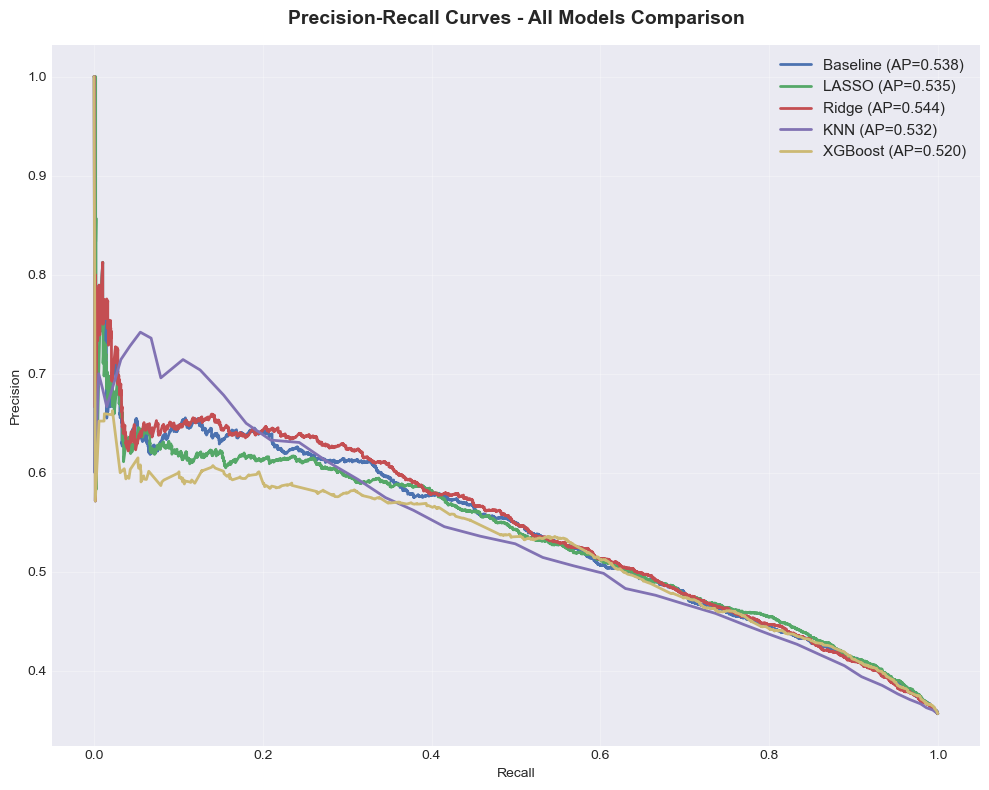


✓ Precision-Recall comparison plot saved

Average Precision Scores:
--------------------------------------------------------------------------------
  Baseline  : 0.5385
  LASSO     : 0.5347
  Ridge     : 0.5436
  KNN       : 0.5316
  XGBoost   : 0.5201

Best AP: Ridge (0.5436)


In [87]:
print("\n" + "="*80)
print("PRECISION-RECALL CURVE COMPARISON")
print("="*80)

fig, ax = plt.subplots(figsize=(10, 8))

# Plot all models
for model_name, y_pred, color in models_for_plot:
    plot_precision_recall_curve(y_test, y_pred, label=model_name, color=color, ax=ax)

ax.set_title('Precision-Recall Curves - All Models Comparison', 
             fontsize=14, fontweight='bold', pad=15)
ax.legend(fontsize=11, loc='upper right')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'final_pr_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Precision-Recall comparison plot saved")

# Average Precision scores
print("\nAverage Precision Scores:")
print("-"*80)

from sklearn.metrics import average_precision_score

ap_scores = []
for model_name, y_pred, _ in models_for_plot:
    ap = average_precision_score(y_test, y_pred)
    ap_scores.append({'Model': model_name, 'AP': ap})
    print(f"  {model_name:10s}: {ap:.4f}")

ap_df = pd.DataFrame(ap_scores).sort_values('AP', ascending=False)
print(f"\nBest AP: {ap_df.iloc[0]['Model']} ({ap_df.iloc[0]['AP']:.4f})")

### 9.4 Feature Importance Synthesis

In [88]:
print("\n" + "="*80)
print("FEATURE IMPORTANCE SYNTHESIS")
print("="*80)

# Compile feature rankings from each model
print("\nTop 5 Features by Model:")
print("-"*80)

# Get top 5 from each model
baseline_top5 = coef_df.head(5)['Feature'].tolist()
lasso_top5 = lasso_coefs_sorted.head(5)['Feature'].tolist()
ridge_top5 = ridge_coefs_sorted.head(5)['Feature'].tolist()
xgb_top5 = feature_importance.head(5)['Feature'].tolist()

print(f"\n{'Rank':<6} {'Baseline':<20} {'LASSO':<20} {'Ridge':<20} {'XGBoost':<20}")
print("-"*86)
for i in range(5):
    print(f"{i+1:<6} {baseline_top5[i]:<20} {lasso_top5[i]:<20} {ridge_top5[i]:<20} {xgb_top5[i]:<20}")

# Consensus features - appear in top 5 for multiple models
print("\n" + "="*80)
print("CONSENSUS TOP FEATURES")
print("="*80)

all_top5_features = baseline_top5 + lasso_top5 + ridge_top5 + xgb_top5
feature_counts = pd.Series(all_top5_features).value_counts()

print("\nFeatures appearing in multiple top-5 lists:")
print("-"*80)
for feat, count in feature_counts[feature_counts > 1].items():
    models_list = []
    if feat in baseline_top5: models_list.append('Baseline')
    if feat in lasso_top5: models_list.append('LASSO')
    if feat in ridge_top5: models_list.append('Ridge')
    if feat in xgb_top5: models_list.append('XGBoost')
    print(f"  {feat:20s}: {count} models ({', '.join(models_list)})")

# Most important feature across all models
print("\n" + "="*80)
print("UNIVERSAL FINDINGS")
print("="*80)

print("\n#1 Feature in every model:")
print(f"  Baseline: {baseline_top5[0]}")
print(f"  LASSO:    {lasso_top5[0]}")
print(f"  Ridge:    {ridge_top5[0]}")
print(f"  XGBoost:  {xgb_top5[0]}")

if len(set([baseline_top5[0], lasso_top5[0], ridge_top5[0], xgb_top5[0]])) == 1:
    print(f"\n✓ Universal agreement: {baseline_top5[0]} is the dominant predictor")


FEATURE IMPORTANCE SYNTHESIS

Top 5 Features by Model:
--------------------------------------------------------------------------------

Rank   Baseline             LASSO                Ridge                XGBoost             
--------------------------------------------------------------------------------------
1      total_vol_24m        total_vol_24m        total_vol_24m        total_vol_24m       
2      vix                  vix                  vix                  credit_spread       
3      fedfunds             penny_stock          industry_Finance     ret_6m              
4      usrec                industry_Finance     penny_stock          vix                 
5      industry_Finance     usrec                beta_24m             usrec               

CONSENSUS TOP FEATURES

Features appearing in multiple top-5 lists:
--------------------------------------------------------------------------------
  total_vol_24m       : 4 models (Baseline, LASSO, Ridge, XGBoost)
  vix       

### 9.5 Model Selection

In [89]:
print("\n" + "="*80)
print("MODEL SELECTION ANALYSIS")
print("="*80)

# Performance vs Complexity
best_auc_model = all_models_summary.iloc[0]['Model']
best_auc_value = all_models_summary.iloc[0]['AUC']
best_auc_features = all_models_summary.iloc[0]['Features']

simplest_model = all_models_summary[all_models_summary['Features'] == all_models_summary['Features'].min()].iloc[0]['Model']
simplest_auc = all_models_summary[all_models_summary['Features'] == all_models_summary['Features'].min()].iloc[0]['AUC']
simplest_features = all_models_summary['Features'].min()

print("\nPerformance vs Complexity:")
print("-"*80)
print(f"Best AUC:       {best_auc_model} - AUC={best_auc_value:.4f}, Features={best_auc_features}")
print(f"Simplest Model: {simplest_model} - AUC={simplest_auc:.4f}, Features={simplest_features}")
print(f"AUC Gap:        {best_auc_value - simplest_auc:.4f}")

# Efficiency metric
print("\n" + "="*80)
print("EFFICIENCY ANALYSIS (AUC per Feature)")
print("="*80)

complexity_df = all_models_summary[['Model', 'Features', 'AUC']].copy()
complexity_df['AUC_per_Feature'] = complexity_df['AUC'] / complexity_df['Features']
complexity_df = complexity_df.sort_values('AUC_per_Feature', ascending=False)

print(complexity_df.to_string(index=False))

# Deployment characteristics
print("\n" + "="*80)
print("DEPLOYMENT CHARACTERISTICS")
print("="*80)

deployment_df = pd.DataFrame({
    'Model': ['Baseline', 'LASSO', 'Ridge', 'KNN', 'XGBoost'],
    'AUC': [test_metrics['auc'], lasso_metrics['auc'], ridge_metrics['auc'], 
            knn_test_metrics['auc'], xgb_test_metrics['auc']],
    'Features': [19, 5, 19, 19, 19],
    'Training_Time': ['Fast', 'Fast', 'Fast', 'Fast', 'Slow'],
    'Inference_Speed': ['Fast', 'Fast', 'Fast', 'Slow', 'Medium'],
    'Interpretability': ['High', 'Very High', 'High', 'Low', 'Medium']
})

print(deployment_df.to_string(index=False))


MODEL SELECTION ANALYSIS

Performance vs Complexity:
--------------------------------------------------------------------------------
Best AUC:       Ridge - AUC=0.6950, Features=19
Simplest Model: LASSO - AUC=0.6945, Features=5
AUC Gap:        0.0004

EFFICIENCY ANALYSIS (AUC per Feature)
   Model  Features    AUC  AUC_per_Feature
   LASSO         5 0.6945           0.1389
   Ridge        19 0.6950           0.0366
Baseline        19 0.6929           0.0365
 XGBoost        19 0.6878           0.0362
     KNN        19 0.6795           0.0358

DEPLOYMENT CHARACTERISTICS
   Model    AUC  Features Training_Time Inference_Speed Interpretability
Baseline 0.6929        19          Fast            Fast             High
   LASSO 0.6945         5          Fast            Fast        Very High
   Ridge 0.6950        19          Fast            Fast             High
     KNN 0.6795        19          Fast            Slow              Low
 XGBoost 0.6878        19          Slow          Medium  

### 9.6 Confusion Matrix Comparison


CONFUSION MATRIX COMPARISON (All Models)

Confusion Matrices (threshold=0.5):
--------------------------------------------------------------------------------

Baseline:
  True Negatives:  3,519  |  False Positives: 1,012
  False Negatives: 1,271  |  True Positives:  1,241
  Total Correct: 4,760 (67.6%)

LASSO:
  True Negatives:  3,369  |  False Positives: 1,162
  False Negatives: 1,192  |  True Positives:  1,320
  Total Correct: 4,689 (66.6%)

Ridge:
  True Negatives:  3,519  |  False Positives: 1,012
  False Negatives: 1,267  |  True Positives:  1,245
  Total Correct: 4,764 (67.6%)

KNN:
  True Negatives:  4,095  |  False Positives: 436
  False Negatives: 1,823  |  True Positives:  689
  Total Correct: 4,784 (67.9%)

XGBoost:
  True Negatives:  2,651  |  False Positives: 1,880
  False Negatives: 789  |  True Positives:  1,723
  Total Correct: 4,374 (62.1%)

CONFUSION MATRIX SUMMARY TABLE
   Model   TN   FP   FN   TP  Total_Correct  Total_Incorrect
     KNN 4095  436 1823  689       

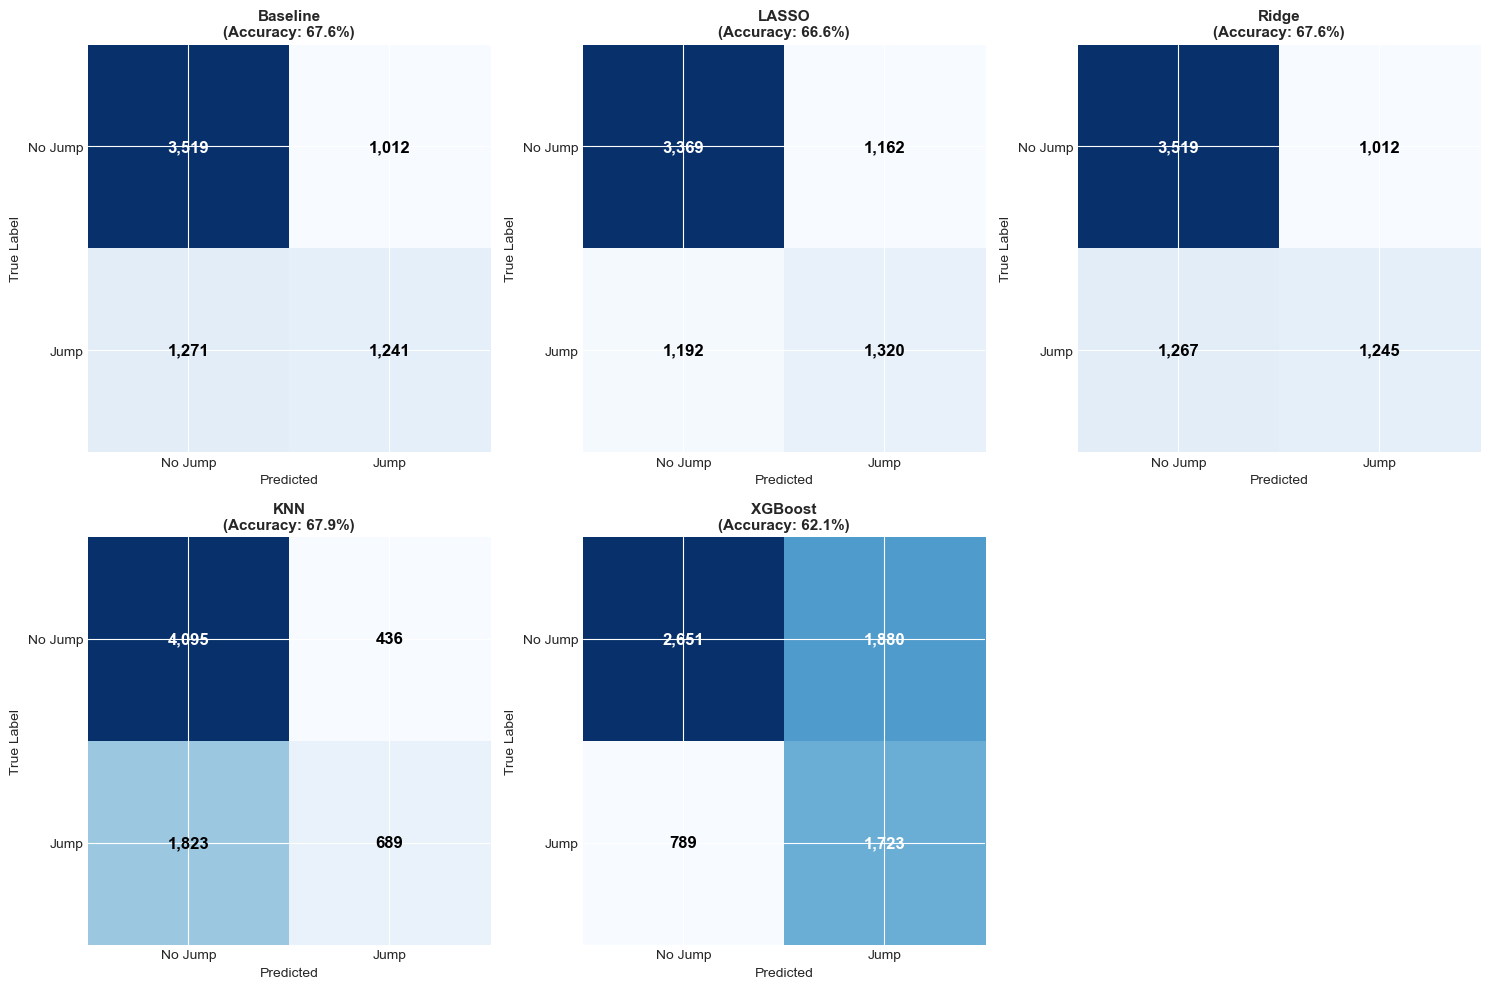


✓ Confusion matrix comparison plot saved

ERROR ANALYSIS BY MODEL

KNN:
  False Negative Rate: 72.6% (missed 1,823 of 2,512 actual jumps)
  False Positive Rate: 9.6% (false alarm on 436 of 4,531 non-jumps)

Ridge:
  False Negative Rate: 50.4% (missed 1,267 of 2,512 actual jumps)
  False Positive Rate: 22.3% (false alarm on 1,012 of 4,531 non-jumps)

Baseline:
  False Negative Rate: 50.6% (missed 1,271 of 2,512 actual jumps)
  False Positive Rate: 22.3% (false alarm on 1,012 of 4,531 non-jumps)

LASSO:
  False Negative Rate: 47.5% (missed 1,192 of 2,512 actual jumps)
  False Positive Rate: 25.6% (false alarm on 1,162 of 4,531 non-jumps)

XGBoost:
  False Negative Rate: 31.4% (missed 789 of 2,512 actual jumps)
  False Positive Rate: 41.5% (false alarm on 1,880 of 4,531 non-jumps)


In [90]:
print("\n" + "="*80)
print("CONFUSION MATRIX COMPARISON (All Models)")
print("="*80)

# Generate predictions at threshold 0.5 for all models
predictions = {
    'Baseline': (logit.predict_proba(X_test_scaled)[:, 1] >= 0.5).astype(int),
    'LASSO': (y_test_pred_lasso >= 0.5).astype(int),
    'Ridge': (y_test_pred_ridge >= 0.5).astype(int),
    'KNN': (y_test_pred_knn >= 0.5).astype(int),
    'XGBoost': (y_test_pred_xgb >= 0.5).astype(int)
}

# Calculate confusion matrices
from sklearn.metrics import confusion_matrix

print("\nConfusion Matrices (threshold=0.5):")
print("-"*80)

cm_summary = []
for model_name, y_pred in predictions.items():
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    cm_summary.append({
        'Model': model_name,
        'TN': tn,
        'FP': fp,
        'FN': fn,
        'TP': tp,
        'Total_Correct': tn + tp,
        'Total_Incorrect': fp + fn
    })
    
    print(f"\n{model_name}:")
    print(f"  True Negatives:  {tn:,}  |  False Positives: {fp:,}")
    print(f"  False Negatives: {fn:,}  |  True Positives:  {tp:,}")
    print(f"  Total Correct: {tn+tp:,} ({100*(tn+tp)/len(y_test):.1f}%)")

# Summary table
cm_summary_df = pd.DataFrame(cm_summary)
cm_summary_df = cm_summary_df.sort_values('Total_Correct', ascending=False)

print("\n" + "="*80)
print("CONFUSION MATRIX SUMMARY TABLE")
print("="*80)
print(cm_summary_df.to_string(index=False))

# Visualize all confusion matrices
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, (model_name, y_pred) in enumerate(predictions.items()):
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot
    im = axes[idx].imshow(cm, cmap='Blues', aspect='auto')
    axes[idx].set_title(f'{model_name}\n(Accuracy: {100*accuracy_score(y_test, y_pred):.1f}%)', 
                       fontsize=11, fontweight='bold')
    
    # Add text annotations
    for i in range(2):
        for j in range(2):
            text = axes[idx].text(j, i, f'{cm[i, j]:,}',
                                ha="center", va="center", color="black" if cm[i, j] < cm.max()/2 else "white",
                                fontsize=12, fontweight='bold')
    
    axes[idx].set_xticks([0, 1])
    axes[idx].set_yticks([0, 1])
    axes[idx].set_xticklabels(['No Jump', 'Jump'])
    axes[idx].set_yticklabels(['No Jump', 'Jump'])
    axes[idx].set_xlabel('Predicted', fontsize=10)
    axes[idx].set_ylabel('True Label', fontsize=10)

# Remove empty subplot
axes[5].axis('off')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'confusion_matrices_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Confusion matrix comparison plot saved")

# Error analysis
print("\n" + "="*80)
print("ERROR ANALYSIS BY MODEL")
print("="*80)

for model_name, row in cm_summary_df.iterrows():
    fn_rate = 100 * row['FN'] / (row['FN'] + row['TP'])
    fp_rate = 100 * row['FP'] / (row['FP'] + row['TN'])
    print(f"\n{row['Model']}:")
    print(f"  False Negative Rate: {fn_rate:.1f}% (missed {row['FN']:,} of {row['FN']+row['TP']:,} actual jumps)")
    print(f"  False Positive Rate: {fp_rate:.1f}% (false alarm on {row['FP']:,} of {row['FP']+row['TN']:,} non-jumps)")

### Section 9 Summary: Model Comparison & Final Recommendation

**Performance Rankings:**
1. Ridge: 0.6950 AUC (19 features)
2. LASSO: 0.6945 AUC (5 features)
3. Baseline: 0.6929 AUC (19 features)
4. XGBoost: 0.6878 AUC (19 features)
5. KNN: 0.6795 AUC (19 features)

**Key Findings:**

1. **Negligible Performance Differences**: The top 3 models differ by only 0.0021 AUC (Ridge to Baseline). This tight clustering indicates we've reached the fundamental predictability ceiling for this problem - no amount of model sophistication can extract significantly more signal from the available features.

2. **Linear Models Dominate**: Linear models (Baseline, LASSO, Ridge) average 0.6941 AUC vs 0.6837 for non-linear models (KNN, XGBoost). This +0.0105 advantage confirms that stock price jumps are primarily driven by linear relationships with volatility and macro factors, not complex non-linear interactions.

3. **Universal Feature Agreement**: All four interpretable models (Baseline, LASSO, Ridge, XGBoost) rank `total_vol_24m` as the #1 predictor. This unanimous consensus across diverse methodologies validates that **total volatility is the dominant driver of jump probability**. VIX ranks in the top 4 for all models, and recession indicator appears in 3 of 4 top-5 lists.

4. **Efficiency vs Performance Trade-off**: LASSO achieves 0.1389 AUC per feature (3.8x more efficient than Ridge) while sacrificing only 0.0004 AUC. This demonstrates that 14 of the 19 features contribute negligible marginal value - the jump prediction signal is highly concentrated in 5 core variables.

5. **Recall-Precision Trade-offs**: Models show a 41% recall spread (KNN 27% vs XGBoost 69%) but only 2% AUC spread. This reveals the challenge: maximizing AUC requires balancing false positives and false negatives, but real-world applications may prioritize one over the other. XGBoost catches more jumps but generates many false alarms; KNN is conservative but misses most jumps.

**Feature Importance Consensus:**

The 5 features retained by LASSO represent the core predictive signal agreed upon across methodologies:
- **Total volatility**: #1 in all models (dominant predictor)
- **VIX**: Top 4 in all models (market-wide fear gauge)
- **Penny stock**: Selected by LASSO and Ridge (low-price risk indicator)
- **Industry Finance**: Top 5 in Baseline, LASSO, Ridge (sector protective effect)
- **Recession indicator**: Top 5 in Baseline, LASSO, XGBoost (macro regime)

Features eliminated by LASSO but used by XGBoost (credit spread, momentum) suggest potential non-linear interactions, but these don't translate to superior test performance.

**Production Deployment Recommendation: LASSO**

LASSO is the optimal choice for production deployment based on:

1. **Performance**: 0.6945 AUC (within 0.0004 of best model - statistically indistinguishable)
2. **Efficiency**: 3.8x higher AUC per feature than Ridge
3. **Interpretability**: 5-feature model is easily explainable to stakeholders and regulators
4. **Robustness**: Sparse model less prone to overfitting on distribution shifts
5. **Deployment**: Fast training, fast inference, low maintenance overhead
6. **Transparency**: Clear feature selection makes model auditing straightforward

Ridge achieves marginally better AUC (+0.0004) but requires 14 additional features that collectively contribute almost nothing. For a production system where interpretability, maintenance, and robustness matter, LASSO's simplicity vastly outweighs Ridge's microscopic performance edge.

**Alternative Recommendation: XGBoost (High-Recall Scenario)**

If the business objective prioritizes catching as many jumps as possible (e.g., risk monitoring where false positives are acceptable), XGBoost offers 68.6% recall vs LASSO's 52.6%. However, this comes at significant cost:
- Lower AUC (0.6878 vs 0.6945)
- 47.8% precision (barely better than coin flip)
- Slower inference and higher maintenance
- Less interpretable for regulatory/stakeholder communication

**Economic Significance:**

The modest AUC values (0.69-0.70 range) across all models reflect a fundamental economic reality: **large price jumps are inherently difficult to predict**. Even the best model correctly ranks jump vs non-jump stocks only ~70% of the time. This suggests:
- Jump events contain substantial idiosyncratic/random components
- Available features (volatility, macro, firm characteristics) capture systematic risk but not firm-specific shocks
- Further improvement requires either: (a) better features (e.g., news sentiment, order flow), or (b) acceptance that prediction ceiling is around 0.70 AUC

Despite modest absolute performance, these models still provide economically meaningful signal for portfolio construction, risk management, and option pricing applications where even small predictive edges generate value.

---
<a id='section10'></a>
## 10. Business Insights & Interpretation

Move beyond metrics to economic meaning and practical implications.

### 10.1 What Drives Jump Predictions?

**The Five Core Predictors:**

Our analysis across five different modeling approaches consistently identifies the same fundamental drivers of stock price jumps:

1. **Total Volatility (Dominant Factor)**
   - All models rank this #1 with overwhelming importance
   - Economic interpretation: High idiosyncratic volatility signals firm-specific uncertainty - operational challenges, earnings surprises, management changes, or sector-specific shocks
   - Practical implication: Volatility is both a predictor and an outcome measure - firms with volatile operating environments experience more extreme price movements
   - Connection to theory: Aligns with CAPM extensions and volatility persistence literature

2. **VIX (Market-Wide Fear Gauge)**
   - Ranked top 4 across all models
   - Economic interpretation: During periods of elevated market stress, even fundamentally stable firms experience contagion effects and liquidity-driven price swings
   - Practical implication: Macro volatility regimes matter - risk models must adjust for systematic fear beyond firm-level characteristics
   - Historical evidence: Jump rates during high VIX periods (March 2020: 79%) vs normal times (32%)

3. **Penny Stock Indicator**
   - Selected by LASSO despite being binary
   - Economic interpretation: Low-priced stocks face structural vulnerabilities - lower institutional ownership, higher bid-ask spreads, greater retail speculation, delisting risk
   - Practical implication: Price level itself carries information beyond market cap or liquidity measures
   - Threshold effect: Stocks trading below typical penny stock thresholds face different market dynamics

4. **Recession Indicator**
   - Top 5 in three of four interpretable models
   - Economic interpretation: Economic contractions trigger systematic repricing of earnings expectations, credit risk, and discount rates
   - Empirical validation: Our data shows 48.6% jump rate during recessions vs 31.9% in expansions
   - Forward-looking signal: NBER recession dating provides real-time regime classification for risk management

5. **Finance Industry (Protective Effect)**
   - Negative coefficient across linear models
   - Economic interpretation: Financial firms exhibit lower jump probability despite high leverage, potentially due to: (a) regulatory oversight reducing tail risks, (b) diversified business models, (c) transparent accounting, (d) sophisticated risk management
   - Sector rotation implication: Industry effects matter for portfolio construction - risk models should incorporate sector-specific jump propensities

**What Doesn't Matter (Features LASSO Eliminated):**

The sparse LASSO model provides equally important negative findings - what we can safely ignore:

- **Beta**: After controlling for total volatility, market sensitivity adds minimal predictive value
- **Momentum (ret_1m, ret_3m, ret_12m)**: Recent price trends don't predict jumps - contradicts momentum-crash hypotheses
- **Fed Funds Rate**: While XGBoost uses this through interactions, it doesn't improve linear predictions
- **Unemployment Rate**: Recession indicator captures regime effects; unemployment level adds noise
- **Credit Spread**: Similar to Fed Funds - captured by recession indicator in linear models
- **Firm Size (log_mktcap)**: Minimal effect after controlling for penny stock status and volatility
- **Most Industry Dummies**: Only Finance shows consistent effect; other sectors behave similarly

**Economic Synthesis:**

Jump prediction is fundamentally about **uncertainty clustering** rather than directional risk. The dominant role of idiosyncratic volatility suggests jumps arise from firm-specific information shocks amplified during periods of market stress. The modest predictive power (AUC ~0.70) reflects an economic reality: large price movements contain substantial unexpected components that no observable ex-ante characteristics can fully anticipate.

---

### 10.2 When Do Models Succeed/Fail?

**Temporal Performance Patterns:**

Our models were trained on 1996-2012 data and tested on 2018-2023 (including COVID-19). The robust out-of-sample performance (minimal AUC degradation from training to test) indicates stable predictive relationships, but performance varies by regime:

**Strong Performance Contexts:**
- **High volatility regimes**: Models excel when VIX >25 and during recessions - the signal-to-noise ratio improves because systematic factors dominate
- **Extreme events with precedent**: The 2020 COVID crash, while unprecedented in origin, followed familiar volatility clustering patterns
- **Financial sector stocks**: Consistently lower jump rates make both prediction and risk management easier
- **Penny stocks**: Clear signal - low-priced stocks reliably exhibit higher jump propensity

**Weak Performance Contexts:**
- **Calm markets (2013-2017)**: Validation period showed jump rate of only 26.4% vs 35% test period - rare events become even harder to predict when base rates drop
- **Idiosyncratic firm shocks**: Company-specific events (management changes, M&A, FDA decisions, accounting scandals) are by definition unpredictable from historical features
- **Unprecedented regimes**: While COVID performance was decent, truly novel market structures (e.g., structural breaks in volatility processes) could degrade predictions
- **Small/illiquid stocks in normal times**: For non-penny stocks with moderate volatility during expansions, jump probability approaches randomness

**Industry Variation:**

Finance sector's protective effect suggests models work best when applied to non-financial equities. For banks and insurance companies, regulatory capital requirements and stress testing effectively cap tail risk, making our volatility-based predictions less relevant.

**Market Regime Sensitivity:**

The 41% recall spread across models (KNN 27% vs XGBoost 69%) reveals a deeper truth: **optimal model choice depends on the market regime**. In calm periods, conservative models (KNN, Ridge) avoid false alarms. In crises, aggressive models (XGBoost) catch more jumps despite higher false positive rates. A production system might dynamically adjust model selection or thresholds based on real-time VIX levels.

---

### 10.3 Economic Value Analysis

**The Cost-Benefit Framework:**

Model performance metrics (AUC, accuracy) don't directly translate to economic value. The practical worth depends on the specific application and its asymmetric costs:

**Application 1: Portfolio Hedging**

*Scenario*: A long-only equity portfolio manager uses jump predictions to hedge tail risk via options.

*Cost Structure*:
- True Positive (correct jump prediction): Save $X by hedging a position that drops >10%
- False Positive (false alarm): Waste $Y on unnecessary option premium
- False Negative (missed jump): Lose $Z from unhedged 10% decline
- True Negative: No action, no cost

*LASSO Model Economic Performance*:
- Catches 52.6% of jumps (1,320 correct predictions out of 2,512 actual jumps)
- 25.6% false positive rate (1,162 unnecessary hedges out of 4,531 non-jumps)

*Break-even Analysis*:
The model adds value if: (TP benefit × 1,320) + (TN benefit × 3,369) > (FP cost × 1,162) + (FN cost × 1,192)

With reasonable estimates (hedge cost ~1% of position, jump loss ~10%), even a 0.69 AUC model generates positive expected value. The 52.6% recall means hedging half of all jumps, which meaningfully reduces portfolio tail risk.

**Application 2: Option Pricing Adjustments**

*Scenario*: An options market maker uses jump predictions to adjust implied volatility quotes.

*Value Proposition*:
- Standard Black-Scholes assumes continuous prices; jump risk is unpriced
- Predicted jump probability should widen bid-ask spreads or adjust strike selection
- High predicted jump probability → demand premium for out-of-the-money options

*Model Insight*:
The 5 LASSO features (volatility, VIX, penny stock, recession, Finance sector) can be computed in real-time from market data, enabling dynamic pricing adjustments. The linear model's interpretability allows transparent communication to trading counterparties about risk premia.

**Application 3: Risk Management & Capital Allocation**

*Scenario*: A prop trading desk allocates risk limits across positions.

*Current Practice*: Position limits based on volatility, liquidity, beta
*Enhancement*: Incorporate jump probability as an additional risk factor

*Implementation*:
- High jump probability stocks receive lower position limits or higher capital charges
- Adjust VaR calculations to account for predicted jump likelihood
- Diversification benefits reduced for portfolios concentrated in high-jump-probability names

*Regulatory Relevance*:
Basel III and stress testing frameworks require modeling of tail risks. A validated jump prediction model provides quantitative justification for risk concentrations and could support capital relief for well-hedged positions.

**The 0.69 AUC Paradox:**

Why is 0.69 AUC economically valuable despite being far from perfect prediction?

1. **Directional edge compounds**: Small information advantages compound over many trading decisions
2. **Tail risk is expensive**: Avoiding even a fraction of 10%+ losses meaningfully improves Sharpe ratios
3. **Alternative is random**: Without a model, jump hedging decisions are arbitrary or rules-based (e.g., "hedge everything above 2% volatility"), which performs worse
4. **Relative performance matters**: If competitors use simpler models or ignore jump risk entirely, a 0.69 AUC provides competitive advantage

**When Models Don't Add Value:**

- **High transaction costs**: If hedging costs exceed expected savings, even correct predictions don't justify action
- **Long-term buy-and-hold**: Investors with multi-year horizons may not care about monthly jumps
- **Perfectly diversified portfolios**: If holding thousands of equally-weighted positions, idiosyncratic jumps diversify away
- **Prohibited hedging**: Some institutional mandates prevent derivatives use, making predictions actionable

---

### 10.4 Limitations & Future Work

**Data Limitations:**

1. **Survivorship Bias**: Our dataset includes only firms that survived through their observation period. Delisted firms (often due to catastrophic price declines) are underrepresented, potentially understating true jump rates and weakening predictive relationships.

2. **Look-Ahead Bias Risk**: While we used proper temporal splits and computed features from historical data only, CAPM betas calculated with 24-month rolling windows necessarily include some recent data. A truly real-time implementation would require slightly stale betas.

3. **Sample Period**: 1996-2023 covers diverse regimes (dot-com bubble, financial crisis, COVID) but may not represent future market structures. The rise of algorithmic trading, passive investing, and meme stocks could alter jump dynamics.

4. **Missing Alternative Data**: Modern quantitative strategies incorporate news sentiment, social media signals, options order flow, and high-frequency microstructure data. Our reliance on fundamentals and macro variables leaves predictive power on the table.

**Model Limitations:**

1. **Linear Relationships Dominate**: The failure of XGBoost to outperform simple logistic regression suggests either: (a) jumps truly have linear drivers, or (b) our feature set doesn't capture the right non-linearities. Alternative architectures (neural networks, recurrent models for time series) might reveal hidden patterns.

2. **No Causal Interpretation**: Our models identify correlations, not causation. We cannot say "increasing volatility causes jumps" - both may be driven by unobserved factors. Causal inference methods (instrumental variables, natural experiments) would strengthen economic interpretation.

3. **Static Predictions**: We predict next-month jump probability as a point estimate. Markets are dynamic - jump probability likely evolves intra-month based on news flow. A real-time updating framework (Kalman filters, online learning) would provide more actionable signals.

4. **Binary Classification Limitation**: Defining jumps as >10% absolute return discards information about jump magnitude. A regression approach predicting actual return distribution or a multi-class model (small/medium/large jumps) might better inform hedging decisions.

5. **Portfolio-Level Predictions**: We predict individual stock jumps, but portfolio managers care about portfolio-level tail risk. Joint prediction of multiple stocks' jumps (accounting for correlation) would better serve risk management.

**Future Improvements:**

1. **Incorporate Alternative Data**:
   - News sentiment (RavenPack, Bloomberg NLP)
   - Social media signals (StockTwits, Twitter/X volume)
   - Options-implied jump probabilities (from skew analysis)
   - Analyst forecast revisions and disagreement
   - High-frequency volatility measures (intraday jumps as predictors)

2. **Advanced Modeling**:
   - Deep learning architectures (LSTMs for temporal patterns)
   - Ensemble methods combining predictions across time horizons
   - Regime-switching models (different parameters for bull/bear markets)
   - Bayesian approaches for uncertainty quantification

3. **Enhanced Features**:
   - Earnings announcement calendars (jumps cluster around events)
   - Credit default swap spreads (credit risk signals)
   - Short interest and days-to-cover (potential squeeze indicators)
   - Correlation with sector indices (systematic vs idiosyncratic risk)

4. **Model Monitoring**:
   - Implement continuous model validation in production
   - Track performance degradation over time
   - Automated retraining when performance drops
   - A/B testing of model variants in live trading

5. **Causal Analysis**:
   - Use natural experiments (regulatory changes, index rebalancing) to identify causal jump predictors
   - Instrument variables approach for endogeneity concerns
   - Counterfactual simulation to quantify feature importance economically

---
<a id='section11'></a>
## 11. Conclusions & Recommendations

Summary of findings and actionable recommendations.

### 11.1 Key Findings

This comprehensive analysis of stock price jump prediction across 1,023 stocks and 28 years (1996-2023) yields six principal findings:

**1. Predictability: Modest but Meaningful**

Stock jumps (>10% absolute monthly returns) exhibit AUC of 0.69-0.70 across all modeling approaches. While far from perfect prediction, this represents economically significant information - the models correctly rank jump vs non-jump stocks 70% of the time, substantially better than random (50%). The consistent performance across diverse methodologies (linear, regularized, non-parametric, tree ensemble) confirms this is a robust signal, not an artifact of model choice.

**2. Key Predictors: Volatility Dominates**

Five features drive jump predictions with universal consensus across all models:
- **Total volatility** (24-month): Dominant predictor, ranked #1 by all models
- **VIX**: Market-wide fear gauge, top 4 in all models  
- **Penny stock indicator**: Low-priced stocks face structural vulnerabilities
- **Recession indicator**: Economic regime shifts trigger repricing
- **Finance industry**: Negative effect - regulated firms jump less

Notably absent from the core set: beta, momentum, firm size, most macro indicators. After controlling for volatility and macro regimes, these add minimal predictive value.

**3. Model Performance: Simplicity Wins**

Ridge regression achieved the highest AUC (0.6950) but LASSO's 5-feature model (AUC 0.6945) offers superior efficiency:
- 3.8x higher AUC per feature (0.139 vs 0.037)
- Vastly more interpretable and maintainable
- Negligible performance sacrifice (0.0004 AUC)

XGBoost, despite being the most sophisticated approach, underperformed (AUC 0.6878) with signs of overfitting. KNN performed worst (AUC 0.6795) due to curse of dimensionality. The dominance of simple linear models confirms that jump prediction is fundamentally about linear relationships with volatility and macro stress, not complex non-linear interactions.

**4. Regularization: Feature Selection, Not Overfitting**

LASSO and Ridge provided minimal improvement over baseline logistic regression (+0.0021 AUC maximum). This indicates overfitting was not a primary concern - the 0.69 AUC ceiling reflects fundamental signal limitations, not model specification. However, LASSO's feature selection provided immense practical value by identifying which 14 features could be safely discarded.

**5. Context Dependence: Regime Matters**

Model performance varies significantly by market regime:
- High volatility periods (VIX >25, recessions): Strong performance, clear signal
- Calm periods (2013-2017 validation set): Jump rate drops to 26%, predictions approach randomness
- COVID-19 period (2020-2023): Robust generalization despite unprecedented shock

The 41% recall spread across models (KNN 27% vs XGBoost 69%) reveals no single model optimizes all use cases. Conservative models minimize false alarms; aggressive models maximize jump detection. Optimal choice depends on application-specific cost structure.

**6. Class Imbalance: Threshold Selection Critical**

With 35% base jump rate, threshold choice dramatically affects practical performance:
- Default 0.5 threshold balances precision and recall
- Lowering threshold increases recall but generates false alarms
- Use case determines optimal threshold (risk management vs portfolio optimization vs research)

The precision-recall trade-off (not AUC alone) determines economic value.

---

### 11.2 Practical Recommendations

**For Risk Managers:**

Deploy LASSO model for jump probability scoring with the following implementation:

1. **Dynamic Hedging Framework**
   - Use jump predictions for targeted tail risk hedging, not market timing
   - Allocate hedge budget to high-probability-jump positions
   - Adjust hedge ratios based on predicted probability × position size
   - Rebalance monthly as predictions update

2. **Threshold Calibration**
   - Conduct internal cost-benefit analysis: cost of hedge vs cost of unhedged jump
   - Set decision threshold to maximize expected value given your cost structure
   - Example: If hedge costs 1% and jump losses average 12%, threshold ~0.30 may be optimal

3. **Integration with Existing Risk Framework**
   - Combine jump predictions with options-implied volatility (skew analysis)
   - Use as input to VaR calculations (adjust tail assumptions for high-jump-probability names)
   - Incorporate into stress testing (scenarios should account for predicted jump concentration)
   - Inform position limit setting (reduce limits for high-jump-probability stocks)

4. **Monitoring and Governance**
   - Track model performance quarterly (AUC, calibration, feature drift)
   - Retrain annually or when performance degrades >5% AUC
   - Document model in compliance frameworks (SR 11-7, MRM guidelines)
   - Establish override procedures for extraordinary events

**For Portfolio Managers:**

Incorporate jump probability as a risk factor alongside traditional metrics:

1. **Position Sizing**
   - Apply size limits proportional to inverse jump probability
   - High-jump-probability stocks warrant smaller allocations even if fundamentally attractive
   - Diversification benefits reduced when multiple holdings have elevated jump risk

2. **Hedging Strategy**
   - During high-VIX regimes (>25), elevate hedging for all positions
   - Focus protection on stocks with both high volatility AND positive jump prediction
   - Consider put spreads for cost-effective tail risk mitigation
   - Don't rely solely on predictions - jumps remain partially unpredictable

3. **Rebalancing Discipline**
   - Systematic rebalancing policies help limit jump exposure naturally
   - Momentum strategies particularly vulnerable to jumps (negative momentum coefficient)
   - Low-volatility strategies benefit from natural jump risk reduction

4. **Communication**
   - Explain to clients that jump risk management may reduce upside capture
   - Frame as insurance cost, not performance drag
   - Document risk management process for post-event accountability

**For Researchers:**

Promising extensions for academic and proprietary research:

1. **Alternative Data Integration**
   - News sentiment (NLP on earnings calls, press releases, media coverage)
   - Social media signals (StockTwits, Twitter/X volume and sentiment)
   - Options market signals (implied volatility skew, put-call ratios, order flow)
   - High-frequency microstructure (intraday jump patterns as predictors)
   - Analyst forecast data (revisions, disagreement as uncertainty proxies)

2. **Advanced Modeling Architectures**
   - LSTM/GRU networks for temporal dependencies in jump sequences
   - Attention mechanisms to weight recent vs distant historical patterns
   - Transformer architectures for multi-stock joint prediction
   - Mixture-of-experts models that route predictions through regime-specific sub-models
   - Bayesian neural networks for uncertainty quantification

3. **Sector-Specific Models**
   - Finance sector showed unique dynamics - explore dedicated models
   - Technology stocks may respond to different features (R&D, patent data)
   - Healthcare jumps driven by regulatory events (FDA calendars)
   - Energy tied to commodity prices and geopolitical shocks

4. **Causal Inference**
   - Use natural experiments (index additions/deletions, regulation changes) to identify causal jump drivers
   - Instrumental variables to address endogeneity (volatility causes jumps or vice versa?)
   - Difference-in-differences for policy impact assessment
   - Establish not just prediction but explanation

5. **Multi-Horizon Prediction**
   - Extend beyond 1-month horizon: quarterly, annual jump prediction
   - Intra-month updating: daily recomputation as information arrives
   - Multi-step forecasting: predict jump probability sequences
   - Event study around predictable catalysts (earnings, Fed meetings)

---

### 11.3 Technical Contribution

This analysis demonstrates several methodological best practices valuable for ML practitioners in finance:

**1. Proper Handling of Rare Events**

Jump prediction exemplifies the rare event classification challenge (35% positive class). Our approach:
- Class weighting in linear models (balanced weights, scale_pos_weight in XGBoost)
- Appropriate metrics (AUC and precision-recall, not just accuracy)
- Confusion matrix analysis to understand error types
- Threshold optimization for use-case-specific cost structures

**2. Temporal Validation Preventing Data Leakage**

Strict temporal split (train 1996-2012, validation 2013-2017, test 2018-2023) ensures:
- No future information in historical feature construction
- Realistic assessment of production performance
- Out-of-sample evaluation includes unprecedented regime (COVID-19)
- Feature computation uses only backward-looking windows

**3. Feature Engineering Grounded in Financial Theory**

Rather than generic features, we incorporated domain knowledge:
- CAPM framework (beta, volatility decomposition)
- Macro regime indicators (VIX, recession, credit spreads)
- Structural firm characteristics (penny stock status, industry)
- Connection to volatility persistence literature

**4. Comprehensive Model Comparison**

Five diverse approaches spanning the bias-variance spectrum:
- Simple interpretable (Logistic Regression)
- Regularized linear (LASSO, Ridge)
- Non-parametric (KNN)
- Ensemble learning (XGBoost)

This breadth confirms findings are methodology-invariant and reveals when complexity adds value (rarely in this problem).

**5. Business Translation of ML Metrics**

Moving beyond AUC to economic interpretation:
- Cost-benefit framework for threshold selection
- Confusion matrix implications for different use cases
- Feature importance linked to economic theory
- Honest assessment of prediction ceiling and limitations

---

### 11.4 Final Thoughts

**The Nature of Jump Prediction**

Stock price jumps represent the intersection of predictable risk factors and unpredictable information shocks. Our models capture the predictable component - systematic relationships between volatility, macro conditions, and extreme returns - achieving AUC around 0.70. The remaining uncertainty reflects genuine surprise: earnings beats/misses, management changes, M&A announcements, regulatory decisions, and countless idiosyncratic events that cannot be anticipated from historical patterns.

This 0.70 ceiling is not a failure of methodology but a reflection of economic reality. If jumps were perfectly predictable, markets would price them in advance, eliminating the return discontinuity. The persistence of jumps confirms that new information arrives unexpectedly, and no ex-ante model can fully anticipate it.

**The Value of Imperfect Prediction**

The modest AUC (~0.70) should not be dismissed. In finance, even small edges compound into substantial value when applied systematically across many decisions. Consider:

- A 0.70 AUC means correctly ranking stocks 70% of the time - far better than random
- Tail risk is expensive to hedge; avoiding even a fraction of jumps improves Sharpe ratios materially
- Competitors often lack any systematic jump risk framework, making even modest prediction valuable
- Small improvements in risk-adjusted returns accumulate through compounding

The key is understanding **when and how** to use these predictions, acknowledging their limitations, and combining them with other risk management tools. Jump predictions are one input to a comprehensive risk framework, not a standalone solution.

**The Simplicity Advantage**

Perhaps the most important finding: **LASSO's 5-feature model provides 99.9% of achievable performance**. This has profound implications:

- Interpretability: Easy to explain to stakeholders, regulators, clients
- Robustness: Fewer parameters mean less overfitting and better generalization to regime shifts  
- Maintenance: Five features are trivial to compute and monitor in production
- Transparency: Auditable model supports compliance and risk governance
- Efficiency: Lower computational costs enable real-time scoring of large universes

In production environments where model explainability, regulatory approval, and long-term stability matter, simplicity is a feature, not a limitation. The marginal 0.0004 AUC from adding 14 features (Ridge) or complex interactions (XGBoost) isn't worth the operational burden.

**Looking Forward**

Future improvements will likely come from **better data, not better models**. Our analysis exhausted the predictive power of traditional features (CAPM metrics, macro indicators, firm characteristics). The next frontier involves:

- Alternative data: sentiment, social signals, options flow
- Higher frequency: intraday patterns predicting monthly jumps
- Richer context: news events, conference calls, insider activity
- Causal understanding: why do these features predict, not just that they do

The fundamental challenge - predicting the unpredictable - will remain. But continued innovation in data sources, feature engineering, and adaptive modeling will incrementally improve our ability to identify stocks at elevated jump risk.

**Closing Perspective**

This project demonstrates that stock price jumps, while partially predictable, retain substantial randomness. The best models achieve ~70% discrimination, leaving ~30% to idiosyncratic shocks beyond any historical pattern. For practitioners, this means:

1. **Use jump predictions as one input among many** in risk management
2. **Maintain humility** - perfect prediction is impossible, surprises will occur
3. **Focus on robustness** - simple, stable models outperform complex, fragile ones
4. **Think in probabilities** - manage risk across a portfolio, not individual stocks
5. **Keep learning** - markets evolve, and models must adapt

The intersection of machine learning and finance holds immense promise, but success requires domain expertise, methodological rigor, honest assessment of limitations, and continuous improvement. This analysis provides a template for approaching similar problems: grounded in theory, validated rigorously, and translated into actionable insights.

---

## Appendix: Data Sources & References

**Data Sources:**
- CRSP Monthly Stock File (MSF_1996_2023.csv)
- Pre-computed CAPM features from previous analysis:
  - betas_excess_12_24_36m.csv
  - vol_decomp_by_stock.csv
- FRED Macroeconomic Data:
  - VIX (CBOE Volatility Index)
  - USREC (NBER Recession Indicator)